# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import researchpy as rp
import re
import featuretools as ft
from sklearn.impute import SimpleImputer
from functools import reduce

import mlflow
import mlflow.sklearn
import mlflow.lightgbm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, auc

# Fonctions

In [2]:
def dataset_overview(df):
    """
    Provides a comprehensive overview of a pandas DataFrame including:
    - Shape of the dataset
    - Column names and data types
    - Missing values
    - Basic statistics for numeric columns
    - Unique values for categorical columns
    """

    print("="*80)
    print("DATASET OVERVIEW")
    print("="*80)

    # Basic info
    print("\nDATASET SHAPE:")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

    print("\nCOLUMN INFORMATION:")
    print(df.dtypes.to_string())

    # Missing values
    print("\nMISSING VALUES:")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_df = pd.DataFrame({'Missing Values': missing,
                              'Percentage (%)': missing_percent.round(2)})
    print(missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage (%)', ascending=False))

    # Numeric columns statistics
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print("\nNUMERIC COLUMNS STATISTICS:")
        print(df[numeric_cols].describe().transpose()[['mean', '50%', 'std', 'min', 'max']]
              .rename(columns={'50%': 'median'}))

    # Categorical columns statistics
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(cat_cols) > 0:
        print("\nCATEGORICAL COLUMNS STATISTICS:")
        for col in cat_cols:
            print(f"\nColumn: {col}")
            print(f"Unique values: {df[col].nunique()}")
            print("Top 5 values:")
            print(df[col].value_counts().head())

    print("="*80)

In [3]:
# Function to calculate missing values by column# Funct
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

# Chargement datasets

In [4]:
HomeCredit_ini = pd.read_csv('data/HomeCredit_columns_description.csv', encoding='latin-1')
POS_CASH_balance_ini = pd.read_csv('data/POS_CASH_balance.csv')
installments_payments_ini = pd.read_csv('data/installments_payments.csv')
previous_application_ini = pd.read_csv('data/previous_application.csv')
application_test_ini = pd.read_csv('data/application_test.csv')
application_train_ini = pd.read_csv('data/application_train.csv')
bureau_balance_ini = pd.read_csv('data/bureau_balance.csv')
bureau_ini = pd.read_csv('data/bureau.csv')
sample_submission_ini = pd.read_csv('data/sample_submission.csv')
credit_card_balance_ini = pd.read_csv('data/credit_card_balance.csv')

In [5]:
HomeCredit = HomeCredit_ini.copy()
POS_CASH_balance = POS_CASH_balance_ini.copy()
installments_payments = installments_payments_ini.copy()
previous_application = previous_application_ini.copy()
application_test = application_test_ini.copy()
application_train = application_train_ini.copy()
bureau_balance = bureau_balance_ini.copy()
bureau = bureau_ini.copy()
sample_submission = sample_submission_ini.copy()
credit_card_balance = credit_card_balance_ini.copy()

# Data Overview

In [6]:
POS_CASH_balance

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT   
0            1803195      182943             -31            48.0  \
1            1715348      367990             -33            36.0   
2            1784872      397406             -32            12.0   
3            1903291      269225             -35            48.0   
4            2341044      334279             -35            36.0   
...              ...         ...             ...             ...   
10001353     2448283      226558             -20             6.0   
10001354     1717234      141565             -19            12.0   
10001355     1283126      315695             -21            10.0   
10001356     1082516      450255             -22            12.0   
10001357     1259607      174278             -52            16.0   

          CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                          45.0               Active       0           0  
1                          35.0               Active       0           0  
2                           9.0               Active       0           0  
3                          42.0               Active       0           0  
4                          35.0               Active       0           0  
...                         ...                  ...     ...         ...  
10001353                    0.0               Active     843           0  
10001354                    0.0               Active     602           0  
10001355                    0.0               Active     609           0  
10001356                    0.0               Active     614           0  
10001357                    0.0            Completed       0           0  

[10001358 rows x 8 columns]

In [7]:
installments_payments

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION   
0            1054186      161674                     1.0  \
1            1330831      151639                     0.0   
2            2085231      193053                     2.0   
3            2452527      199697                     1.0   
4            2714724      167756                     1.0   
...              ...         ...                     ...   
13605396     2186857      428057                     0.0   
13605397     1310347      414406                     0.0   
13605398     1308766      402199                     0.0   
13605399     1062206      409297                     0.0   
13605400     2448869      434321                     1.0   

          NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT   
0                             6          -1180.0             -1187.0  \
1                            34          -2156.0             -2156.0   
2                             1            -63.0               -63.0   
3                             3          -2418.0             -2426.0   
4                             2          -1383.0             -1366.0   
...                         ...              ...                 ...   
13605396                     66          -1624.0                 NaN   
13605397                     47          -1539.0                 NaN   
13605398                     43             -7.0                 NaN   
13605399                     43          -1986.0                 NaN   
13605400                     19            -27.0                 NaN   

          AMT_INSTALMENT  AMT_PAYMENT  
0               6948.360     6948.360  
1               1716.525     1716.525  
2              25425.000    25425.000  
3              24350.130    24350.130  
4               2165.040     2160.585  
...                  ...          ...  
13605396          67.500          NaN  
13605397          67.500          NaN  
13605398       43737.435          NaN  
13605399          67.500          NaN  
13605400       11504.250          NaN  

[13605401 rows x 8 columns]

In [8]:
HomeCredit['Table'].unique()

array(['application_{train|test}.csv', 'bureau.csv', 'bureau_balance.csv',
       'POS_CASH_balance.csv', 'credit_card_balance.csv',
       'previous_application.csv', 'installments_payments.csv'],
      dtype=object)

In [9]:
HomeCredit[HomeCredit['Table'] == 'application_{train|test}.csv']

Unnamed: 0                         Table                         Row   
0             1  application_{train|test}.csv                  SK_ID_CURR  \
1             2  application_{train|test}.csv                      TARGET   
2             5  application_{train|test}.csv          NAME_CONTRACT_TYPE   
3             6  application_{train|test}.csv                 CODE_GENDER   
4             7  application_{train|test}.csv                FLAG_OWN_CAR   
..          ...                           ...                         ...   
117         120  application_{train|test}.csv   AMT_REQ_CREDIT_BUREAU_DAY   
118         121  application_{train|test}.csv  AMT_REQ_CREDIT_BUREAU_WEEK   
119         122  application_{train|test}.csv   AMT_REQ_CREDIT_BUREAU_MON   
120         123  application_{train|test}.csv   AMT_REQ_CREDIT_BUREAU_QRT   
121         124  application_{train|test}.csv  AMT_REQ_CREDIT_BUREAU_YEAR   

                                           Description Special  
0                             ID of loan in our sample     NaN  
1    Target variable (1 - client with payment diffi...     NaN  
2          Identification if loan is cash or revolving     NaN  
3                                 Gender of the client     NaN  
4                        Flag if the client owns a car     NaN  
..                                                 ...     ...  
117  Number of enquiries to Credit Bureau about the...     NaN  
118  Number of enquiries to Credit Bureau about the...     NaN  
119  Number of enquiries to Credit Bureau about the...     NaN  
120  Number of enquiries to Credit Bureau about the...     NaN  
121  Number of enquiries to Credit Bureau about the...     NaN  

[122 rows x 5 columns]

In [10]:
HomeCredit[HomeCredit['Table'] == 'application_{train|test}.csv']

Unnamed: 0                         Table                         Row   
0             1  application_{train|test}.csv                  SK_ID_CURR  \
1             2  application_{train|test}.csv                      TARGET   
2             5  application_{train|test}.csv          NAME_CONTRACT_TYPE   
3             6  application_{train|test}.csv                 CODE_GENDER   
4             7  application_{train|test}.csv                FLAG_OWN_CAR   
..          ...                           ...                         ...   
117         120  application_{train|test}.csv   AMT_REQ_CREDIT_BUREAU_DAY   
118         121  application_{train|test}.csv  AMT_REQ_CREDIT_BUREAU_WEEK   
119         122  application_{train|test}.csv   AMT_REQ_CREDIT_BUREAU_MON   
120         123  application_{train|test}.csv   AMT_REQ_CREDIT_BUREAU_QRT   
121         124  application_{train|test}.csv  AMT_REQ_CREDIT_BUREAU_YEAR   

                                           Description Special  
0                             ID of loan in our sample     NaN  
1    Target variable (1 - client with payment diffi...     NaN  
2          Identification if loan is cash or revolving     NaN  
3                                 Gender of the client     NaN  
4                        Flag if the client owns a car     NaN  
..                                                 ...     ...  
117  Number of enquiries to Credit Bureau about the...     NaN  
118  Number of enquiries to Credit Bureau about the...     NaN  
119  Number of enquiries to Credit Bureau about the...     NaN  
120  Number of enquiries to Credit Bureau about the...     NaN  
121  Number of enquiries to Credit Bureau about the...     NaN  

[122 rows x 5 columns]

In [11]:
HomeCredit[HomeCredit['Row'].str.startswith('EXT_SOURCE_')]

Unnamed: 0                         Table           Row   
41          44  application_{train|test}.csv  EXT_SOURCE_1  \
42          45  application_{train|test}.csv  EXT_SOURCE_2   
43          46  application_{train|test}.csv  EXT_SOURCE_3   

                                   Description     Special  
41  Normalized score from external data source  normalized  
42  Normalized score from external data source  normalized  
43  Normalized score from external data source  normalized

In [12]:
HomeCredit[HomeCredit['Table'] == 'bureau.csv']

Unnamed: 0       Table                     Row   
122         125  bureau.csv              SK_ID_CURR  \
123         126  bureau.csv            SK_BUREAU_ID   
124         127  bureau.csv           CREDIT_ACTIVE   
125         128  bureau.csv         CREDIT_CURRENCY   
126         129  bureau.csv             DAYS_CREDIT   
127         130  bureau.csv      CREDIT_DAY_OVERDUE   
128         131  bureau.csv     DAYS_CREDIT_ENDDATE   
129         132  bureau.csv       DAYS_ENDDATE_FACT   
130         133  bureau.csv  AMT_CREDIT_MAX_OVERDUE   
131         134  bureau.csv      CNT_CREDIT_PROLONG   
132         135  bureau.csv          AMT_CREDIT_SUM   
133         136  bureau.csv     AMT_CREDIT_SUM_DEBT   
134         137  bureau.csv    AMT_CREDIT_SUM_LIMIT   
135         138  bureau.csv  AMT_CREDIT_SUM_OVERDUE   
136         139  bureau.csv             CREDIT_TYPE   
137         140  bureau.csv      DAYS_CREDIT_UPDATE   
138         141  bureau.csv             AMT_ANNUITY   

                                           Description   
122  ID of loan in our sample - one loan in our sam...  \
123  Recoded ID of previous Credit Bureau credit re...   
124  Status of the Credit Bureau (CB) reported credits   
125       Recoded currency of the Credit Bureau credit   
126  How many days before current application did c...   
127  Number of days past due on CB credit at the ti...   
128  Remaining duration of CB credit (in days) at t...   
129  Days since CB credit ended at the time of appl...   
130  Maximal amount overdue on the Credit Bureau cr...   
131  How many times was the Credit Bureau credit pr...   
132  Current credit amount for the Credit Bureau cr...   
133               Current debt on Credit Bureau credit   
134  Current credit limit of credit card reported i...   
135     Current amount overdue on Credit Bureau credit   
136       Type of Credit Bureau credit (Car, cash,...)   
137  How many days before loan application did last...   
138                Annuity of the Credit Bureau credit   

                                   Special  
122                                 hashed  
123                                 hashed  
124                                    NaN  
125                                recoded  
126  time only relative to the application  
127                                    NaN  
128  time only relative to the application  
129  time only relative to the application  
130                                    NaN  
131                                    NaN  
132                                    NaN  
133                                    NaN  
134                                    NaN  
135                                    NaN  
136                                    NaN  
137  time only relative to the application  
138                                    NaN

In [13]:
HomeCredit[HomeCredit['Table'] == 'bureau_balance.csv']

Unnamed: 0               Table             Row   
139         142  bureau_balance.csv    SK_BUREAU_ID  \
140         143  bureau_balance.csv  MONTHS_BALANCE   
141         144  bureau_balance.csv          STATUS   

                                           Description   
139  Recoded ID of Credit Bureau credit (unique cod...  \
140  Month of balance relative to application date ...   
141  Status of Credit Bureau loan during the month ...   

                                   Special  
139                                 hashed  
140  time only relative to the application  
141                                    NaN

In [14]:
credit_card_balance

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE   
0           2562384      378907              -6       56.970  \
1           2582071      363914              -1    63975.555   
2           1740877      371185              -7    31815.225   
3           1389973      337855              -4   236572.110   
4           1891521      126868              -1   453919.455   
...             ...         ...             ...          ...   
3840307     1036507      328243              -9        0.000   
3840308     1714892      347207              -9        0.000   
3840309     1302323      215757              -9   275784.975   
3840310     1624872      430337             -10        0.000   
3840311     2411345      236760             -10        0.000   

         AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT   
0                         135000                       0.0  \
1                          45000                    2250.0   
2                         450000                       0.0   
3                         225000                    2250.0   
4                         450000                       0.0   
...                          ...                       ...   
3840307                    45000                       NaN   
3840308                    45000                       0.0   
3840309                   585000                  270000.0   
3840310                   450000                       NaN   
3840311                   157500                       0.0   

         AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT   
0                       877.5                         0.0  \
1                      2250.0                         0.0   
2                         0.0                         0.0   
3                      2250.0                         0.0   
4                     11547.0                         0.0   
...                       ...                         ...   
3840307                   0.0                         NaN   
3840308                   0.0                         0.0   
3840309              270000.0                         0.0   
3840310                   0.0                         NaN   
3840311                   0.0                         0.0   

         AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  ...   
0                           877.5                 1700.325  ...  \
1                             0.0                 2250.000  ...   
2                             0.0                 2250.000  ...   
3                             0.0                11795.760  ...   
4                         11547.0                22924.890  ...   
...                           ...                      ...  ...   
3840307                       NaN                    0.000  ...   
3840308                       0.0                    0.000  ...   
3840309                       0.0                 2250.000  ...   
3840310                       NaN                    0.000  ...   
3840311                       0.0                    0.000  ...   

         AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  CNT_DRAWINGS_ATM_CURRENT   
0                0.000                 0.000                       0.0  \
1            64875.555             64875.555                       1.0   
2            31460.085             31460.085                       0.0   
3           233048.970            233048.970                       1.0   
4           453919.455            453919.455                       0.0   
...                ...                   ...                       ...   
3840307          0.000                 0.000                       NaN   
3840308          0.000                 0.000                       0.0   
3840309     273093.975            273093.975                       2.0   
3840310          0.000                 0.000                       NaN   
3840311          0.000                 0.000                       0.0   

         CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT   
0      

In [15]:
application_train

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR   
0           100002       1         Cash loans           M            N  \
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT   
0                    Y             0          202500.0    406597.5  \
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20   
0           24700.5  ...                 0                0                0  \
1           35698.5  ...                 0                0                0   
2            6750.0  ...                 0                0                0   
3           29686.5  ...                 0                0                0   
4           21865.5  ...                 0                0                0   
...             ...  ...               ...              ...              ...   
307506      27558.0  ...                 0                0                0   
307507      12001.5  ...                 0                0                0   
307508      29979.0  ...                 0                0                0   
307509      20205.0  ...                 0                0                0   
307510      49117.5  ...                 0                0                0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY   
0                     0                        0.0                       0.0  \
1                     0                        0.0                       0.0   
2                     0                        0.0                       0.0   
3                     0                        NaN                       NaN   
4                     0                        0.0                       0.0   
...                 ...                        ...                       ...   
307506                0                        NaN                       NaN   
307507                0                        NaN                       NaN   
307508                0                        1.0                       0.0   
307509                0                        0.0                       0.0   
307510                0                        0.0                       0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON   
0                              0.0                        0.0  \
1                              0.0                        0.0   
2                              0.0                        0.0   
3                              NaN                        NaN   
4                              

In [16]:
application_test

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY   
0          100001         Cash loans           F            N               Y  \
1          100005         Cash loans           M            N               Y   
2          100013         Cash loans           M            Y               Y   
3          100028         Cash loans           F            N               Y   
4          100038         Cash loans           M            Y               N   
...           ...                ...         ...          ...             ...   
48739      456221         Cash loans           F            N               Y   
48740      456222         Cash loans           F            N               N   
48741      456223         Cash loans           F            Y               Y   
48742      456224         Cash loans           M            N               N   
48743      456250         Cash loans           F            Y               N   

       CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY   
0                 0          135000.0    568800.0      20560.5  \
1                 0           99000.0    222768.0      17370.0   
2                 0          202500.0    663264.0      69777.0   
3                 2          315000.0   1575000.0      49018.5   
4                 1          180000.0    625500.0      32067.0   
...             ...               ...         ...          ...   
48739             0          121500.0    412560.0      17473.5   
48740             2          157500.0    622413.0      31909.5   
48741             1          202500.0    315000.0      33205.5   
48742             0          225000.0    450000.0      25128.0   
48743             0          135000.0    312768.0      24709.5   

       AMT_GOODS_PRICE  ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19   
0             450000.0  ...                0                0  \
1             180000.0  ...                0                0   
2             630000.0  ...                0                0   
3            1575000.0  ...                0                0   
4             625500.0  ...                0                0   
...                ...  ...              ...              ...   
48739         270000.0  ...                0                0   
48740         495000.0  ...                0                0   
48741         315000.0  ...                0                0   
48742         450000.0  ...                0                0   
48743         270000.0  ...                0                0   

      FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR   
0                    0                0                        0.0  \
1                    0                0                        0.0   
2                    0                0                        0.0   
3                    0                0                        0.0   
4                    0                0                        NaN   
...                ...              ...                        ...   
48739                0                0                        0.0   
48740                0                0                        NaN   
48741                0                0                        0.0   
48742                0                0                        0.0   
48743                0                0                        0.0   

       AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK   
0                            0.0                         0.0  \
1                            0.0                         0.0   
2                            0.0                         0.0   
3                            0.0                         0.0   
4                            NaN                         NaN   
...                          ...                         ...   
48739                        0.0                         0.0   
48740                        NaN                         NaN   
48741                        0.0           

In [17]:
bureau

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT   
0            215354       5714462        Closed      currency 1         -497  \
1            215354       5714463        Active      currency 1         -208   
2            215354       5714464        Active      currency 1         -203   
3            215354       5714465        Active      currency 1         -203   
4            215354       5714466        Active      currency 1         -629   
...             ...           ...           ...             ...          ...   
1716423      259355       5057750        Active      currency 1          -44   
1716424      100044       5057754        Closed      currency 1        -2648   
1716425      100044       5057762        Closed      currency 1        -1809   
1716426      246829       5057770        Closed      currency 1        -1878   
1716427      246829       5057778        Closed      currency 1         -463   

         CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT   
0                         0               -153.0             -153.0  \
1                         0               1075.0                NaN   
2                         0                528.0                NaN   
3                         0                  NaN                NaN   
4                         0               1197.0                NaN   
...                     ...                  ...                ...   
1716423                   0                -30.0                NaN   
1716424                   0              -2433.0            -2493.0   
1716425                   0              -1628.0             -970.0   
1716426                   0              -1513.0            -1513.0   
1716427                   0                  NaN             -387.0   

         AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM   
0                           NaN                   0        91323.00  \
1                           NaN                   0       225000.00   
2                           NaN                   0       464323.50   
3                           NaN                   0        90000.00   
4                       77674.5                   0      2700000.00   
...                         ...                 ...             ...   
1716423                     0.0                   0        11250.00   
1716424                  5476.5                   0        38130.84   
1716425                     NaN                   0        15570.00   
1716426                     NaN                   0        36000.00   
1716427                     NaN                   0        22500.00   

         AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE   
0                        0.0                   NaN                     0.0  \
1                   171342.0                   NaN                     0.0   
2                        NaN                   NaN                     0.0   
3                        NaN                   NaN                     0.0   
4                        NaN                   NaN                     0.0   
...                      ...                   ...                     ...   
1716423              11250.0                   0.0                     0.0   
1716424                  0.0                   0.0                     0.0   
1716425                  NaN                   NaN                     0.0   
1716426                  0.0                   0.0                     0.0   
1716427                  0.0                   NaN                     0.0   

             CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0        Consumer credit                -131          NaN  
1            Credit card                 -20          NaN  
2        Consumer credit                 -16          NaN  
3            Credit card                 -16          NaN  
4        Consumer credit                 -21          NaN  
...                  ...                 ... 

In [18]:
bureau_balance

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0              5715448               0      C
1              5715448              -1      C
2              5715448              -2      C
3              5715448              -3      C
4              5715448              -4      C
...                ...             ...    ...
27299920       5041336             -47      X
27299921       5041336             -48      X
27299922       5041336             -49      X
27299923       5041336             -50      X
27299924       5041336             -51      X

[27299925 rows x 3 columns]

In [19]:
dataset_overview(bureau_balance)

DATASET OVERVIEW

DATASET SHAPE:
Rows: 27299925, Columns: 3

COLUMN INFORMATION:
SK_ID_BUREAU       int64
MONTHS_BALANCE     int64
STATUS            object

MISSING VALUES:
Empty DataFrame
Columns: [Missing Values, Percentage (%)]
Index: []

NUMERIC COLUMNS STATISTICS:
                        mean     median            std        min        max
SK_ID_BUREAU    6.036297e+06  6070821.0  492348.856904  5001709.0  6842888.0
MONTHS_BALANCE -3.074169e+01      -25.0      23.864509      -96.0        0.0

CATEGORICAL COLUMNS STATISTICS:

Column: STATUS
Unique values: 8
Top 5 values:
STATUS
C    13646993
0     7499507
X     5810482
1      242347
5       62406
Name: count, dtype: int64


In [20]:
sample_submission

SK_ID_CURR  TARGET
0          100001     0.5
1          100005     0.5
2          100013     0.5
3          100028     0.5
4          100038     0.5
...           ...     ...
48739      456221     0.5
48740      456222     0.5
48741      456223     0.5
48742      456224     0.5
48743      456250     0.5

[48744 rows x 2 columns]

# Application Train

## Target Check

In [21]:
application_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

Beaucoup plus de gens susceptibles de rembourser leur pret à temps

## Missing values

In [22]:
missing_values_table(application_train).head(25)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
FONDKAPREMONT_MODE                210295               68.4
LIVINGAPARTMENTS_MODE             210199               68.4
LIVINGAPARTMENTS_MEDI             210199               68.4
LIVINGAPARTMENTS_AVG              210199               68.4
FLOORSMIN_MODE                    208642               67.8
FLOORSMIN_MEDI                    208642               67.8
FLOORSMIN_AVG                     208642               67.8
YEARS_BUILD_MODE                  204488               66.5
YEARS_BUILD_MEDI                  204488               66.5
YEARS_BUILD_AVG                   204488               66.5
OWN_CAR_AGE                       202929               66.0
LANDAREA_AVG                      182590               59.4
LANDAREA_MEDI                     182590               59.4
LANDAREA_MODE                     182590               59.4
BASEMENTAREA_MEDI                 179943               58.5
BASEMENTAREA_AVG                  179943               58.5
BASEMENTAREA_MODE                 179943               58.5
EXT_SOURCE_1                      173378               56.4
NONLIVINGAREA_MEDI                169682               55.2

Beaucoup de colonnes avec plus de 50% de valeurs manquantes on va voir si on les conserve ou non.

## Variables catégorielles

In [23]:
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [24]:
application_train.select_dtypes(include='object').apply(pd.Series.nunique, axis = 0) #.apply applique une fonction a chaque colonne axis=0 chaque colonne #comme lambda ou map

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Assez peu de valeurs différentes pour les variables catégorielles à part "ORGANISATION TYPE" à voir pour encoding

## Corrélations

### Spearman (because of imbalance) for numerical variables

On va utiliser méthode Spearman pour calcul des corrélations étant donné que les target ne sont pas réparties équitablement (0 : 282686 1 : 24825)

In [25]:
correlations = application_train.select_dtypes(include=['float64', 'int64']).corr(method='spearman')['TARGET'].sort_values(ascending=False) #Calculates the correlation of variables with the Target

In [26]:
top_25_corr = correlations[1:26]  # Exclude 'TARGET' itself (correlation of 1)

In [27]:
series_to_df_corr_top_25 = pd.DataFrame(top_25_corr).reset_index()

In [28]:
# Ensure 'index' in series_to_df_corr_top_25 matches 'Row' in HomeCredit
top_25 = HomeCredit.merge(
    series_to_df_corr_top_25,
    left_on='Row',
    right_on='index',
    how='inner'  # Keep only matching rows
)[['Row', 'Description', 'TARGET']]  # Select only needed columns

top_25.columns = ['Variable', 'Description', 'Correlation']  # Rename

In [29]:
top_25.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

Variable   
0                    DAYS_BIRTH  \
1   REGION_RATING_CLIENT_W_CITY   
2          REGION_RATING_CLIENT   
3        DAYS_LAST_PHONE_CHANGE   
4                   OWN_CAR_AGE   
5               DAYS_ID_PUBLISH   
6        REG_CITY_NOT_WORK_CITY   
7                FLAG_EMP_PHONE   
8        REG_CITY_NOT_LIVE_CITY   
9               FLAG_DOCUMENT_3   
10            DAYS_REGISTRATION   
11      LIVE_CITY_NOT_WORK_CITY   
12     DEF_30_CNT_SOCIAL_CIRCLE   
13     DEF_60_CNT_SOCIAL_CIRCLE   
14              FLAG_WORK_PHONE   
15                DAYS_EMPLOYED   
16                 CNT_CHILDREN   
17   AMT_REQ_CREDIT_BUREAU_YEAR   
18     OBS_30_CNT_SOCIAL_CIRCLE   
19     OBS_60_CNT_SOCIAL_CIRCLE   
20              CNT_FAM_MEMBERS   
21   REG_REGION_NOT_WORK_REGION   
22   REG_REGION_NOT_LIVE_REGION   
23              FLAG_DOCUMENT_2   
24    AMT_REQ_CREDIT_BUREAU_DAY   

                                          Description  Correlation  
0     Client's age in days at the time of application     0.078328  
1   Our rating of the region where client lives wi...     0.060936  
2   Our rating of the region where client lives (1...     0.058909  
3   How many days before application did client ch...     0.053711  
4                                 Age of client's car     0.052932  
5   How many days before the application did clien...     0.052535  
6   Flag if client's permanent address does not ma...     0.050994  
7         Did client provide work phone (1=YES, 0=NO)     0.045982  
8   Flag if client's permanent address does not ma...     0.044395  
9                       Did client provide document 3     0.044346  
10  How many days before the application did clien...     0.040171  
11  Flag if client's contact address does not matc...     0.032518  
12  How many observation of client's social surrou...     0.032198  
13  How many observation of client's social surrou...     0.030906  
14        Did client provide home phone (1=YES, 0=NO)     0.028524  
15  How many days before the application the perso...     0.025182  
16                  Number of children the client has     0.020074  
17  Number of enquiries to Credit Bureau about the...     0.019461  
18  How many observation of client's social surrou...     0.009374  
19  How many observation of client's social surrou...     0.009223  
20           How many family members does client have     0.007006  
21  Flag if client's permanent address does not ma...     0.006942  
22  Flag if client's permanent address does not ma...     0.005576  
23                      Did client provide document 2     0.005417  
24  Number of enquiries to Credit Bureau about the...     0.004916

In [30]:
application_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [31]:
bottom_25_corr = correlations[-25:] #Selects last 25 elements of the series
series_to_df_corr_bottom_25 = pd.DataFrame(bottom_25_corr).reset_index()

In [32]:
# Ensure 'index' in series_to_df_corr_top_25 matches 'Row' in HomeCredit
bottom_25 = HomeCredit.merge(
    series_to_df_corr_bottom_25,
    left_on='Row',
    right_on='index',
    how='inner'  # Keep only matching rows
)[['Row', 'Description', 'TARGET']]  # Select only needed columns

bottom_25.columns = ['Variable', 'Description', 'Correlation']  # Rename

In [33]:
bottom_25.sort_values(by='Correlation', ascending=True).reset_index(drop=True)

Variable   
0                 EXT_SOURCE_3  \
1                 EXT_SOURCE_1   
2                 EXT_SOURCE_2   
3                FLOORSMAX_AVG   
4               FLOORSMAX_MEDI   
5               FLOORSMAX_MODE   
6               LIVINGAREA_AVG   
7              LIVINGAREA_MEDI   
8               TOTALAREA_MODE   
9              LIVINGAREA_MODE   
10               ELEVATORS_AVG   
11              ELEVATORS_MEDI   
12              ELEVATORS_MODE   
13              APARTMENTS_AVG   
14             APARTMENTS_MEDI   
15             APARTMENTS_MODE   
16               FLOORSMIN_AVG   
17              FLOORSMIN_MEDI   
18             AMT_GOODS_PRICE   
19             AMT_GOODS_PRICE   
20        LIVINGAPARTMENTS_AVG   
21              FLOORSMIN_MODE   
22       LIVINGAPARTMENTS_MEDI   
23  REGION_POPULATION_RELATIVE   
24       LIVINGAPARTMENTS_MODE   
25             FLAG_DOCUMENT_6   

                                          Description  Correlation  
0          Normalized score from external data source    -0.166330  
1          Normalized score from external data source    -0.151128  
2          Normalized score from external data source    -0.147332  
3   Normalized information about building where th...    -0.046178  
4   Normalized information about building where th...    -0.046019  
5   Normalized information about building where th...    -0.045357  
6   Normalized information about building where th...    -0.041631  
7   Normalized information about building where th...    -0.041140  
8   Normalized information about building where th...    -0.040071  
9   Normalized information about building where th...    -0.039060  
10  Normalized information about building where th...    -0.038860  
11  Normalized information about building where th...    -0.038447  
12  Normalized information about building where th...    -0.036845  
13  Normalized information about building where th...    -0.035002  
14  Normalized information about building where th...    -0.034545  
15  Normalized information about building where th...    -0.033026  
16  Normalized information about building where th...    -0.032079  
17  Normalized information about building where th...    -0.031862  
18  For consumer loans it is the price of the good...    -0.031493  
19  Goods price of good that client asked for (if ...    -0.031493  
20  Normalized information about building where th...    -0.031177  
21  Normalized information about building where th...    -0.030817  
22  Normalized information about building where th...    -0.030797  
23  Normalized population of region where client l...    -0.030562  
24  Normalized information about building where th...    -0.029212  
25                      Did client provide document 6    -0.028602

In [34]:
bottom_25.sort_values(by='Correlation', ascending=True).reset_index(drop=True)['Variable'].values

array(['EXT_SOURCE_3', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'FLOORSMAX_AVG',
       'FLOORSMAX_MEDI', 'FLOORSMAX_MODE', 'LIVINGAREA_AVG',
       'LIVINGAREA_MEDI', 'TOTALAREA_MODE', 'LIVINGAREA_MODE',
       'ELEVATORS_AVG', 'ELEVATORS_MEDI', 'ELEVATORS_MODE',
       'APARTMENTS_AVG', 'APARTMENTS_MEDI', 'APARTMENTS_MODE',
       'FLOORSMIN_AVG', 'FLOORSMIN_MEDI', 'AMT_GOODS_PRICE',
       'AMT_GOODS_PRICE', 'LIVINGAPARTMENTS_AVG', 'FLOORSMIN_MODE',
       'LIVINGAPARTMENTS_MEDI', 'REGION_POPULATION_RELATIVE',
       'LIVINGAPARTMENTS_MODE', 'FLAG_DOCUMENT_6'], dtype=object)

In [35]:
top_10_corr = correlations[1:11]
bottom_10_corr = correlations[-10:]

In [36]:
bottom_10_corr

LIVINGAREA_MODE   -0.039060
TOTALAREA_MODE    -0.040071
LIVINGAREA_MEDI   -0.041140
LIVINGAREA_AVG    -0.041631
FLOORSMAX_MODE    -0.045357
FLOORSMAX_MEDI    -0.046019
FLOORSMAX_AVG     -0.046178
EXT_SOURCE_2      -0.147332
EXT_SOURCE_1      -0.151128
EXT_SOURCE_3      -0.166330
Name: TARGET, dtype: float64

In [37]:
"""
# Top 3 variables by Cramér’s V
top_vars = top_10_corr.reset_index()['index'].values

for var in top_vars:
    # Create cross-tabulation
    crosstab = pd.crosstab(application_train[var], application_train['TARGET'], normalize='index') * 100  # % per category

    # Plot
    crosstab.sort_values(by=1, ascending=False).plot(kind='bar', stacked=True, figsize=(10, 4))
    plt.title(f'% of TARGET=1 by {var}')
    plt.ylabel('% of TARGET=1')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='TARGET', bbox_to_anchor=(1, 1))
    plt.show()
    """

"\n# Top 3 variables by Cramér’s V\ntop_vars = top_10_corr.reset_index()['index'].values\n\nfor var in top_vars:\n    # Create cross-tabulation\n    crosstab = pd.crosstab(application_train[var], application_train['TARGET'], normalize='index') * 100  # % per category\n\n    # Plot\n    crosstab.sort_values(by=1, ascending=False).plot(kind='bar', stacked=True, figsize=(10, 4))\n    plt.title(f'% of TARGET=1 by {var}')\n    plt.ylabel('% of TARGET=1')\n    plt.xticks(rotation=45, ha='right')\n    plt.legend(title='TARGET', bbox_to_anchor=(1, 1))\n    plt.show()\n    "

In [38]:
"""
# Top 3 variables by Cramér’s V
top_vars = bottom_10_corr.reset_index()['index'].values

for var in top_vars:
    # Create cross-tabulation
    crosstab = pd.crosstab(application_train[var], application_train['TARGET'], normalize='index') * 100  # % per category

    # Plot
    crosstab.sort_values(by=1, ascending=True).plot(kind='bar', stacked=True, figsize=(10, 4))
    plt.title(f'% of TARGET=1 by {var}')
    plt.ylabel('% of TARGET=1')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='TARGET', bbox_to_anchor=(1, 1))
    plt.show()
    """

"\n# Top 3 variables by Cramér’s V\ntop_vars = bottom_10_corr.reset_index()['index'].values\n\nfor var in top_vars:\n    # Create cross-tabulation\n    crosstab = pd.crosstab(application_train[var], application_train['TARGET'], normalize='index') * 100  # % per category\n\n    # Plot\n    crosstab.sort_values(by=1, ascending=True).plot(kind='bar', stacked=True, figsize=(10, 4))\n    plt.title(f'% of TARGET=1 by {var}')\n    plt.ylabel('% of TARGET=1')\n    plt.xticks(rotation=45, ha='right')\n    plt.legend(title='TARGET', bbox_to_anchor=(1, 1))\n    plt.show()\n    "

### Cramér's V for categorical variables

Cramér’s V isn’t skewed by class imbalance (TARGET has 92% 0s and 8% 1s).

In [39]:
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [40]:
categorical_columns = application_train.select_dtypes(include=['object']).columns

In [41]:
categorical_columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [42]:
rp.crosstab(application_train['NAME_CONTRACT_TYPE'], application_train['TARGET'], test='chi-square') #On va récupérer la valeur de Cramér's V dedans

(                    TARGET               
 TARGET                   0      1     All
 NAME_CONTRACT_TYPE                       
 Cash loans          255011  23221  278232
 Revolving loans      27675   1604   29279
 All                 282686  24825  307511,
                 Chi-square test   results
 0  Pearson Chi-square ( 1.0) =   293.5368
 1                    p-value =     0.0000
 2               Cramer's phi =     0.0309)

In [43]:
crosstab_result, res = rp.crosstab(application_train['NAME_CONTRACT_TYPE'], application_train['TARGET'], test='chi-square')
# Access the Cramer's V value using res.loc
cramers_v = res.loc[2, 'results']

print(cramers_v)

0.0309


Tuple Output: The rp.crosstab function now returns a tuple containing two elements.

Element 1: Crosstabulation Table: The first element of the tuple is the actual crosstabulation table, showing the frequencies of different combinations of categories. This is assigned to the crosstab_result variable.

Element 2: Test Results: The second element of the tuple is a pandas DataFrame containing the results of any statistical tests performed (e.g., chi-square test). This is assigned to the res variable.

In [44]:
crosstab_result

TARGET               
TARGET                   0      1     All
NAME_CONTRACT_TYPE                       
Cash loans          255011  23221  278232
Revolving loans      27675   1604   29279
All                 282686  24825  307511

In [45]:
res

Chi-square test   results
0  Pearson Chi-square ( 1.0) =   293.5368
1                    p-value =     0.0000
2               Cramer's phi =     0.0309

In [46]:
res.iloc[2,1]

0.0309

In [47]:
res.loc[2, 'results']

0.0309

In [48]:
Cramers_results = []

for col in categorical_columns:
    crosstab_result, res = rp.crosstab(application_train[col], application_train['TARGET'], test='chi-square')
    p_value = res.iloc[1,1]
    cramers_v = res.iloc[2,1]
    Cramers_results.append({"Variable" : col, "p_value" : p_value, "Cramérs V" : cramers_v}) #On append un tuple dedans

In [49]:
pd.DataFrame(Cramers_results)

Variable  p_value  Cramérs V
0           NAME_CONTRACT_TYPE   0.0000     0.0309
1                  CODE_GENDER   0.0000     0.0547
2                 FLAG_OWN_CAR   0.0000     0.0219
3              FLAG_OWN_REALTY   0.0007     0.0061
4              NAME_TYPE_SUITE   0.0000     0.0104
5             NAME_INCOME_TYPE   0.0000     0.0638
6          NAME_EDUCATION_TYPE   0.0000     0.0576
7           NAME_FAMILY_STATUS   0.0000     0.0405
8            NAME_HOUSING_TYPE   0.0000     0.0370
9              OCCUPATION_TYPE   0.0000     0.0815
10  WEEKDAY_APPR_PROCESS_START   0.0174     0.0071
11           ORGANIZATION_TYPE   0.0000     0.0723
12          FONDKAPREMONT_MODE   0.0008     0.0131
13              HOUSETYPE_MODE   0.0000     0.0134
14          WALLSMATERIAL_MODE   0.0000     0.0303
15         EMERGENCYSTATE_MODE   0.0000     0.0122

In [50]:
pd.DataFrame(Cramers_results)['Variable'].values

array(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'], dtype=object)

What the p-Value Answers
Question:
"Is the observed association between this categorical variable and the target real, or could it just be random noise?"

Threshold: A p-value < 0.05 (default) suggests the association is unlikely due to chance (95% confidence).

2 Why You Can’t Rely Only on Cramér’s V

A variable with Cramér’s V = 0.5 (strong) but p-value = 0.10 (insignificant) might be a fluke in your sample.

A variable with V = 0.05 (weak) but p-value = 0.001 (significant) has a real but tiny effect.

Dans mon cas l'échantillon est tellement gros que les p-value ne sont pas très significatives et les Cramér's V values sont très faibles aussi.

In [51]:
pd.DataFrame(Cramers_results).sort_values(by='Cramérs V', ascending=False).head(3)

Variable  p_value  Cramérs V
9     OCCUPATION_TYPE      0.0     0.0815
11  ORGANIZATION_TYPE      0.0     0.0723
5    NAME_INCOME_TYPE      0.0     0.0638

In [52]:
"""
# Top 3 variables by Cramér’s V
top_vars = pd.DataFrame(Cramers_results).sort_values(by='Cramérs V', ascending=False)['Variable'].values

for var in top_vars:
    # Create cross-tabulation
    crosstab = pd.crosstab(application_train[var], application_train['TARGET'], normalize='index') * 100  # % per category

    # Plot
    crosstab.sort_values(by=1, ascending=False).plot(kind='bar', stacked=True, figsize=(10, 4))
    plt.title(f'% of TARGET=1 by {var}')
    plt.ylabel('% of TARGET=1')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='TARGET', bbox_to_anchor=(1, 1))
    plt.show()
    """

"\n# Top 3 variables by Cramér’s V\ntop_vars = pd.DataFrame(Cramers_results).sort_values(by='Cramérs V', ascending=False)['Variable'].values\n\nfor var in top_vars:\n    # Create cross-tabulation\n    crosstab = pd.crosstab(application_train[var], application_train['TARGET'], normalize='index') * 100  # % per category\n\n    # Plot\n    crosstab.sort_values(by=1, ascending=False).plot(kind='bar', stacked=True, figsize=(10, 4))\n    plt.title(f'% of TARGET=1 by {var}')\n    plt.ylabel('% of TARGET=1')\n    plt.xticks(rotation=45, ha='right')\n    plt.legend(title='TARGET', bbox_to_anchor=(1, 1))\n    plt.show()\n    "

## Valeurs aberrantes

In [53]:
top_10_columns = top_10_corr.reset_index()['index'].values

In [54]:
bottom_10_columns = bottom_10_corr.reset_index()['index'].values

In [55]:
application_train[top_10_columns].describe()

DAYS_BIRTH  REGION_RATING_CLIENT_W_CITY  REGION_RATING_CLIENT   
count  307511.000000                307511.000000         307511.000000  \
mean   -16036.995067                     2.031521              2.052463   
std      4363.988632                     0.502737              0.509034   
min    -25229.000000                     1.000000              1.000000   
25%    -19682.000000                     2.000000              2.000000   
50%    -15750.000000                     2.000000              2.000000   
75%    -12413.000000                     2.000000              2.000000   
max     -7489.000000                     3.000000              3.000000   

       DAYS_LAST_PHONE_CHANGE    OWN_CAR_AGE  DAYS_ID_PUBLISH   
count           307510.000000  104582.000000    307511.000000  \
mean              -962.858788      12.061091     -2994.202373   
std                826.808487      11.944812      1509.450419   
min              -4292.000000       0.000000     -7197.000000   
25%              -1570.000000       5.000000     -4299.000000   
50%               -757.000000       9.000000     -3254.000000   
75%               -274.000000      15.000000     -1720.000000   
max                  0.000000      91.000000         0.000000   

       REG_CITY_NOT_WORK_CITY  FLAG_EMP_PHONE  REG_CITY_NOT_LIVE_CITY   
count           307511.000000   307511.000000           307511.000000  \
mean                 0.230454        0.819889                0.078173   
std                  0.421124        0.384280                0.268444   
min                  0.000000        0.000000                0.000000   
25%                  0.000000        1.000000                0.000000   
50%                  0.000000        1.000000                0.000000   
75%                  0.000000        1.000000                0.000000   
max                  1.000000        1.000000                1.000000   

       FLAG_DOCUMENT_3  
count    307511.000000  
mean          0.710023  
std           0.453752  
min           0.000000  
25%           0.000000  
50%           1.000000  
75%           1.000000  
max           1.000000

In [56]:
application_train[bottom_10_columns].describe()

LIVINGAREA_MODE  TOTALAREA_MODE  LIVINGAREA_MEDI  LIVINGAREA_AVG   
count    153161.000000   159080.000000    153161.000000   153161.000000  \
mean          0.105975        0.102547         0.108607        0.107399   
std           0.111845        0.107462         0.112260        0.110565   
min           0.000000        0.000000         0.000000        0.000000   
25%           0.042700        0.041200         0.045700        0.045300   
50%           0.073100        0.068800         0.074900        0.074500   
75%           0.125200        0.127600         0.130300        0.129900   
max           1.000000        1.000000         1.000000        1.000000   

       FLOORSMAX_MODE  FLOORSMAX_MEDI  FLOORSMAX_AVG  EXT_SOURCE_2   
count   154491.000000   154491.000000  154491.000000  3.068510e+05  \
mean         0.222315        0.225897       0.226282  5.143927e-01   
std          0.143709        0.145067       0.144641  1.910602e-01   
min          0.000000        0.000000       0.000000  8.173617e-08   
25%          0.166700        0.166700       0.166700  3.924574e-01   
50%          0.166700        0.166700       0.166700  5.659614e-01   
75%          0.333300        0.333300       0.333300  6.636171e-01   
max          1.000000        1.000000       1.000000  8.549997e-01   

        EXT_SOURCE_1   EXT_SOURCE_3  
count  134133.000000  246546.000000  
mean        0.502130       0.510853  
std         0.211062       0.194844  
min         0.014568       0.000527  
25%         0.334007       0.370650  
50%         0.505998       0.535276  
75%         0.675053       0.669057  
max         0.962693       0.896010

## Encoding

On va encoder les variables catégorielles

In [57]:
le = LabelEncoder()

for col in application_train:
    if application_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(application_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(application_train[col])
            # Transform both training and testing data
            application_train[col] = le.transform(application_train[col])
            application_test[col] = le.transform(application_test[col])

In [58]:
application_train = pd.get_dummies(application_train, dtype='float64')
application_test = pd.get_dummies(application_test, dtype='float64')

In [59]:
print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', application_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


Plus le meme nombre de colonnes suite à l'encoding --> aligner dataframes.

In [60]:
Target = application_train['TARGET']

In [61]:
# Align the training and testing data, keep only columns present in both dataframes
application_train, application_test = application_train.align(application_test, join = 'inner', axis = 1)
print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', application_test.shape)

Training Features shape:  (307511, 239)
Testing Features shape:  (48744, 239)


In [62]:
application_train['TARGET'] = Target

In [63]:
application_train.dtypes.value_counts()

float64    196
int64       41
int32        3
Name: count, dtype: int64

In [64]:
application_train.select_dtypes(include='bool')

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[307511 rows x 0 columns]

# Premier Test modèle

On va commencer avec les 10 variables les plus corrélées à notre target avec une régression logistique

In [65]:
top_5_corr = correlations[0:7] #0 pour récup target et 7 car on va sans doute drop Car_age car trop de missing values

In [66]:
bottom_5_corr = correlations[-5:]

In [67]:
first_test_with_10_features_columns = top_5_corr.reset_index()['index'].tolist() + bottom_5_corr.reset_index()['index'].tolist()

In [68]:
first_test_with_10_features_columns

['TARGET',
 'DAYS_BIRTH',
 'REGION_RATING_CLIENT_W_CITY',
 'REGION_RATING_CLIENT',
 'DAYS_LAST_PHONE_CHANGE',
 'OWN_CAR_AGE',
 'DAYS_ID_PUBLISH',
 'FLOORSMAX_MEDI',
 'FLOORSMAX_AVG',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'EXT_SOURCE_3']

In [69]:
application_train[first_test_with_10_features_columns]

TARGET  DAYS_BIRTH  REGION_RATING_CLIENT_W_CITY  REGION_RATING_CLIENT   
0            1       -9461                            2                     2  \
1            0      -16765                            1                     1   
2            0      -19046                            2                     2   
3            0      -19005                            2                     2   
4            0      -19932                            2                     2   
...        ...         ...                          ...                   ...   
307506       0       -9327                            1                     1   
307507       0      -20775                            2                     2   
307508       0      -14966                            3                     3   
307509       1      -11961                            2                     2   
307510       0      -16856                            1                     1   

        DAYS_LAST_PHONE_CHANGE  OWN_CAR_AGE  DAYS_ID_PUBLISH  FLOORSMAX_MEDI   
0                      -1134.0          NaN            -2120          0.0833  \
1                       -828.0          NaN             -291          0.2917   
2                       -815.0         26.0            -2531             NaN   
3                       -617.0          NaN            -2437             NaN   
4                      -1106.0          NaN            -3458             NaN   
...                        ...          ...              ...             ...   
307506                  -273.0          NaN            -1982          0.6042   
307507                     0.0          NaN            -4090          0.0833   
307508                 -1909.0          NaN            -5150          0.1667   
307509                  -322.0          NaN             -931          0.0417   
307510                  -787.0          NaN             -410          0.3750   

        FLOORSMAX_AVG  EXT_SOURCE_2  EXT_SOURCE_1  EXT_SOURCE_3  
0              0.0833      0.262949      0.083037      0.139376  
1              0.2917      0.622246      0.311267           NaN  
2                 NaN      0.555912           NaN      0.729567  
3                 NaN      0.650442           NaN           NaN  
4                 NaN      0.322738           NaN           NaN  
...               ...           ...           ...           ...  
307506         0.6042      0.681632      0.145570           NaN  
307507         0.0833      0.115992           NaN           NaN  
307508         0.1667      0.535722      0.744026      0.218859  
307509         0.0417      0.514163           NaN      0.661024  
307510         0.3750      0.708569      0.734460      0.113922  

[307511 rows x 12 columns]

## Check values + missing

In [70]:
application_train[first_test_with_10_features_columns].describe()

TARGET     DAYS_BIRTH  REGION_RATING_CLIENT_W_CITY   
count  307511.000000  307511.000000                307511.000000  \
mean        0.080729  -16036.995067                     2.031521   
std         0.272419    4363.988632                     0.502737   
min         0.000000  -25229.000000                     1.000000   
25%         0.000000  -19682.000000                     2.000000   
50%         0.000000  -15750.000000                     2.000000   
75%         0.000000  -12413.000000                     2.000000   
max         1.000000   -7489.000000                     3.000000   

       REGION_RATING_CLIENT  DAYS_LAST_PHONE_CHANGE    OWN_CAR_AGE   
count         307511.000000           307510.000000  104582.000000  \
mean               2.052463             -962.858788      12.061091   
std                0.509034              826.808487      11.944812   
min                1.000000            -4292.000000       0.000000   
25%                2.000000            -1570.000000       5.000000   
50%                2.000000             -757.000000       9.000000   
75%                2.000000             -274.000000      15.000000   
max                3.000000                0.000000      91.000000   

       DAYS_ID_PUBLISH  FLOORSMAX_MEDI  FLOORSMAX_AVG  EXT_SOURCE_2   
count    307511.000000   154491.000000  154491.000000  3.068510e+05  \
mean      -2994.202373        0.225897       0.226282  5.143927e-01   
std        1509.450419        0.145067       0.144641  1.910602e-01   
min       -7197.000000        0.000000       0.000000  8.173617e-08   
25%       -4299.000000        0.166700       0.166700  3.924574e-01   
50%       -3254.000000        0.166700       0.166700  5.659614e-01   
75%       -1720.000000        0.333300       0.333300  6.636171e-01   
max           0.000000        1.000000       1.000000  8.549997e-01   

        EXT_SOURCE_1   EXT_SOURCE_3  
count  134133.000000  246546.000000  
mean        0.502130       0.510853  
std         0.211062       0.194844  
min         0.014568       0.000527  
25%         0.334007       0.370650  
50%         0.505998       0.535276  
75%         0.675053       0.669057  
max         0.962693       0.896010

In [71]:
dataset_overview(application_train[first_test_with_10_features_columns])

DATASET OVERVIEW

DATASET SHAPE:
Rows: 307511, Columns: 12

COLUMN INFORMATION:
TARGET                           int64
DAYS_BIRTH                       int64
REGION_RATING_CLIENT_W_CITY      int64
REGION_RATING_CLIENT             int64
DAYS_LAST_PHONE_CHANGE         float64
OWN_CAR_AGE                    float64
DAYS_ID_PUBLISH                  int64
FLOORSMAX_MEDI                 float64
FLOORSMAX_AVG                  float64
EXT_SOURCE_2                   float64
EXT_SOURCE_1                   float64
EXT_SOURCE_3                   float64

MISSING VALUES:
                        Missing Values  Percentage (%)
OWN_CAR_AGE                     202929           65.99
EXT_SOURCE_1                    173378           56.38
FLOORSMAX_MEDI                  153020           49.76
FLOORSMAX_AVG                   153020           49.76
EXT_SOURCE_3                     60965           19.83
EXT_SOURCE_2                       660            0.21
DAYS_LAST_PHONE_CHANGE               1            

In [72]:
application_train[first_test_with_10_features_columns].describe()

TARGET     DAYS_BIRTH  REGION_RATING_CLIENT_W_CITY   
count  307511.000000  307511.000000                307511.000000  \
mean        0.080729  -16036.995067                     2.031521   
std         0.272419    4363.988632                     0.502737   
min         0.000000  -25229.000000                     1.000000   
25%         0.000000  -19682.000000                     2.000000   
50%         0.000000  -15750.000000                     2.000000   
75%         0.000000  -12413.000000                     2.000000   
max         1.000000   -7489.000000                     3.000000   

       REGION_RATING_CLIENT  DAYS_LAST_PHONE_CHANGE    OWN_CAR_AGE   
count         307511.000000           307510.000000  104582.000000  \
mean               2.052463             -962.858788      12.061091   
std                0.509034              826.808487      11.944812   
min                1.000000            -4292.000000       0.000000   
25%                2.000000            -1570.000000       5.000000   
50%                2.000000             -757.000000       9.000000   
75%                2.000000             -274.000000      15.000000   
max                3.000000                0.000000      91.000000   

       DAYS_ID_PUBLISH  FLOORSMAX_MEDI  FLOORSMAX_AVG  EXT_SOURCE_2   
count    307511.000000   154491.000000  154491.000000  3.068510e+05  \
mean      -2994.202373        0.225897       0.226282  5.143927e-01   
std        1509.450419        0.145067       0.144641  1.910602e-01   
min       -7197.000000        0.000000       0.000000  8.173617e-08   
25%       -4299.000000        0.166700       0.166700  3.924574e-01   
50%       -3254.000000        0.166700       0.166700  5.659614e-01   
75%       -1720.000000        0.333300       0.333300  6.636171e-01   
max           0.000000        1.000000       1.000000  8.549997e-01   

        EXT_SOURCE_1   EXT_SOURCE_3  
count  134133.000000  246546.000000  
mean        0.502130       0.510853  
std         0.211062       0.194844  
min         0.014568       0.000527  
25%         0.334007       0.370650  
50%         0.505998       0.535276  
75%         0.675053       0.669057  
max         0.962693       0.896010

## Heatmap

<Axes: >

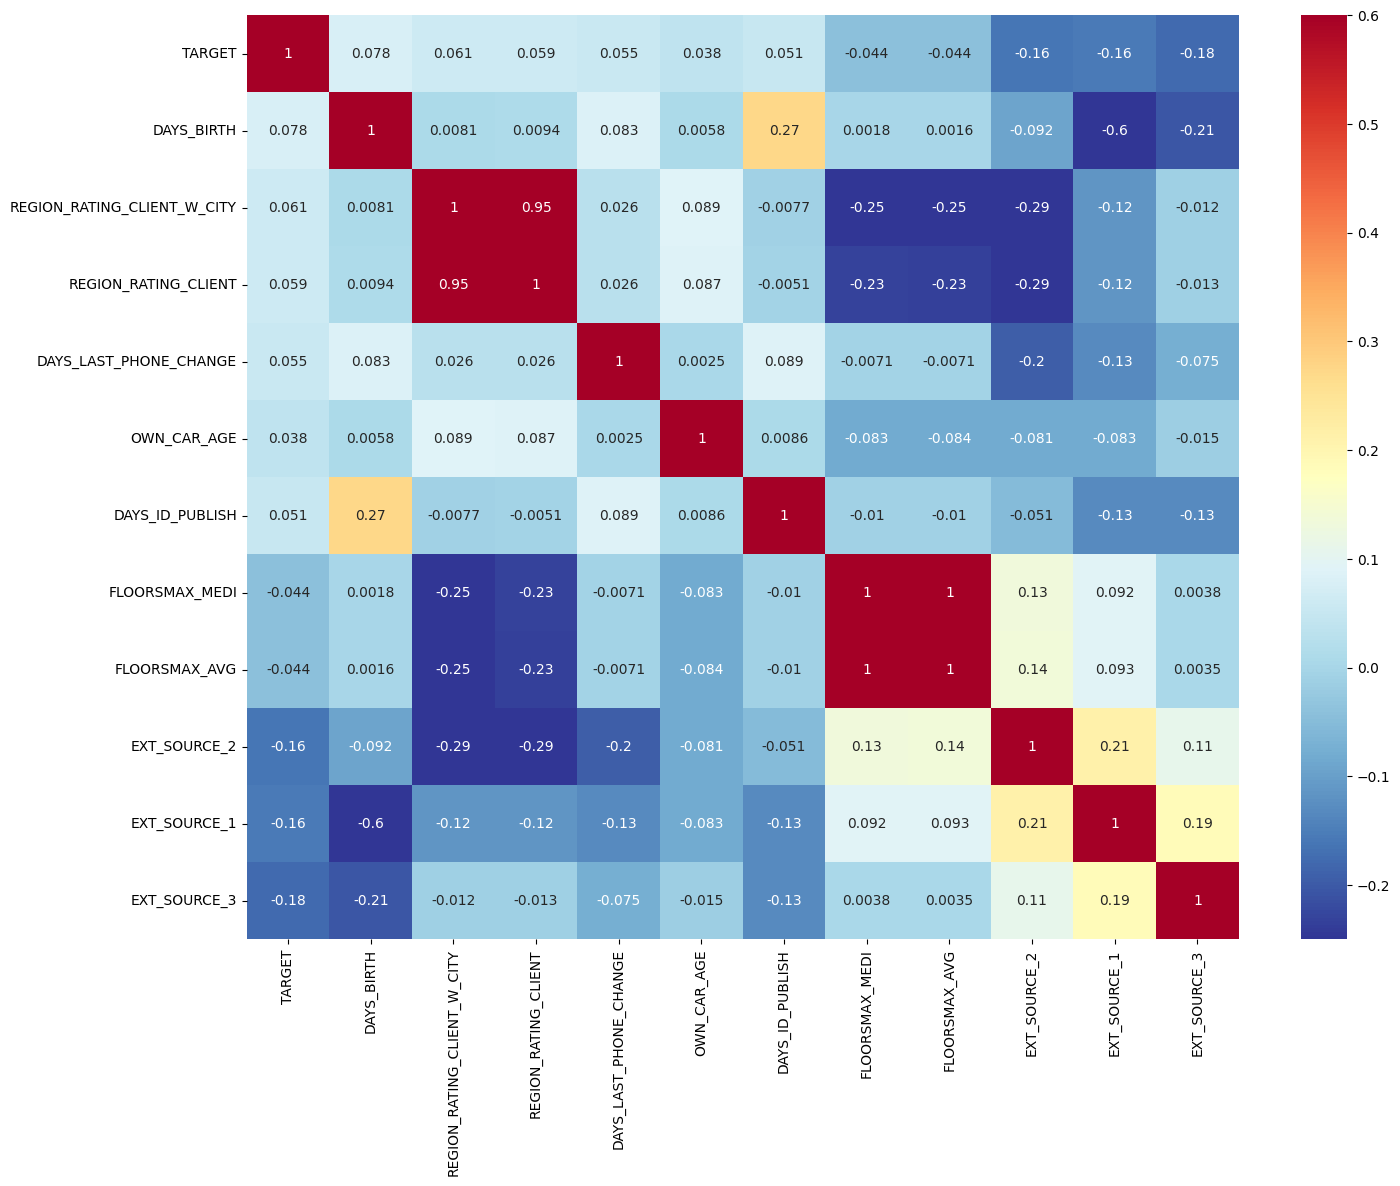

In [73]:
plt.figure(figsize = (16, 12))
sns.heatmap(application_train[first_test_with_10_features_columns].corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)

## Imputation simple

on va commencer par une simple imputation par la médiane et drop age voiture qui a trop de valeurs manquantes

In [74]:
first_look_into_reg_log_df = application_train[first_test_with_10_features_columns]

In [75]:
first_look_into_reg_log_df.drop(columns=['OWN_CAR_AGE'], inplace=True)

In [76]:
# Function to calculate missing values by column# Funct
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [77]:
first_look_into_reg_log_df

TARGET  DAYS_BIRTH  REGION_RATING_CLIENT_W_CITY  REGION_RATING_CLIENT   
0            1       -9461                            2                     2  \
1            0      -16765                            1                     1   
2            0      -19046                            2                     2   
3            0      -19005                            2                     2   
4            0      -19932                            2                     2   
...        ...         ...                          ...                   ...   
307506       0       -9327                            1                     1   
307507       0      -20775                            2                     2   
307508       0      -14966                            3                     3   
307509       1      -11961                            2                     2   
307510       0      -16856                            1                     1   

        DAYS_LAST_PHONE_CHANGE  DAYS_ID_PUBLISH  FLOORSMAX_MEDI   
0                      -1134.0            -2120          0.0833  \
1                       -828.0             -291          0.2917   
2                       -815.0            -2531             NaN   
3                       -617.0            -2437             NaN   
4                      -1106.0            -3458             NaN   
...                        ...              ...             ...   
307506                  -273.0            -1982          0.6042   
307507                     0.0            -4090          0.0833   
307508                 -1909.0            -5150          0.1667   
307509                  -322.0             -931          0.0417   
307510                  -787.0             -410          0.3750   

        FLOORSMAX_AVG  EXT_SOURCE_2  EXT_SOURCE_1  EXT_SOURCE_3  
0              0.0833      0.262949      0.083037      0.139376  
1              0.2917      0.622246      0.311267           NaN  
2                 NaN      0.555912           NaN      0.729567  
3                 NaN      0.650442           NaN           NaN  
4                 NaN      0.322738           NaN           NaN  
...               ...           ...           ...           ...  
307506         0.6042      0.681632      0.145570           NaN  
307507         0.0833      0.115992           NaN           NaN  
307508         0.1667      0.535722      0.744026      0.218859  
307509         0.0417      0.514163           NaN      0.661024  
307510         0.3750      0.708569      0.734460      0.113922  

[307511 rows x 11 columns]

In [78]:
first_look_into_reg_log_df.isnull().sum()

TARGET                              0
DAYS_BIRTH                          0
REGION_RATING_CLIENT_W_CITY         0
REGION_RATING_CLIENT                0
DAYS_LAST_PHONE_CHANGE              1
DAYS_ID_PUBLISH                     0
FLOORSMAX_MEDI                 153020
FLOORSMAX_AVG                  153020
EXT_SOURCE_2                      660
EXT_SOURCE_1                   173378
EXT_SOURCE_3                    60965
dtype: int64

In [79]:
column_to_impute_with_median = []

for col in first_look_into_reg_log_df.columns:
    if first_look_into_reg_log_df[col].isnull().sum() >= 660:
        column_to_impute_with_median.append(col)

In [80]:
column_to_impute_with_median

['FLOORSMAX_MEDI',
 'FLOORSMAX_AVG',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'EXT_SOURCE_3']

In [81]:
for col in column_to_impute_with_median:
    first_look_into_reg_log_df[col].fillna(first_look_into_reg_log_df[col].median(), inplace=True)

first_look_into_reg_log_df.dropna(inplace=True)

In [82]:
print(first_look_into_reg_log_df.isnull().sum())
print(first_look_into_reg_log_df.shape)

TARGET                         0
DAYS_BIRTH                     0
REGION_RATING_CLIENT_W_CITY    0
REGION_RATING_CLIENT           0
DAYS_LAST_PHONE_CHANGE         0
DAYS_ID_PUBLISH                0
FLOORSMAX_MEDI                 0
FLOORSMAX_AVG                  0
EXT_SOURCE_2                   0
EXT_SOURCE_1                   0
EXT_SOURCE_3                   0
dtype: int64
(307510, 11)


In [83]:
first_look_into_reg_log_df_TARGET = first_look_into_reg_log_df['TARGET']

In [84]:
first_look_into_reg_log_df_test = application_test.copy()
first_look_into_reg_log_df, first_look_into_reg_log_df_test = first_look_into_reg_log_df.align(first_look_into_reg_log_df_test, join='inner', axis=1)

In [85]:
first_look_into_reg_log_df = pd.concat([first_look_into_reg_log_df_TARGET, first_look_into_reg_log_df], axis=1)

In [86]:
first_look_into_reg_log_df

TARGET  DAYS_BIRTH  REGION_RATING_CLIENT_W_CITY  REGION_RATING_CLIENT   
0            1       -9461                            2                     2  \
1            0      -16765                            1                     1   
2            0      -19046                            2                     2   
3            0      -19005                            2                     2   
4            0      -19932                            2                     2   
...        ...         ...                          ...                   ...   
307506       0       -9327                            1                     1   
307507       0      -20775                            2                     2   
307508       0      -14966                            3                     3   
307509       1      -11961                            2                     2   
307510       0      -16856                            1                     1   

        DAYS_LAST_PHONE_CHANGE  DAYS_ID_PUBLISH  FLOORSMAX_MEDI   
0                      -1134.0            -2120          0.0833  \
1                       -828.0             -291          0.2917   
2                       -815.0            -2531          0.1667   
3                       -617.0            -2437          0.1667   
4                      -1106.0            -3458          0.1667   
...                        ...              ...             ...   
307506                  -273.0            -1982          0.6042   
307507                     0.0            -4090          0.0833   
307508                 -1909.0            -5150          0.1667   
307509                  -322.0             -931          0.0417   
307510                  -787.0             -410          0.3750   

        FLOORSMAX_AVG  EXT_SOURCE_2  EXT_SOURCE_1  EXT_SOURCE_3  
0              0.0833      0.262949      0.083037      0.139376  
1              0.2917      0.622246      0.311267      0.535276  
2              0.1667      0.555912      0.505998      0.729567  
3              0.1667      0.650442      0.505998      0.535276  
4              0.1667      0.322738      0.505998      0.535276  
...               ...           ...           ...           ...  
307506         0.6042      0.681632      0.145570      0.535276  
307507         0.0833      0.115992      0.505998      0.535276  
307508         0.1667      0.535722      0.744026      0.218859  
307509         0.0417      0.514163      0.505998      0.661024  
307510         0.3750      0.708569      0.734460      0.113922  

[307510 rows x 11 columns]

In [87]:
first_look_into_reg_log_df_test

DAYS_BIRTH  REGION_RATING_CLIENT_W_CITY  REGION_RATING_CLIENT   
0          -19241                            2                     2  \
1          -18064                            2                     2   
2          -20038                            2                     2   
3          -13976                            2                     2   
4          -13040                            2                     2   
...           ...                          ...                   ...   
48739      -19970                            3                     3   
48740      -11186                            2                     2   
48741      -15922                            2                     2   
48742      -13968                            2                     2   
48743      -13962                            2                     2   

       DAYS_LAST_PHONE_CHANGE  DAYS_ID_PUBLISH  FLOORSMAX_MEDI  FLOORSMAX_AVG   
0                     -1740.0             -812          0.1250         0.1250  \
1                         0.0            -1623             NaN            NaN   
2                      -856.0            -3503             NaN            NaN   
3                     -1805.0            -4208          0.3750         0.3750   
4                      -821.0            -4262             NaN            NaN   
...                       ...              ...             ...            ...   
48739                  -684.0            -3399             NaN            NaN   
48740                     0.0            -3003             NaN            NaN   
48741                  -838.0            -1504          0.3333         0.3333   
48742                 -2308.0            -1364          0.6250         0.6250   
48743                  -327.0            -4220             NaN            NaN   

       EXT_SOURCE_2  EXT_SOURCE_1  EXT_SOURCE_3  
0          0.789654      0.752614      0.159520  
1          0.291656      0.564990      0.432962  
2          0.699787           NaN      0.610991  
3          0.509677      0.525734      0.612704  
4          0.425687      0.202145           NaN  
...             ...           ...           ...  
48739      0.648575           NaN      0.643026  
48740      0.684596           NaN           NaN  
48741      0.632770      0.733503      0.283712  
48742      0.445701      0.373090      0.595456  
48743      0.456541           NaN      0.272134  

[48744 rows x 10 columns]

In [88]:
first_look_into_reg_log_df_test.isnull().sum()

DAYS_BIRTH                         0
REGION_RATING_CLIENT_W_CITY        0
REGION_RATING_CLIENT               0
DAYS_LAST_PHONE_CHANGE             0
DAYS_ID_PUBLISH                    0
FLOORSMAX_MEDI                 23321
FLOORSMAX_AVG                  23321
EXT_SOURCE_2                       8
EXT_SOURCE_1                   20532
EXT_SOURCE_3                    8668
dtype: int64

In [89]:
for col in first_look_into_reg_log_df_test.columns:
    first_look_into_reg_log_df_test[col].fillna(first_look_into_reg_log_df_test[col].median(), inplace=True)

In [90]:
first_look_into_reg_log_df_test.isnull().sum()

DAYS_BIRTH                     0
REGION_RATING_CLIENT_W_CITY    0
REGION_RATING_CLIENT           0
DAYS_LAST_PHONE_CHANGE         0
DAYS_ID_PUBLISH                0
FLOORSMAX_MEDI                 0
FLOORSMAX_AVG                  0
EXT_SOURCE_2                   0
EXT_SOURCE_1                   0
EXT_SOURCE_3                   0
dtype: int64

## Train Val split scaling & predict

In [91]:
X_train, X_val, y_train, y_val = train_test_split(
    first_look_into_reg_log_df.iloc[:,1:], first_look_into_reg_log_df['TARGET'], test_size=0.2, random_state=42
)

In [92]:
# Create a pipeline: Scale → Logistic Regression
pipeline = make_pipeline(
    StandardScaler(),  # or MinMaxScaler()
    LogisticRegression(penalty='l2', max_iter=1000, random_state=42)
)

In [93]:
X_val

DAYS_BIRTH  REGION_RATING_CLIENT_W_CITY  REGION_RATING_CLIENT   
280794      -12053                            2                     2  \
263702      -10916                            2                     2   
36464       -10066                            1                     1   
241741      -15064                            1                     1   
133587      -22026                            2                     2   
...            ...                          ...                   ...   
128160      -19859                            2                     2   
176776      -20757                            3                     3   
106891      -12008                            2                     2   
215181      -16555                            1                     1   
10118       -10921                            2                     2   

        DAYS_LAST_PHONE_CHANGE  DAYS_ID_PUBLISH  FLOORSMAX_MEDI   
280794                 -1939.0            -3569          0.3333  \
263702                    -3.0            -3534          0.3333   
36464                  -1059.0            -2511          0.1667   
241741                  -239.0            -4112          0.1667   
133587                 -1237.0            -4646          0.1667   
...                        ...              ...             ...   
128160                 -1109.0            -3181          0.1667   
176776                 -1586.0            -4241          0.1667   
106891                  -496.0             -998          0.0417   
215181                   -93.0             -101          0.1250   
10118                    -73.0            -3399          0.1667   

        FLOORSMAX_AVG  EXT_SOURCE_2  EXT_SOURCE_1  EXT_SOURCE_3  
280794         0.3333      0.779112      0.505998      0.759712  
263702         0.3333      0.587365      0.543037      0.692559  
36464          0.1667      0.643635      0.505998      0.535276  
241741         0.1667      0.733321      0.505998      0.686382  
133587         0.1667      0.246477      0.505998      0.247191  
...               ...           ...           ...           ...  
128160         0.1667      0.206778      0.505998      0.538863  
176776         0.1667      0.297709      0.505998      0.852828  
106891         0.0417      0.632754      0.505998      0.669057  
215181         0.1250      0.414150      0.595628      0.472253  
10118          0.1667      0.490305      0.244926      0.595456  

[61502 rows x 10 columns]

In [94]:
# Fit on training data
pipeline.fit(X_train, y_train) #Le scaling est fit et fait la puis apres modèle fit sur données scaled

# Predict on test data
y_pred = pipeline.predict(X_val) #Scaling appliqué avant predict

In [95]:
y_pred.shape

(61502,)

## Results overview

ROC-AUC: 0.718


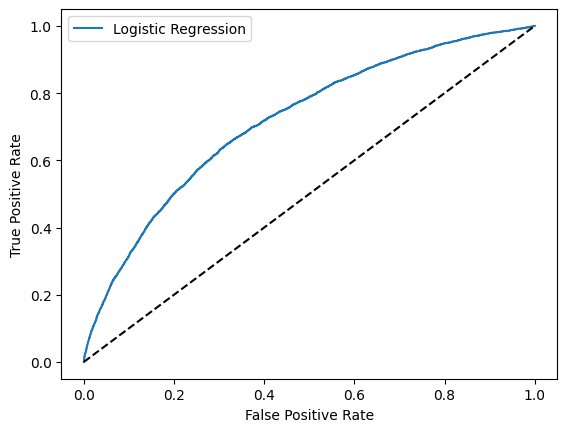

In [96]:
# Get predicted probabilities for class 1
y_proba = pipeline.predict_proba(X_val)[:, 1]

# ROC-AUC Score
print(f"ROC-AUC: {roc_auc_score(y_val, y_proba):.3f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_proba)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [97]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56485
           1       0.47      0.00      0.01      5017

    accuracy                           0.92     61502
   macro avg       0.69      0.50      0.48     61502
weighted avg       0.88      0.92      0.88     61502



In [98]:
pipeline.classes_

array([0, 1], dtype=int64)

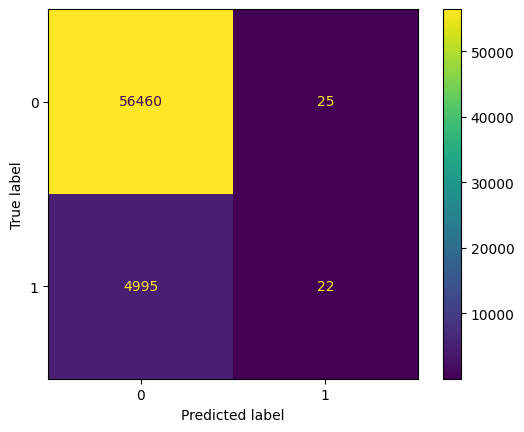

In [99]:
cm = confusion_matrix(y_val, y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipeline.classes_)
disp.plot()

## Check class imbalance

Pour vérifier si le modèle n'est pas trop influencé par le fait qu'ona beaucoup plsu de target = 0 que de = 1 on va tester avec un dataset split 50:50 pour les 0 et 1

In [100]:
y_val.value_counts()

TARGET
0    56485
1     5017
Name: count, dtype: int64

In [101]:
from sklearn.utils import resample

# Separate classes
class_0 = X_val[y_val == 0]
class_1 = X_val[y_val == 1]

# Undersample the majority class (or oversample the minority)
class_0_balanced = resample(class_0, n_samples=len(class_1), random_state=42)

# Combine into balanced validation set
X_val_balanced = pd.concat([class_0_balanced, class_1])
y_val_balanced = pd.Series([0] * len(class_1) + [1] * len(class_1))

# Verify balance
print(y_val_balanced.value_counts())  # Should be 50:50

0    5017
1    5017
Name: count, dtype: int64


In [102]:
y_pred_balanced = pipeline.predict(X_val_balanced)
print(pd.Series(y_pred_balanced).value_counts(normalize=True))

0    0.997708
1    0.002292
Name: proportion, dtype: float64


## Pondération des classes

In [103]:
print(pipeline.named_steps.keys())

dict_keys(['standardscaler', 'logisticregression'])


In [104]:
pipeline.set_params(logisticregression__class_weight='balanced')  # For LogisticRegression

# Retrain and re-evaluate on balanced validation set
pipeline.fit(X_train, y_train)
y_pred_balanced = pipeline.predict(X_val_balanced)
print(pd.Series(y_pred_balanced).value_counts(normalize=True))

0    0.512258
1    0.487742
Name: proportion, dtype: float64


## Prédiction avec pondération

In [105]:
# Fit on training data
pipeline.fit(X_train, y_train) #Le scaling est fit et fait la puis apres modèle fit sur données scaled

# Predict on test data
y_pred = pipeline.predict(X_val) #Scaling appliqué avant predict

In [106]:
y_pred.shape

(61502,)

##Results overview

ROC-AUC: 0.718


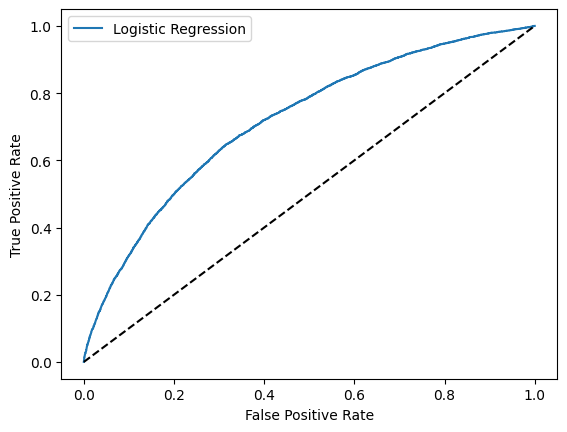

In [107]:
# Get predicted probabilities for class 1
y_proba = pipeline.predict_proba(X_val)[:, 1]

# ROC-AUC Score
print(f"ROC-AUC: {roc_auc_score(y_val, y_proba):.3f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_proba)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [108]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.68      0.79     56485
           1       0.15      0.65      0.25      5017

    accuracy                           0.68     61502
   macro avg       0.55      0.66      0.52     61502
weighted avg       0.89      0.68      0.75     61502



In [109]:
pipeline.classes_

array([0, 1], dtype=int64)

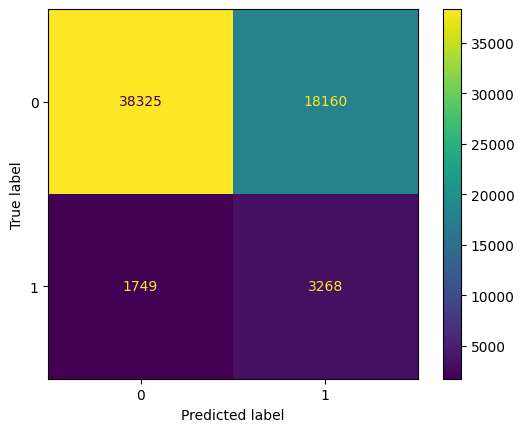

In [110]:
cm = confusion_matrix(y_val, y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipeline.classes_)
disp.plot()

## Ajustement du seuil de décision

In [111]:
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities for class 1
y_proba = pipeline.predict_proba(X_val)[:, 1]

# Find threshold that maximizes F1-score (or customize for business needs)
precision, recall, thresholds = precision_recall_curve(y_val, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_threshold = thresholds[np.argmax(f1_scores)]

# Apply new threshold
y_pred_tuned = (y_proba >= best_threshold).astype(int)
print(classification_report(y_val, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90     56485
           1       0.20      0.41      0.27      5017

    accuracy                           0.82     61502
   macro avg       0.57      0.63      0.58     61502
weighted avg       0.88      0.82      0.85     61502



In [112]:
best_threshold

0.6318738156043473

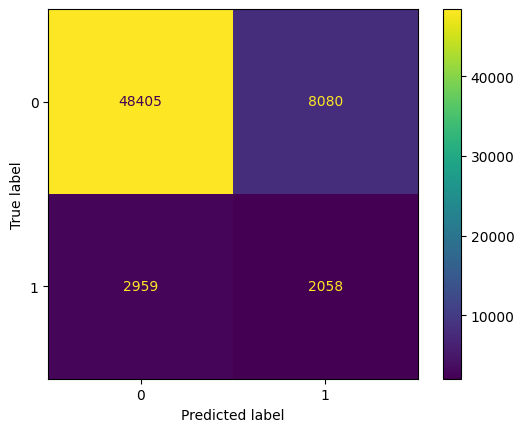

In [113]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_pred_tuned, labels=pipeline.classes_),
                              display_labels=pipeline.classes_)
disp.plot()

ROC-AUC: 0.718


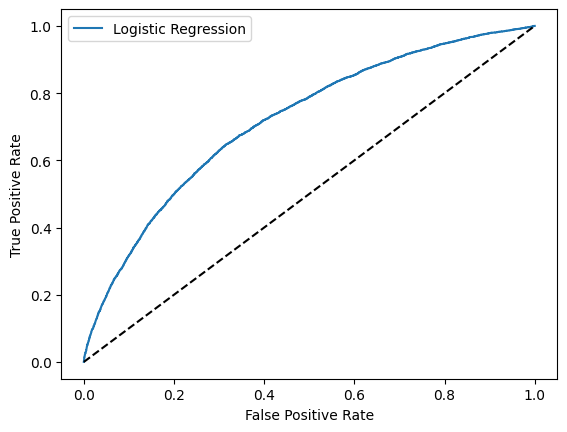

In [114]:
# Get predicted probabilities for class 1
y_proba = pipeline.predict_proba(X_val)[:, 1]

# ROC-AUC Score
print(f"ROC-AUC: {roc_auc_score(y_val, y_proba):.3f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_proba)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

La courbe ROC AUX n'est pas forcément adaptée due au déséquilibre entre nos deux classes et PR-AUX devrait etre plus adéquat.

In [115]:
from sklearn.metrics import precision_recall_curve, auc
precision, recall, _ = precision_recall_curve(y_val, y_proba)
pr_auc = auc(recall, precision)
print(f"PR-AUC: {pr_auc:.3f}")  # Likely much lower than ROC-AUC

PR-AUC: 0.197


## Test pondération plus sévère

In [116]:
pipeline.set_params(logisticregression__class_weight={0: 1, 1: 5})  # 5x penalty for FN
# Fit on training data
pipeline.fit(X_train, y_train) #Le scaling est fit et fait la puis apres modèle fit sur données scaled

# Predict on test data
y_pred = pipeline.predict(X_val) #Scaling appliqué avant predict

In [117]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     56485
           1       0.23      0.28      0.25      5017

    accuracy                           0.87     61502
   macro avg       0.58      0.60      0.59     61502
weighted avg       0.88      0.87      0.87     61502



In [118]:
report_test = classification_report(y_val, y_pred, output_dict=True)
report_test

{'0': {'precision': 0.934538833201125,
  'recall': 0.9177126670797557,
  'f1-score': 0.9260493242700063,
  'support': 56485.0},
 '1': {'precision': 0.2296983758700696,
  'recall': 0.2762607135738489,
  'f1-score': 0.25083702832322863,
  'support': 5017.0},
 'accuracy': 0.8653864914962115,
 'macro avg': {'precision': 0.5821186045355973,
  'recall': 0.5969866903268023,
  'f1-score': 0.5884431762966175,
  'support': 61502.0},
 'weighted avg': {'precision': 0.8770417668548288,
  'recall': 0.8653864914962115,
  'f1-score': 0.8709691628319233,
  'support': 61502.0}}

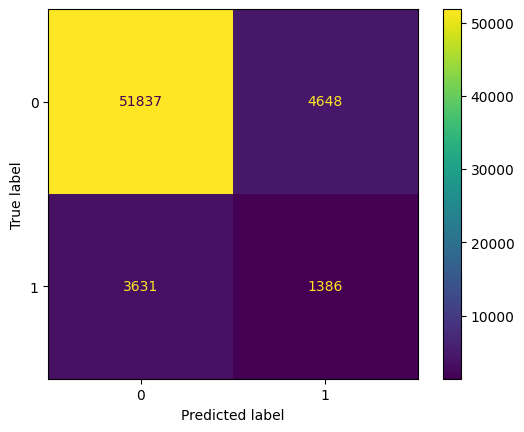

In [119]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_pred, labels=pipeline.classes_),
                              display_labels=pipeline.classes_)
disp.plot()

In [120]:
confusion_matrix(y_val, y_pred, labels=pipeline.classes_)

array([[51837,  4648],
       [ 3631,  1386]], dtype=int64)

In [121]:
from sklearn.metrics import precision_recall_curve, auc
precision, recall, _ = precision_recall_curve(y_val, y_proba)
pr_auc = auc(recall, precision)
print(f"PR-AUC: {pr_auc:.3f}")  # Likely much lower than ROC-AUC

PR-AUC: 0.197


# Logging baseline into MLflow

In [122]:
pipeline.predict_proba(X_val).shape

(61502, 2)

In [123]:
pipeline.classes_

array([0, 1], dtype=int64)

## Using balanced parameter

In [124]:
# --- MLflow Experiment Run ---
mlflow.set_experiment("Home Credit Baseline LogReg balanced parameter v2") # To organize runs into experiments

with mlflow.start_run(run_name="LogReg_10MostCorrelatedFeatures_MedianImpute_Balanced"): #Utile plus tard pour fine tuning
    # --- Define Model & Pipeline ---
    penalty_type = 'l2'
    logreg_max_iter = 1000
    class_weight_setting = 'balanced'
    random_state = 42

    pipeline_logreg = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty=penalty_type, max_iter=logreg_max_iter, class_weight=class_weight_setting, random_state=random_state)
    )

    # --- Log parameters ---
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("features", "TopBottom10_Corr_MinusCarAge")
    mlflow.log_param("imputation", "Median")
    mlflow.log_param("scaling", "StandardScaler")
    mlflow.log_param("penalty", penalty_type)
    mlflow.log_param("max_iter", logreg_max_iter)
    mlflow.log_param("class_weight", class_weight_setting)
    mlflow.log_param("random_state", random_state)
    mlflow.log_param("train_val_split", 0.2)

    # --- Train model ---
    pipeline_logreg.fit(X_train, y_train)

    # --- Predict & Calcul des métriques ---
    y_pred = pipeline_logreg.predict(X_val)
    y_proba = pipeline_logreg.predict_proba(X_val)[:, 1] # Probabilities for class 1

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred) # Default F1 for class 1
    roc_auc = roc_auc_score(y_val, y_proba)
    report = classification_report(y_val, y_pred, output_dict=True) # Get report as dict

    # --- Log métriques ---
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_f1_score", f1)
    mlflow.log_metric("val_roc_auc", roc_auc)
    # metrics from classification report
    mlflow.log_metric("val_precision_0", report['0']['precision'])
    mlflow.log_metric("val_recall_0", report['0']['recall'])
    mlflow.log_metric("val_f1_0", report['0']['f1-score'])
    mlflow.log_metric("val_precision_1", report['1']['precision'])
    mlflow.log_metric("val_recall_1", report['1']['recall'])
    mlflow.log_metric("val_f1_1", report['1']['f1-score'])

    # --- Input Example ---
    input_example = X_train.head(5) #Input example = small sample of valid input data (like one or a few rows from X_train or X_val DataFrame) that demonstrates the expected format.
    #Sert a si jamais on souhaite se resservir du modèle à ce qu'il vérifie que les données d'entrée aient le format attendu ici DataFrame Pandas

    # --- Log Model ---
    mlflow.sklearn.log_model(sk_model=pipeline_logreg, 
                             artifact_path="logistic_regression_pipeline",
                             input_example=input_example)

    # --- Log Artifacts (Example: Confusion Matrix) ---
    cm = confusion_matrix(y_val, y_pred, labels=pipeline_logreg.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_logreg.classes_)
    disp.plot()
    plt.title("Confusion Matrix (Validation Set)")
    cm_path = "confusion_matrix_baseline_val.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    plt.close() # Close the plot to prevent display in notebook output if desired

    print(f"Run ID: {mlflow.active_run().info.run_id} logged.")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print(classification_report(y_val, y_pred))

2025/05/16 09:30:30 INFO mlflow.tracking.fluent: Experiment with name 'Home Credit Baseline LogReg balanced parameter v2' does not exist. Creating a new experiment.
c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Maxime\AppData\Local\Programs\Python\Pyt

Run ID: 1ee4889af331470f939be991eb9de8c6 logged.
Validation ROC-AUC: 0.7184
              precision    recall  f1-score   support

           0       0.96      0.68      0.79     56485
           1       0.15      0.65      0.25      5017

    accuracy                           0.68     61502
   macro avg       0.55      0.66      0.52     61502
weighted avg       0.89      0.68      0.75     61502



## Tuning decision threshold

In [125]:
# --- MLflow Experiment Run ---
mlflow.set_experiment("Home Credit Baseline LogReg balanced parameter v2") # To organize runs into experiments

with mlflow.start_run(run_name="LogReg_10MostCorrelatedFeatures_MedianImpute_Balanced_TunedThreshold"): #Utile plus tard pour fine tuning
    # --- Define Model & Pipeline ---
    penalty_type = 'l2'
    logreg_max_iter = 1000
    class_weight_setting = 'balanced'
    random_state = 42

    pipeline_logreg = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty=penalty_type, max_iter=logreg_max_iter, class_weight=class_weight_setting, random_state=random_state)
    )

    # --- Log parameters ---
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("features", "TopBottom10_Corr_MinusCarAge")
    mlflow.log_param("imputation", "Median")
    mlflow.log_param("scaling", "StandardScaler")
    mlflow.log_param("penalty", penalty_type)
    mlflow.log_param("max_iter", logreg_max_iter)
    mlflow.log_param("class_weight", class_weight_setting)
    mlflow.log_param("random_state", random_state)
    mlflow.log_param("train_val_split", 0.2)

    # --- Train model ---
    pipeline_logreg.fit(X_train, y_train)

    # --- Predict & Evaluate (Standard Threshold 0.5) ---
    y_pred_default = pipeline_logreg.predict(X_val)
    y_proba = pipeline_logreg.predict_proba(X_val)[:, 1] # Probabilities for class 1

    # --- Threshold Tuning & Evaluation (Based on F1) ---
    precision, recall, thresholds = precision_recall_curve(y_val, y_proba)
    # Add epsilon to avoid division by zero if precision+recall is 0
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-9) # Use precision/recall[:-1] as thresholds has one less element
    best_threshold_f1 = thresholds[np.argmax(f1_scores)]
    y_pred_tuned_f1 = (y_proba >= best_threshold_f1).astype(int)

    # --- Calcul Métriques ---

    accuracy_tuned_threshold = accuracy_score(y_val, y_pred_tuned_f1)
    f1_tuned_threshold  = f1_score(y_val, y_pred_tuned_f1) # Default F1 for class 1
    roc_auc  = roc_auc_score(y_val, y_proba)
    report_tuned_threshold  = classification_report(y_val, y_pred_tuned_f1, output_dict=True) # Get report as dictionnary

    # --- Log métriques ---
    mlflow.log_metric("val_accuracy", accuracy_tuned_threshold)
    mlflow.log_metric("val_f1_score", f1_tuned_threshold)
    mlflow.log_metric("val_roc_auc", roc_auc)
    # metrics from classification report
    mlflow.log_metric("val_precision_0", report_tuned_threshold['0']['precision'])
    mlflow.log_metric("val_recall_0", report_tuned_threshold['0']['recall'])
    mlflow.log_metric("val_f1_0", report_tuned_threshold['0']['f1-score'])
    mlflow.log_metric("val_precision_1", report_tuned_threshold['1']['precision'])
    mlflow.log_metric("val_recall_1", report_tuned_threshold['1']['recall'])
    mlflow.log_metric("val_f1_1", report_tuned_threshold['1']['f1-score'])

    # --- Input Example ---
    input_example = X_train.head(5)

    # --- Log Model ---
    mlflow.sklearn.log_model(sk_model=pipeline_logreg, 
                             artifact_path="logistic_regression_pipeline",
                             input_example=input_example)

    # --- Log Artifacts (Example: Confusion Matrix) ---
    cm = confusion_matrix(y_val, y_pred_tuned_f1, labels=pipeline_logreg.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_logreg.classes_)
    disp.plot()
    plt.title("Confusion Matrix (Validation Set)")
    cm_path = "confusion_matrix_baseline_val.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    plt.close() # Close the plot to prevent display in notebook output if desired

    print(f"Run ID: {mlflow.active_run().info.run_id} logged.")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print(classification_report(y_val, y_pred_tuned_f1))

c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing

Run ID: f952aee2285b4d79bd285c20713e9c36 logged.
Validation ROC-AUC: 0.7184
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     56485
           1       0.20      0.41      0.27      5017

    accuracy                           0.82     61502
   macro avg       0.57      0.63      0.58     61502
weighted avg       0.88      0.82      0.85     61502



## Using dictionnary for weights

In [126]:
# --- MLflow Experiment Run ---
mlflow.set_experiment("Home Credit Baseline LogReg balanced parameter v2") # To organize runs into experiments

with mlflow.start_run(run_name="LogReg_10MostCorrelatedFeatures_MedianImpute_ManualClassWeights_TunedThreshold"): #Utile plus tard pour fine tuning
    # --- Define Model & Pipeline ---
    penalty_type = 'l2'
    logreg_max_iter = 1000
    class_weight_setting = {0: 1, 1: 5}
    random_state = 42

    pipeline_logreg = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty=penalty_type, max_iter=logreg_max_iter, class_weight=class_weight_setting, random_state=random_state)
    )

    # --- Log parameters ---
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("features", "TopBottom10_Corr_MinusCarAge")
    mlflow.log_param("imputation", "Median")
    mlflow.log_param("scaling", "StandardScaler")
    mlflow.log_param("penalty", penalty_type)
    mlflow.log_param("max_iter", logreg_max_iter)
    mlflow.log_param("class_weight", class_weight_setting)
    mlflow.log_param("random_state", random_state)
    mlflow.log_param("train_val_split", 0.2)

    # --- Train model ---
    pipeline_logreg.fit(X_train, y_train)

    # --- Predict & Evaluate (Standard Threshold 0.5) ---
    y_pred_default = pipeline_logreg.predict(X_val)
    y_proba = pipeline_logreg.predict_proba(X_val)[:, 1] # Probabilities for class 1

    # --- Threshold Tuning & Evaluation (Based on F1) ---
    precision, recall, thresholds = precision_recall_curve(y_val, y_proba)
    # Add epsilon to avoid division by zero if precision+recall is 0
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-9) # Use precision/recall[:-1] as thresholds has one less element
    best_threshold_f1 = thresholds[np.argmax(f1_scores)]
    y_pred_tuned_f1 = (y_proba >= best_threshold_f1).astype(int)

    # --- Calcul Métriques ---

    accuracy_tuned_threshold = accuracy_score(y_val, y_pred_tuned_f1)
    f1_tuned_threshold  = f1_score(y_val, y_pred_tuned_f1) # Default F1 for class 1
    roc_auc  = roc_auc_score(y_val, y_proba)
    report_tuned_threshold  = classification_report(y_val, y_pred_tuned_f1, output_dict=True) # Get report as dictionnary

    # --- Log métriques ---
    mlflow.log_metric("val_accuracy", accuracy_tuned_threshold)
    mlflow.log_metric("val_f1_score", f1_tuned_threshold)
    mlflow.log_metric("val_roc_auc", roc_auc)
    # metrics from classification report
    mlflow.log_metric("val_precision_0", report_tuned_threshold['0']['precision'])
    mlflow.log_metric("val_recall_0", report_tuned_threshold['0']['recall'])
    mlflow.log_metric("val_f1_0", report_tuned_threshold['0']['f1-score'])
    mlflow.log_metric("val_precision_1", report_tuned_threshold['1']['precision'])
    mlflow.log_metric("val_recall_1", report_tuned_threshold['1']['recall'])
    mlflow.log_metric("val_f1_1", report_tuned_threshold['1']['f1-score'])

    # --- Input Example ---
    input_example = X_train.head(5)
    
    # --- Log Model ---
    mlflow.sklearn.log_model(sk_model=pipeline_logreg, 
                             artifact_path="logistic_regression_pipeline",
                             input_example=input_example)

    # --- Log Artifacts (Example: Confusion Matrix) ---
    cm = confusion_matrix(y_val, y_pred_tuned_f1, labels=pipeline_logreg.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_logreg.classes_)
    disp.plot()
    plt.title("Confusion Matrix (Validation Set)")
    cm_path = "confusion_matrix_baseline_val.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    plt.close() # Close the plot to prevent display in notebook output if desired

    print(f"Run ID: {mlflow.active_run().info.run_id} logged.")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print(classification_report(y_val, y_pred_tuned_f1))

c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing

Run ID: 1ee292edd9474feea16666ae4e7dcbf9 logged.
Validation ROC-AUC: 0.7184
              precision    recall  f1-score   support

           0       0.94      0.85      0.89     56485
           1       0.20      0.43      0.27      5017

    accuracy                           0.81     61502
   macro avg       0.57      0.64      0.58     61502
weighted avg       0.88      0.81      0.84     61502



## Take a look at application train, bureau and bureau_balance

In [127]:
application_train

SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY   
0           100002                   0             0                1  \
1           100003                   0             0                0   
2           100004                   1             1                1   
3           100006                   0             0                1   
4           100007                   0             0                1   
...            ...                 ...           ...              ...   
307506      456251                   0             0                0   
307507      456252                   0             0                1   
307508      456253                   0             0                1   
307509      456254                   0             0                1   
307510      456255                   0             0                0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY   
0                  0          202500.0    406597.5      24700.5  \
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
307506             0          157500.0    254700.0      27558.0   
307507             0           72000.0    269550.0      12001.5   
307508             0          153000.0    677664.0      29979.0   
307509             0          171000.0    370107.0      20205.0   
307510             0          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  ...   
0              351000.0                    0.018801  ...  \
1             1129500.0                    0.003541  ...   
2              135000.0                    0.010032  ...   
3              297000.0                    0.008019  ...   
4              513000.0                    0.028663  ...   
...                 ...                         ...  ...   
307506         225000.0                    0.032561  ...   
307507         225000.0                    0.025164  ...   
307508         585000.0                    0.005002  ...   
307509         319500.0                    0.005313  ...   
307510         675000.0                    0.046220  ...   

        WALLSMATERIAL_MODE_Block  WALLSMATERIAL_MODE_Mixed   
0                            0.0                       0.0  \
1                            1.0                       0.0   
2                            0.0                       0.0   
3                            0.0                       0.0   
4                            0.0                       0.0   
...                          ...                       ...   
307506                       0.0                       0.0   
307507                       0.0                       0.0   
307508                       0.0                       0.0   
307509                       0.0                       0.0   
307510                       0.0                       0.0   

        WALLSMATERIAL_MODE_Monolithic  WALLSMATERIAL_MODE_Others   
0                                 0.0                        0.0  \
1                                 0.0                        0.0   
2                                 0.0                        0.0   
3                                 0.0                        0.0   
4                                 0.0                        0.0   
...                               ...                        ...   
307506                            0.0                        0.0   
307507                            0.0                        0.0   
307508                            0.0                        0.0   
307509                            0.0                        0.0   
307510                            0.0                        0.0   

        WALLSMATERIAL_MODE_Panel  WALLSMATE

In [128]:
bureau

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT   
0            215354       5714462        Closed      currency 1         -497  \
1            215354       5714463        Active      currency 1         -208   
2            215354       5714464        Active      currency 1         -203   
3            215354       5714465        Active      currency 1         -203   
4            215354       5714466        Active      currency 1         -629   
...             ...           ...           ...             ...          ...   
1716423      259355       5057750        Active      currency 1          -44   
1716424      100044       5057754        Closed      currency 1        -2648   
1716425      100044       5057762        Closed      currency 1        -1809   
1716426      246829       5057770        Closed      currency 1        -1878   
1716427      246829       5057778        Closed      currency 1         -463   

         CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT   
0                         0               -153.0             -153.0  \
1                         0               1075.0                NaN   
2                         0                528.0                NaN   
3                         0                  NaN                NaN   
4                         0               1197.0                NaN   
...                     ...                  ...                ...   
1716423                   0                -30.0                NaN   
1716424                   0              -2433.0            -2493.0   
1716425                   0              -1628.0             -970.0   
1716426                   0              -1513.0            -1513.0   
1716427                   0                  NaN             -387.0   

         AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM   
0                           NaN                   0        91323.00  \
1                           NaN                   0       225000.00   
2                           NaN                   0       464323.50   
3                           NaN                   0        90000.00   
4                       77674.5                   0      2700000.00   
...                         ...                 ...             ...   
1716423                     0.0                   0        11250.00   
1716424                  5476.5                   0        38130.84   
1716425                     NaN                   0        15570.00   
1716426                     NaN                   0        36000.00   
1716427                     NaN                   0        22500.00   

         AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE   
0                        0.0                   NaN                     0.0  \
1                   171342.0                   NaN                     0.0   
2                        NaN                   NaN                     0.0   
3                        NaN                   NaN                     0.0   
4                        NaN                   NaN                     0.0   
...                      ...                   ...                     ...   
1716423              11250.0                   0.0                     0.0   
1716424                  0.0                   0.0                     0.0   
1716425                  NaN                   NaN                     0.0   
1716426                  0.0                   0.0                     0.0   
1716427                  0.0                   NaN                     0.0   

             CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0        Consumer credit                -131          NaN  
1            Credit card                 -20          NaN  
2        Consumer credit                 -16          NaN  
3            Credit card                 -16          NaN  
4        Consumer credit                 -21          NaN  
...                  ...                 ... 

In [129]:
application_train[application_train['SK_ID_CURR'] == 5715448]

Empty DataFrame
Columns: [SK_ID_CURR, NAME_CONTRACT_TYPE, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, APARTMENTS_MODE, BASEMENTAREA_MODE, YEARS_BEGINEXPLUATATION_MODE, YEARS_BUILD_MODE, COMMONAREA_MODE, ELEVATORS_MODE, ENTRANCES_MODE, FLOORSMAX_MODE, FLOORSMIN_MODE, LANDAREA_MODE, LIVINGAPARTMENTS_MODE, LIVINGAREA_MODE, NONLIVINGAPARTMENTS_MODE, NONLIVINGAREA_MODE, APARTMENTS_MEDI, BASEMENTAREA_MEDI, YEARS_BEGINEXPLUATATION_MEDI, YEARS_BUILD_MEDI, COMMONAREA_MEDI, ELEVATORS_MEDI, ENTRANCES_MEDI, FLOORSMAX_MEDI, FLOORSMIN_MEDI, LANDAREA_MEDI, LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, NONLIVINGAPARTMENTS_MEDI, NONLIVINGAREA_MEDI, TOTALAREA_MODE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, FLAG_DOCUMENT_6, FLAG_DOCUMENT_7, FLAG_DOCUMENT_8, FLAG_DOCUMENT_9, FLAG_DOCUMENT_10, FLAG_DOCUMENT_11, FLAG_DOCUMENT_12, FLAG_DOCUMENT_13, FLAG_DOCUMENT_14, FLAG_DOCUMENT_15, FLAG_DOCUMENT_16, FLAG_DOCUMENT_17, FLAG_DOCUMENT_18, FLAG_DOCUMENT_19, ...]
Index: []

[0 rows x 240 columns]

In [130]:
bureau[bureau['SK_ID_CURR'] == 5715448]

Empty DataFrame
Columns: [SK_ID_CURR, SK_ID_BUREAU, CREDIT_ACTIVE, CREDIT_CURRENCY, DAYS_CREDIT, CREDIT_DAY_OVERDUE, DAYS_CREDIT_ENDDATE, DAYS_ENDDATE_FACT, AMT_CREDIT_MAX_OVERDUE, CNT_CREDIT_PROLONG, AMT_CREDIT_SUM, AMT_CREDIT_SUM_DEBT, AMT_CREDIT_SUM_LIMIT, AMT_CREDIT_SUM_OVERDUE, CREDIT_TYPE, DAYS_CREDIT_UPDATE, AMT_ANNUITY]
Index: []

In [131]:
bureau_balance

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0              5715448               0      C
1              5715448              -1      C
2              5715448              -2      C
3              5715448              -3      C
4              5715448              -4      C
...                ...             ...    ...
27299920       5041336             -47      X
27299921       5041336             -48      X
27299922       5041336             -49      X
27299923       5041336             -50      X
27299924       5041336             -51      X

[27299925 rows x 3 columns]

In [132]:
bureau_balance[bureau_balance['SK_ID_BUREAU'] == 5715448]

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0        5715448               0      C
1        5715448              -1      C
2        5715448              -2      C
3        5715448              -3      C
4        5715448              -4      C
5        5715448              -5      C
6        5715448              -6      C
7        5715448              -7      C
8        5715448              -8      C
9        5715448              -9      0
10       5715448             -10      0
11       5715448             -11      X
12       5715448             -12      X
13       5715448             -13      X
14       5715448             -14      0
15       5715448             -15      0
16       5715448             -16      0
17       5715448             -17      0
18       5715448             -18      0
19       5715448             -19      0
20       5715448             -20      X
21       5715448             -21      X
22       5715448             -22      X
23       5715448             -23      X
24       5715448             -24      X
25       5715448             -25      X
26       5715448             -26      X

In [133]:
pd.set_option('display.max_colwidth', None) #Displays all columns with no truncation
# Optional: Increase max rows/columns if viewing a DataFrame
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
HomeCredit

Unnamed: 0                         Table                    Row   
0             1  application_{train|test}.csv             SK_ID_CURR  \
1             2  application_{train|test}.csv                 TARGET   
2             5  application_{train|test}.csv     NAME_CONTRACT_TYPE   
3             6  application_{train|test}.csv            CODE_GENDER   
4             7  application_{train|test}.csv           FLAG_OWN_CAR   
..          ...                           ...                    ...   
214         217     installments_payments.csv  NUM_INSTALMENT_NUMBER   
215         218     installments_payments.csv        DAYS_INSTALMENT   
216         219     installments_payments.csv     DAYS_ENTRY_PAYMENT   
217         220     installments_payments.csv         AMT_INSTALMENT   
218         221     installments_payments.csv            AMT_PAYMENT   

                                                                                                                                                                                     Description   
0                                                                                                                                                                       ID of loan in our sample  \
1    Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)   
2                                                                                                                                                    Identification if loan is cash or revolving   
3                                                                                                                                                                           Gender of the client   
4                                                                                                                                                                  Flag if the client owns a car   
..                                                                                                                                                                                           ...   
214                                                                                                                                                      On which installment we observe payment   
215                                                                               When the installment of previous credit was supposed to be paid (relative to application date of current loan)   
216                                                                                    When was the installments of previous credit paid actually (relative to application date of current loan)   
217                                                                                                            What was the prescribed installment amount of previous credit on this installment   
218                                                                                                                         What the client actually paid on previous credit on this installment   

                                   Special  
0                                      NaN  
1                                      NaN  
2                                      NaN  
3                                      NaN  
4                                      NaN  
..                                     ...  
214                                    NaN  
215  time only relative to the application  
216  time only relative to the application  
217                                    NaN  
218                                    NaN  

[219 rows x 5 columns]

In [134]:
pd.set_option('display.max_colwidth', None)
HomeCredit[HomeCredit['Table'] == "bureau_balance.csv"][['Row', 'Description']]
# --- Optional: Reset options back to default afterwards ---
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')

Row   
139    SK_BUREAU_ID  \
140  MONTHS_BALANCE   
141          STATUS   

                                                                                                                                                                                                                                          Description  
139                                                                                                                                Recoded ID of Credit Bureau credit (unique coding for each application) - use this to join to CREDIT_BUREAU table   
140                                                                                                                                                                Month of balance relative to application date (-1 means the freshest balance date)  
141  Status of Credit Bureau loan during the month (active, closed, DPD0-30,
 [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,
 5 means DPD 120+ or sold or written off ] )

In [135]:
pd.reset_option('display.max_colwidth')

In [136]:
bureau_balance[bureau_balance['SK_ID_BUREAU'] == (5714462) | (5714463) | (5714464) | (5714465) | (5714466)]

Empty DataFrame
Columns: [SK_ID_BUREAU, MONTHS_BALANCE, STATUS]
Index: []

In [137]:
bureau_balance[bureau_balance['SK_ID_BUREAU'] == 5714465]

Empty DataFrame
Columns: [SK_ID_BUREAU, MONTHS_BALANCE, STATUS]
Index: []

In [138]:
bureau_balance['STATUS'].value_counts()

STATUS
C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: count, dtype: int64

# Aggregating bureau_balance

In [139]:
bureau_balance

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0              5715448               0      C
1              5715448              -1      C
2              5715448              -2      C
3              5715448              -3      C
4              5715448              -4      C
...                ...             ...    ...
27299920       5041336             -47      X
27299921       5041336             -48      X
27299922       5041336             -49      X
27299923       5041336             -50      X
27299924       5041336             -51      X

[27299925 rows x 3 columns]

In [140]:
bureau_balance['STATUS'].value_counts()

STATUS
C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: count, dtype: int64

In [141]:
dataset_overview(bureau_balance)

DATASET OVERVIEW

DATASET SHAPE:
Rows: 27299925, Columns: 3

COLUMN INFORMATION:
SK_ID_BUREAU       int64
MONTHS_BALANCE     int64
STATUS            object

MISSING VALUES:
Empty DataFrame
Columns: [Missing Values, Percentage (%)]
Index: []

NUMERIC COLUMNS STATISTICS:
                        mean     median            std        min        max
SK_ID_BUREAU    6.036297e+06  6070821.0  492348.856904  5001709.0  6842888.0
MONTHS_BALANCE -3.074169e+01      -25.0      23.864509      -96.0        0.0

CATEGORICAL COLUMNS STATISTICS:

Column: STATUS
Unique values: 8
Top 5 values:
STATUS
C    13646993
0     7499507
X     5810482
1      242347
5       62406
Name: count, dtype: int64


On dispose dans bureau_balance des infos sur les paiements mensuels pour chaque loan/prêt et nous permet de savoir combien de temps à duré un prêt, son statut final et l'état des paiements par exemple si un paiement était en retard et si oui de combien de jours ou bien si il est fini, si son statut est inconnu, ...

On va créer les features suivantes : _ La durée du prêt --> Number of months
                                     _ Last known status --> C ou X ou ... Pour la robustesse si on a un C au cours d'un des mois mais que le dernier mois n'est pas C on prend le C comme valeur 
                                     _ Le nombre de délais enregistrés sur les paiements --> Count DPD status
                                     _ Le nombre pour chaque catégorie de délai --> Count DPD status for each category 
                                     _ La moyenne de durée des délais --> Mean DPD values
                                     _ Variable catégorielle Short ou Long pour short ou long term loan --> under 5 years short term more than 5 years long term

In [142]:
list_of_features_names_bureau_balance = []

### Durée du prêt

In [143]:
bureau_balance_loan_duration_months = bureau_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].count().reset_index()

In [144]:
bureau_balance_loan_duration_months

SK_ID_BUREAU  MONTHS_BALANCE
0            5001709              97
1            5001710              83
2            5001711               4
3            5001712              19
4            5001713              22
...              ...             ...
817390       6842884              48
817391       6842885              24
817392       6842886              33
817393       6842887              37
817394       6842888              62

[817395 rows x 2 columns]

In [145]:
bureau_balance_loan_duration_months.rename(columns = {'MONTHS_BALANCE' : 'MONTHS_LOAN_DURATION'}, inplace=True)

In [146]:
bureau_balance_loan_duration_months

SK_ID_BUREAU  MONTHS_LOAN_DURATION
0            5001709                    97
1            5001710                    83
2            5001711                     4
3            5001712                    19
4            5001713                    22
...              ...                   ...
817390       6842884                    48
817391       6842885                    24
817392       6842886                    33
817393       6842887                    37
817394       6842888                    62

[817395 rows x 2 columns]

In [147]:
list_of_features_names_bureau_balance.append('bureau_balance_loan_duration_months')

### Last known status

In [148]:
bureau_balance_last_known_loan_status = bureau_balance.sort_values(by='MONTHS_BALANCE', ascending=False).groupby('SK_ID_BUREAU').first().reset_index()[['SK_ID_BUREAU', 'STATUS']]

In [149]:
pd.get_dummies(bureau_balance_last_known_loan_status, dtype=int)

SK_ID_BUREAU  STATUS_0  STATUS_1  STATUS_2  STATUS_3  STATUS_4   
0            5001709         0         0         0         0         0  \
1            5001710         0         0         0         0         0   
2            5001711         0         0         0         0         0   
3            5001712         0         0         0         0         0   
4            5001713         0         0         0         0         0   
...              ...       ...       ...       ...       ...       ...   
817390       6842884         0         0         0         0         0   
817391       6842885         0         0         0         0         0   
817392       6842886         0         0         0         0         0   
817393       6842887         0         0         0         0         0   
817394       6842888         0         0         0         0         0   

        STATUS_5  STATUS_C  STATUS_X  
0              0         1         0  
1              0         1         0  
2              0         0         1  
3              0         1         0  
4              0         0         1  
...          ...       ...       ...  
817390         0         1         0  
817391         1         0         0  
817392         0         1         0  
817393         0         1         0  
817394         0         1         0  

[817395 rows x 9 columns]

In [150]:
bureau_balance_last_known_loan_status = pd.get_dummies(bureau_balance_last_known_loan_status, dtype=int)

In [151]:
list_of_features_names_bureau_balance.append('bureau_balance_last_known_loan_status')

In [152]:
bureau_balance[bureau_balance['STATUS'] == 'C']

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0              5715448               0      C
1              5715448              -1      C
2              5715448              -2      C
3              5715448              -3      C
4              5715448              -4      C
...                ...             ...    ...
27299863       5041172             -64      C
27299864       5041172             -65      C
27299865       5041172             -66      C
27299866       5041172             -67      C
27299867       5041172             -68      C

[13646993 rows x 3 columns]

In [153]:
pd.merge(left=bureau_balance.sort_values(by='MONTHS_BALANCE', ascending=False).groupby('SK_ID_BUREAU').first().reset_index()[['SK_ID_BUREAU', 'STATUS']], right=bureau_balance[bureau_balance['STATUS'] == 'C'], on='SK_ID_BUREAU', how='outer', indicator=True)

SK_ID_BUREAU STATUS_x  MONTHS_BALANCE STATUS_y _merge
0              5001709        C             0.0        C   both
1              5001709        C            -1.0        C   both
2              5001709        C            -2.0        C   both
3              5001709        C            -3.0        C   both
4              5001709        C            -4.0        C   both
...                ...      ...             ...      ...    ...
14014779       6842888        C           -47.0        C   both
14014780       6842888        C           -48.0        C   both
14014781       6842888        C           -49.0        C   both
14014782       6842888        C           -50.0        C   both
14014783       6842888        C           -51.0        C   both

[14014784 rows x 5 columns]

In [154]:
test_to_see_if_C_before = pd.merge(left=bureau_balance.sort_values(by='MONTHS_BALANCE', ascending=False).groupby('SK_ID_BUREAU').first().reset_index()[['SK_ID_BUREAU', 'STATUS']], right=bureau_balance[bureau_balance['STATUS'] == 'C'], on='SK_ID_BUREAU', how='outer', indicator=True)
test_to_see_if_C_before[test_to_see_if_C_before['_merge'] == 'right_only']

Empty DataFrame
Columns: [SK_ID_BUREAU, STATUS_x, MONTHS_BALANCE, STATUS_y, _merge]
Index: []

There are no loans (SK_ID_BUREAU) in the dataset where the loan was marked 'C' (Closed) in some month, but then continued to be tracked with a different, more recent status (like '0', 'X', '1', etc.).

### Nombre de délais de paiements enregistrés

In [155]:
bureau_balance['STATUS'].dtypes

dtype('O')

In [156]:
bureau_balance_for_dpd_flag = bureau_balance.copy()

In [157]:
non_dpd_statuses = ['C', 'X', '0']

dpd_flagged = ~bureau_balance_for_dpd_flag['STATUS'].isin(non_dpd_statuses) #Cree True/False value en fonction de la condition ici dpd --> True
bureau_balance_for_dpd_flag['DPD_FLAG'] = dpd_flagged.astype(int)

In [158]:
bureau_balance[bureau_balance['STATUS'] == '1']

SK_ID_BUREAU  MONTHS_BALANCE STATUS
464            5715793             -39      1
465            5715793             -40      1
468            5715793             -43      1
499            5715795             -30      1
500            5715795             -31      1
...                ...             ...    ...
27298834       5011723             -76      1
27298836       5011723             -78      1
27298837       5011723             -79      1
27298840       5011723             -82      1
27298843       5011723             -85      1

[242347 rows x 3 columns]

In [159]:
bureau_balance_for_dpd_flag[bureau_balance_for_dpd_flag['STATUS'] == '1'] #Penser a mettre apostrophes car status est un object

SK_ID_BUREAU  MONTHS_BALANCE STATUS  DPD_FLAG
464            5715793             -39      1         1
465            5715793             -40      1         1
468            5715793             -43      1         1
499            5715795             -30      1         1
500            5715795             -31      1         1
...                ...             ...    ...       ...
27298834       5011723             -76      1         1
27298836       5011723             -78      1         1
27298837       5011723             -79      1         1
27298840       5011723             -82      1         1
27298843       5011723             -85      1         1

[242347 rows x 4 columns]

In [160]:
bureau_balance_nombre_delais_de_paiements = bureau_balance_for_dpd_flag.groupby(by='SK_ID_BUREAU')['DPD_FLAG'].sum().reset_index()

In [161]:
bureau_balance_nombre_delais_de_paiements

SK_ID_BUREAU  DPD_FLAG
0            5001709         0
1            5001710         0
2            5001711         0
3            5001712         0
4            5001713         0
...              ...       ...
817390       6842884         0
817391       6842885        12
817392       6842886         0
817393       6842887         0
817394       6842888         1

[817395 rows x 2 columns]

In [162]:
list_of_features_names_bureau_balance.append('bureau_balance_nombre_delais_de_paiements')

In [163]:
bureau_balance[bureau_balance['SK_ID_BUREAU'] == 6842885]

SK_ID_BUREAU  MONTHS_BALANCE STATUS
23543909       6842885               0      5
23543910       6842885              -1      5
23543911       6842885              -2      5
23543912       6842885              -3      5
23543913       6842885              -4      5
23543914       6842885              -5      5
23543915       6842885              -6      5
23543916       6842885              -7      5
23543917       6842885              -8      5
23543918       6842885              -9      5
23543919       6842885             -10      5
23543920       6842885             -11      5
23543921       6842885             -12      0
23543922       6842885             -13      0
23543923       6842885             -14      0
23543924       6842885             -15      0
23543925       6842885             -16      0
23543926       6842885             -17      0
23543927       6842885             -18      0
23543928       6842885             -19      0
23543929       6842885             -20      0
23543930       6842885             -21      0
23543931       6842885             -22      0
23543932       6842885             -23      0

### Nombre de délais pour chaque catégorie

In [164]:
bureau_balance.groupby('SK_ID_BUREAU')['STATUS'].value_counts()

SK_ID_BUREAU  STATUS
5001709       C         86
              X         11
5001710       C         48
              X         30
              0          5
                        ..
6842887       C         31
              0          6
6842888       C         52
              0          9
              1          1
Name: count, Length: 1714229, dtype: int64

In [165]:
bureau_balance[bureau_balance['SK_ID_BUREAU'] == 5001709]

SK_ID_BUREAU  MONTHS_BALANCE STATUS
26079753       5001709               0      C
26079754       5001709              -1      C
26079755       5001709              -2      C
26079756       5001709              -3      C
26079757       5001709              -4      C
...                ...             ...    ...
26079845       5001709             -92      X
26079846       5001709             -93      X
26079847       5001709             -94      X
26079848       5001709             -95      X
26079849       5001709             -96      X

[97 rows x 3 columns]

In [166]:
bureau_balance.groupby('SK_ID_BUREAU')['STATUS'].value_counts().unstack()

STATUS           0    1   2   3   4     5     C     X
SK_ID_BUREAU                                         
5001709        NaN  NaN NaN NaN NaN   NaN  86.0  11.0
5001710        5.0  NaN NaN NaN NaN   NaN  48.0  30.0
5001711        3.0  NaN NaN NaN NaN   NaN   NaN   1.0
5001712       10.0  NaN NaN NaN NaN   NaN   9.0   NaN
5001713        NaN  NaN NaN NaN NaN   NaN   NaN  22.0
...            ...  ...  ..  ..  ..   ...   ...   ...
6842884        9.0  NaN NaN NaN NaN   NaN  20.0  19.0
6842885       12.0  NaN NaN NaN NaN  12.0   NaN   NaN
6842886        8.0  NaN NaN NaN NaN   NaN  25.0   NaN
6842887        6.0  NaN NaN NaN NaN   NaN  31.0   NaN
6842888        9.0  1.0 NaN NaN NaN   NaN  52.0   NaN

[817395 rows x 8 columns]

In [167]:
bureau_balance.groupby('SK_ID_BUREAU')['STATUS'].value_counts().unstack(fill_value=0).reset_index()

STATUS  SK_ID_BUREAU   0  1  2  3  4   5   C   X
0            5001709   0  0  0  0  0   0  86  11
1            5001710   5  0  0  0  0   0  48  30
2            5001711   3  0  0  0  0   0   0   1
3            5001712  10  0  0  0  0   0   9   0
4            5001713   0  0  0  0  0   0   0  22
...              ...  .. .. .. .. ..  ..  ..  ..
817390       6842884   9  0  0  0  0   0  20  19
817391       6842885  12  0  0  0  0  12   0   0
817392       6842886   8  0  0  0  0   0  25   0
817393       6842887   6  0  0  0  0   0  31   0
817394       6842888   9  1  0  0  0   0  52   0

[817395 rows x 9 columns]

In [168]:
bureau_balance_nombre_de_delais_de_paiements_par_categorie = bureau_balance.groupby('SK_ID_BUREAU')['STATUS'].value_counts().unstack(fill_value=0).reset_index()

bureau_balance.groupby('SK_ID_BUREAU')['STATUS'].value_counts() crée une series pandas avec pour chaque index le compte de chaque valeur de status et .unstack() permet de créer un tableau croisé et le fill_value permet de remplacer les NaNs par 0 et si on fait a la suite un reset_index() on peut récupérer le compte de status pour chaque SK_ID_BUREAU

In [169]:
bureau_balance_nombre_de_delais_de_paiements_par_categorie.reset_index()

STATUS   index  SK_ID_BUREAU   0  1  2  3  4   5   C   X
0            0       5001709   0  0  0  0  0   0  86  11
1            1       5001710   5  0  0  0  0   0  48  30
2            2       5001711   3  0  0  0  0   0   0   1
3            3       5001712  10  0  0  0  0   0   9   0
4            4       5001713   0  0  0  0  0   0   0  22
...        ...           ...  .. .. .. .. ..  ..  ..  ..
817390  817390       6842884   9  0  0  0  0   0  20  19
817391  817391       6842885  12  0  0  0  0  12   0   0
817392  817392       6842886   8  0  0  0  0   0  25   0
817393  817393       6842887   6  0  0  0  0   0  31   0
817394  817394       6842888   9  1  0  0  0   0  52   0

[817395 rows x 10 columns]

In [170]:
bureau_balance_nombre_de_delais_de_paiements_par_categorie.columns

Index(['SK_ID_BUREAU', '0', '1', '2', '3', '4', '5', 'C', 'X'], dtype='object', name='STATUS')

In [171]:
bureau_balance_nombre_de_delais_de_paiements_par_categorie.columns.name = None

In [172]:
bureau_balance_nombre_de_delais_de_paiements_par_categorie

SK_ID_BUREAU   0  1  2  3  4   5   C   X
0            5001709   0  0  0  0  0   0  86  11
1            5001710   5  0  0  0  0   0  48  30
2            5001711   3  0  0  0  0   0   0   1
3            5001712  10  0  0  0  0   0   9   0
4            5001713   0  0  0  0  0   0   0  22
...              ...  .. .. .. .. ..  ..  ..  ..
817390       6842884   9  0  0  0  0   0  20  19
817391       6842885  12  0  0  0  0  12   0   0
817392       6842886   8  0  0  0  0   0  25   0
817393       6842887   6  0  0  0  0   0  31   0
817394       6842888   9  1  0  0  0   0  52   0

[817395 rows x 9 columns]

In [173]:
list_of_features_names_bureau_balance.append('bureau_balance_nombre_de_delais_de_paiements_par_categorie')

### Moyenne de durée des délais

In [174]:
bureau_balance

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0              5715448               0      C
1              5715448              -1      C
2              5715448              -2      C
3              5715448              -3      C
4              5715448              -4      C
...                ...             ...    ...
27299920       5041336             -47      X
27299921       5041336             -48      X
27299922       5041336             -49      X
27299923       5041336             -50      X
27299924       5041336             -51      X

[27299925 rows x 3 columns]

In [175]:
Values_to_map = {'C':0, 'X':0, '0':0, '1':15, '2':45, '3':75, '4':105, '5':120}

In [176]:
bureau_balance_for_mean_delay_calc = bureau_balance.copy()
bureau_balance_for_mean_delay_calc['MEAN_DAYS_PAST_DUE'] = bureau_balance_for_mean_delay_calc['STATUS'].map(Values_to_map).fillna('Unknown')

In [177]:
mask_1 = bureau_balance_for_mean_delay_calc['STATUS'] == '1'
mask_5 = bureau_balance_for_mean_delay_calc['STATUS'] == '5'

In [178]:
bureau_balance_for_mean_delay_calc[mask_1]

SK_ID_BUREAU  MONTHS_BALANCE STATUS  MEAN_DAYS_PAST_DUE
464            5715793             -39      1                  15
465            5715793             -40      1                  15
468            5715793             -43      1                  15
499            5715795             -30      1                  15
500            5715795             -31      1                  15
...                ...             ...    ...                 ...
27298834       5011723             -76      1                  15
27298836       5011723             -78      1                  15
27298837       5011723             -79      1                  15
27298840       5011723             -82      1                  15
27298843       5011723             -85      1                  15

[242347 rows x 4 columns]

In [179]:
bureau_balance_for_mean_delay_calc[mask_5]

SK_ID_BUREAU  MONTHS_BALANCE STATUS  MEAN_DAYS_PAST_DUE
29354          5230570             -66      5                 120
29355          5230570             -67      5                 120
29356          5230570             -68      5                 120
29357          5230570             -69      5                 120
29358          5230570             -70      5                 120
...                ...             ...    ...                 ...
27291903       5009756             -92      5                 120
27291904       5009756             -93      5                 120
27291905       5009756             -94      5                 120
27291906       5009756             -95      5                 120
27291907       5009756             -96      5                 120

[62406 rows x 4 columns]

In [180]:
bureau_balance_for_mean_delay_calc.groupby('SK_ID_BUREAU')['MEAN_DAYS_PAST_DUE'].mean()

SK_ID_BUREAU
5001709     0.000000
5001710     0.000000
5001711     0.000000
5001712     0.000000
5001713     0.000000
             ...    
6842884     0.000000
6842885    60.000000
6842886     0.000000
6842887     0.000000
6842888     0.241935
Name: MEAN_DAYS_PAST_DUE, Length: 817395, dtype: float64

In [181]:
bureau_balance_for_mean_delay_calc[bureau_balance_for_mean_delay_calc['SK_ID_BUREAU'] == 6842885]

SK_ID_BUREAU  MONTHS_BALANCE STATUS  MEAN_DAYS_PAST_DUE
23543909       6842885               0      5                 120
23543910       6842885              -1      5                 120
23543911       6842885              -2      5                 120
23543912       6842885              -3      5                 120
23543913       6842885              -4      5                 120
23543914       6842885              -5      5                 120
23543915       6842885              -6      5                 120
23543916       6842885              -7      5                 120
23543917       6842885              -8      5                 120
23543918       6842885              -9      5                 120
23543919       6842885             -10      5                 120
23543920       6842885             -11      5                 120
23543921       6842885             -12      0                   0
23543922       6842885             -13      0                   0
23543923       6842885             -14      0                   0
23543924       6842885             -15      0                   0
23543925       6842885             -16      0                   0
23543926       6842885             -17      0                   0
23543927       6842885             -18      0                   0
23543928       6842885             -19      0                   0
23543929       6842885             -20      0                   0
23543930       6842885             -21      0                   0
23543931       6842885             -22      0                   0
23543932       6842885             -23      0                   0

In [182]:
bureau_balance_for_mean_delay_calc.groupby('SK_ID_BUREAU')['MEAN_DAYS_PAST_DUE'].mean().reset_index()

SK_ID_BUREAU  MEAN_DAYS_PAST_DUE
0            5001709            0.000000
1            5001710            0.000000
2            5001711            0.000000
3            5001712            0.000000
4            5001713            0.000000
...              ...                 ...
817390       6842884            0.000000
817391       6842885           60.000000
817392       6842886            0.000000
817393       6842887            0.000000
817394       6842888            0.241935

[817395 rows x 2 columns]

In [183]:
bureau_balance_duree_moyenne_delais_de_paiements = bureau_balance_for_mean_delay_calc.groupby('SK_ID_BUREAU')['MEAN_DAYS_PAST_DUE'].mean().reset_index()

In [184]:
list_of_features_names_bureau_balance.append('bureau_balance_duree_moyenne_delais_de_paiements')

### Short or long term loan

In [185]:
list_of_features_names_bureau_balance

['bureau_balance_loan_duration_months',
 'bureau_balance_last_known_loan_status',
 'bureau_balance_nombre_delais_de_paiements',
 'bureau_balance_nombre_de_delais_de_paiements_par_categorie',
 'bureau_balance_duree_moyenne_delais_de_paiements']

In [186]:
bureau_balance.sort_values(by='MONTHS_BALANCE', ascending=True).groupby('SK_ID_BUREAU').first().reset_index()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0            5001709             -96      X
1            5001710             -82      X
2            5001711              -3      0
3            5001712             -18      0
4            5001713             -21      X
...              ...             ...    ...
817390       6842884             -47      X
817391       6842885             -23      0
817392       6842886             -32      0
817393       6842887             -36      0
817394       6842888             -61      0

[817395 rows x 3 columns]

In [187]:
bureau_balance_loan_duration_categorised = bureau_balance.sort_values(by='MONTHS_BALANCE', ascending=True).groupby('SK_ID_BUREAU').first().reset_index()
bureau_balance_loan_duration_categorised['YEAR_LOAN_DURATION'] = round(bureau_balance_loan_duration_categorised['MONTHS_BALANCE']/(-12), 1)
bureau_balance_loan_duration_categorised['LOAN_TYPE'] = np.where(
    bureau_balance_loan_duration_categorised['YEAR_LOAN_DURATION'] >= 5, # Condition
    'Long Term',                                             # Value if True
    'Short Term'                                             # Value if False
)

In [188]:
bureau_balance_loan_duration_categorised.drop(columns=['MONTHS_BALANCE', 'STATUS'], axis=0)

SK_ID_BUREAU  YEAR_LOAN_DURATION   LOAN_TYPE
0            5001709                 8.0   Long Term
1            5001710                 6.8   Long Term
2            5001711                 0.2  Short Term
3            5001712                 1.5  Short Term
4            5001713                 1.8  Short Term
...              ...                 ...         ...
817390       6842884                 3.9  Short Term
817391       6842885                 1.9  Short Term
817392       6842886                 2.7  Short Term
817393       6842887                 3.0  Short Term
817394       6842888                 5.1   Long Term

[817395 rows x 3 columns]

In [189]:
bureau_balance_loan_duration_categorised = bureau_balance_loan_duration_categorised.drop(columns=['MONTHS_BALANCE', 'STATUS'], axis=0)

In [190]:
pd.get_dummies(bureau_balance_loan_duration_categorised, dtype=int)

SK_ID_BUREAU  YEAR_LOAN_DURATION  LOAN_TYPE_Long Term   
0            5001709                 8.0                    1  \
1            5001710                 6.8                    1   
2            5001711                 0.2                    0   
3            5001712                 1.5                    0   
4            5001713                 1.8                    0   
...              ...                 ...                  ...   
817390       6842884                 3.9                    0   
817391       6842885                 1.9                    0   
817392       6842886                 2.7                    0   
817393       6842887                 3.0                    0   
817394       6842888                 5.1                    1   

        LOAN_TYPE_Short Term  
0                          0  
1                          0  
2                          1  
3                          1  
4                          1  
...                      ...  
817390                     1  
817391                     1  
817392                     1  
817393                     1  
817394                     0  

[817395 rows x 4 columns]

In [191]:
bureau_balance_loan_duration_categorised = pd.get_dummies(bureau_balance_loan_duration_categorised, dtype=int)

In [192]:
list_of_features_names_bureau_balance.append('bureau_balance_loan_duration_categorised')

In [193]:
list_of_features_names_bureau_balance

['bureau_balance_loan_duration_months',
 'bureau_balance_last_known_loan_status',
 'bureau_balance_nombre_delais_de_paiements',
 'bureau_balance_nombre_de_delais_de_paiements_par_categorie',
 'bureau_balance_duree_moyenne_delais_de_paiements',
 'bureau_balance_loan_duration_categorised']

### Combinaison features

In [194]:
list_of_features_names_bureau_balance

['bureau_balance_loan_duration_months',
 'bureau_balance_last_known_loan_status',
 'bureau_balance_nombre_delais_de_paiements',
 'bureau_balance_nombre_de_delais_de_paiements_par_categorie',
 'bureau_balance_duree_moyenne_delais_de_paiements',
 'bureau_balance_loan_duration_categorised']

In [195]:
dfs_to_merge = [bureau_balance_loan_duration_months,
 bureau_balance_last_known_loan_status,
 bureau_balance_nombre_delais_de_paiements,
 bureau_balance_nombre_de_delais_de_paiements_par_categorie,
 bureau_balance_duree_moyenne_delais_de_paiements,
 bureau_balance_loan_duration_categorised]

merge_key = 'SK_ID_BUREAU'

merge_function = lambda left_df, right_df: pd.merge(left_df, right_df, on=merge_key, how='inner')
final_bureau_balance_features = reduce(merge_function, dfs_to_merge)

print(final_bureau_balance_features.info())
print(final_bureau_balance_features.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817395 entries, 0 to 817394
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   SK_ID_BUREAU          817395 non-null  int64  
 1   MONTHS_LOAN_DURATION  817395 non-null  int64  
 2   STATUS_0              817395 non-null  int32  
 3   STATUS_1              817395 non-null  int32  
 4   STATUS_2              817395 non-null  int32  
 5   STATUS_3              817395 non-null  int32  
 6   STATUS_4              817395 non-null  int32  
 7   STATUS_5              817395 non-null  int32  
 8   STATUS_C              817395 non-null  int32  
 9   STATUS_X              817395 non-null  int32  
 10  DPD_FLAG              817395 non-null  int32  
 11  0                     817395 non-null  int64  
 12  1                     817395 non-null  int64  
 13  2                     817395 non-null  int64  
 14  3                     817395 non-null  int64  
 15  

In [196]:
final_bureau_balance_features

SK_ID_BUREAU  MONTHS_LOAN_DURATION  STATUS_0  STATUS_1  STATUS_2   
0            5001709                    97         0         0         0  \
1            5001710                    83         0         0         0   
2            5001711                     4         0         0         0   
3            5001712                    19         0         0         0   
4            5001713                    22         0         0         0   
...              ...                   ...       ...       ...       ...   
817390       6842884                    48         0         0         0   
817391       6842885                    24         0         0         0   
817392       6842886                    33         0         0         0   
817393       6842887                    37         0         0         0   
817394       6842888                    62         0         0         0   

        STATUS_3  STATUS_4  STATUS_5  STATUS_C  STATUS_X  ...  2  3  4   5   
0              0         0         0         1         0  ...  0  0  0   0  \
1              0         0         0         1         0  ...  0  0  0   0   
2              0         0         0         0         1  ...  0  0  0   0   
3              0         0         0         1         0  ...  0  0  0   0   
4              0         0         0         0         1  ...  0  0  0   0   
...          ...       ...       ...       ...       ...  ... .. .. ..  ..   
817390         0         0         0         1         0  ...  0  0  0   0   
817391         0         0         1         0         0  ...  0  0  0  12   
817392         0         0         0         1         0  ...  0  0  0   0   
817393         0         0         0         1         0  ...  0  0  0   0   
817394         0         0         0         1         0  ...  0  0  0   0   

         C   X  MEAN_DAYS_PAST_DUE  YEAR_LOAN_DURATION  LOAN_TYPE_Long Term   
0       86  11            0.000000                 8.0                    1  \
1       48  30            0.000000                 6.8                    1   
2        0   1            0.000000                 0.2                    0   
3        9   0            0.000000                 1.5                    0   
4        0  22            0.000000                 1.8                    0   
...     ..  ..                 ...                 ...                  ...   
817390  20  19            0.000000                 3.9                    0   
817391   0   0           60.000000                 1.9                    0   
817392  25   0            0.000000                 2.7                    0   
817393  31   0            0.000000                 3.0                    0   
817394  52   0            0.241935                 5.1                    1   

        LOAN_TYPE_Short Term  
0                          0  
1                          0  
2                          1  
3                          1  
4                          1  
...                      ...  
817390                     1  
817391                     1  
817392                     1  
817393                     1  
817394                     0  

[817395 rows x 23 columns]

In [197]:
final_bureau_balance_features.drop(columns=['0', 'C', 'X'])

SK_ID_BUREAU  MONTHS_LOAN_DURATION  STATUS_0  STATUS_1  STATUS_2   
0            5001709                    97         0         0         0  \
1            5001710                    83         0         0         0   
2            5001711                     4         0         0         0   
3            5001712                    19         0         0         0   
4            5001713                    22         0         0         0   
...              ...                   ...       ...       ...       ...   
817390       6842884                    48         0         0         0   
817391       6842885                    24         0         0         0   
817392       6842886                    33         0         0         0   
817393       6842887                    37         0         0         0   
817394       6842888                    62         0         0         0   

        STATUS_3  STATUS_4  STATUS_5  STATUS_C  STATUS_X  DPD_FLAG  1  2  3   
0              0         0         0         1         0         0  0  0  0  \
1              0         0         0         1         0         0  0  0  0   
2              0         0         0         0         1         0  0  0  0   
3              0         0         0         1         0         0  0  0  0   
4              0         0         0         0         1         0  0  0  0   
...          ...       ...       ...       ...       ...       ... .. .. ..   
817390         0         0         0         1         0         0  0  0  0   
817391         0         0         1         0         0        12  0  0  0   
817392         0         0         0         1         0         0  0  0  0   
817393         0         0         0         1         0         0  0  0  0   
817394         0         0         0         1         0         1  1  0  0   

        4   5  MEAN_DAYS_PAST_DUE  YEAR_LOAN_DURATION  LOAN_TYPE_Long Term   
0       0   0            0.000000                 8.0                    1  \
1       0   0            0.000000                 6.8                    1   
2       0   0            0.000000                 0.2                    0   
3       0   0            0.000000                 1.5                    0   
4       0   0            0.000000                 1.8                    0   
...    ..  ..                 ...                 ...                  ...   
817390  0   0            0.000000                 3.9                    0   
817391  0  12           60.000000                 1.9                    0   
817392  0   0            0.000000                 2.7                    0   
817393  0   0            0.000000                 3.0                    0   
817394  0   0            0.241935                 5.1                    1   

        LOAN_TYPE_Short Term  
0                          0  
1                          0  
2                          1  
3                          1  
4                          1  
...                      ...  
817390                     1  
817391                     1  
817392                     1  
817393                     1  
817394                     0  

[817395 rows x 20 columns]

In [198]:
final_bureau_balance_features = final_bureau_balance_features.drop(columns=['0', 'C', 'X'])

# Aggrégation bureau

In [199]:
bureau

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT   
0            215354       5714462        Closed      currency 1         -497  \
1            215354       5714463        Active      currency 1         -208   
2            215354       5714464        Active      currency 1         -203   
3            215354       5714465        Active      currency 1         -203   
4            215354       5714466        Active      currency 1         -629   
...             ...           ...           ...             ...          ...   
1716423      259355       5057750        Active      currency 1          -44   
1716424      100044       5057754        Closed      currency 1        -2648   
1716425      100044       5057762        Closed      currency 1        -1809   
1716426      246829       5057770        Closed      currency 1        -1878   
1716427      246829       5057778        Closed      currency 1         -463   

         CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT   
0                         0               -153.0             -153.0  \
1                         0               1075.0                NaN   
2                         0                528.0                NaN   
3                         0                  NaN                NaN   
4                         0               1197.0                NaN   
...                     ...                  ...                ...   
1716423                   0                -30.0                NaN   
1716424                   0              -2433.0            -2493.0   
1716425                   0              -1628.0             -970.0   
1716426                   0              -1513.0            -1513.0   
1716427                   0                  NaN             -387.0   

         AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM   
0                           NaN                   0        91323.00  \
1                           NaN                   0       225000.00   
2                           NaN                   0       464323.50   
3                           NaN                   0        90000.00   
4                       77674.5                   0      2700000.00   
...                         ...                 ...             ...   
1716423                     0.0                   0        11250.00   
1716424                  5476.5                   0        38130.84   
1716425                     NaN                   0        15570.00   
1716426                     NaN                   0        36000.00   
1716427                     NaN                   0        22500.00   

         AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE   
0                        0.0                   NaN                     0.0  \
1                   171342.0                   NaN                     0.0   
2                        NaN                   NaN                     0.0   
3                        NaN                   NaN                     0.0   
4                        NaN                   NaN                     0.0   
...                      ...                   ...                     ...   
1716423              11250.0                   0.0                     0.0   
1716424                  0.0                   0.0                     0.0   
1716425                  NaN                   NaN                     0.0   
1716426                  0.0                   0.0                     0.0   
1716427                  0.0                   NaN                     0.0   

             CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0        Consumer credit                -131          NaN  
1            Credit card                 -20          NaN  
2        Consumer credit                 -16          NaN  
3            Credit card                 -16          NaN  
4        Consumer credit                 -21          NaN  
...                  ...                 ... 

In [200]:
list_of_features_names_bureau = []

In [201]:
dataset_overview(bureau)

DATASET OVERVIEW

DATASET SHAPE:
Rows: 1716428, Columns: 17

COLUMN INFORMATION:
SK_ID_CURR                  int64
SK_ID_BUREAU                int64
CREDIT_ACTIVE              object
CREDIT_CURRENCY            object
DAYS_CREDIT                 int64
CREDIT_DAY_OVERDUE          int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG          int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE                object
DAYS_CREDIT_UPDATE          int64
AMT_ANNUITY               float64

MISSING VALUES:
                        Missing Values  Percentage (%)
AMT_ANNUITY                    1226791           71.47
AMT_CREDIT_MAX_OVERDUE         1124488           65.51
DAYS_ENDDATE_FACT               633653           36.92
AMT_CREDIT_SUM_LIMIT            591780           34.48
AMT_CREDIT_SUM_DEBT             257669           

In [202]:
bureau

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT   
0            215354       5714462        Closed      currency 1         -497  \
1            215354       5714463        Active      currency 1         -208   
2            215354       5714464        Active      currency 1         -203   
3            215354       5714465        Active      currency 1         -203   
4            215354       5714466        Active      currency 1         -629   
...             ...           ...           ...             ...          ...   
1716423      259355       5057750        Active      currency 1          -44   
1716424      100044       5057754        Closed      currency 1        -2648   
1716425      100044       5057762        Closed      currency 1        -1809   
1716426      246829       5057770        Closed      currency 1        -1878   
1716427      246829       5057778        Closed      currency 1         -463   

         CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT   
0                         0               -153.0             -153.0  \
1                         0               1075.0                NaN   
2                         0                528.0                NaN   
3                         0                  NaN                NaN   
4                         0               1197.0                NaN   
...                     ...                  ...                ...   
1716423                   0                -30.0                NaN   
1716424                   0              -2433.0            -2493.0   
1716425                   0              -1628.0             -970.0   
1716426                   0              -1513.0            -1513.0   
1716427                   0                  NaN             -387.0   

         AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM   
0                           NaN                   0        91323.00  \
1                           NaN                   0       225000.00   
2                           NaN                   0       464323.50   
3                           NaN                   0        90000.00   
4                       77674.5                   0      2700000.00   
...                         ...                 ...             ...   
1716423                     0.0                   0        11250.00   
1716424                  5476.5                   0        38130.84   
1716425                     NaN                   0        15570.00   
1716426                     NaN                   0        36000.00   
1716427                     NaN                   0        22500.00   

         AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE   
0                        0.0                   NaN                     0.0  \
1                   171342.0                   NaN                     0.0   
2                        NaN                   NaN                     0.0   
3                        NaN                   NaN                     0.0   
4                        NaN                   NaN                     0.0   
...                      ...                   ...                     ...   
1716423              11250.0                   0.0                     0.0   
1716424                  0.0                   0.0                     0.0   
1716425                  NaN                   NaN                     0.0   
1716426                  0.0                   0.0                     0.0   
1716427                  0.0                   NaN                     0.0   

             CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0        Consumer credit                -131          NaN  
1            Credit card                 -20          NaN  
2        Consumer credit                 -16          NaN  
3            Credit card                 -16          NaN  
4        Consumer credit                 -21          NaN  
...                  ...                 ... 

In [203]:
bureau['CREDIT_ACTIVE'].value_counts()

CREDIT_ACTIVE
Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: count, dtype: int64

In [204]:
bureau['CREDIT_TYPE'].value_counts()

CREDIT_TYPE
Consumer credit                                 1251615
Credit card                                      402195
Car loan                                          27690
Mortgage                                          18391
Microloan                                         12413
Loan for business development                      1975
Another type of loan                               1017
Unknown type of loan                                555
Loan for working capital replenishment              469
Cash loan (non-earmarked)                            56
Real estate loan                                     27
Loan for the purchase of equipment                   19
Loan for purchase of shares (margin lending)          4
Mobile operator loan                                  1
Interbank credit                                      1
Name: count, dtype: int64

In [205]:
pd.set_option('display.max_colwidth', None)
HomeCredit[HomeCredit['Table'] == 'bureau.csv']

Unnamed: 0       Table                     Row   
122         125  bureau.csv              SK_ID_CURR  \
123         126  bureau.csv            SK_BUREAU_ID   
124         127  bureau.csv           CREDIT_ACTIVE   
125         128  bureau.csv         CREDIT_CURRENCY   
126         129  bureau.csv             DAYS_CREDIT   
127         130  bureau.csv      CREDIT_DAY_OVERDUE   
128         131  bureau.csv     DAYS_CREDIT_ENDDATE   
129         132  bureau.csv       DAYS_ENDDATE_FACT   
130         133  bureau.csv  AMT_CREDIT_MAX_OVERDUE   
131         134  bureau.csv      CNT_CREDIT_PROLONG   
132         135  bureau.csv          AMT_CREDIT_SUM   
133         136  bureau.csv     AMT_CREDIT_SUM_DEBT   
134         137  bureau.csv    AMT_CREDIT_SUM_LIMIT   
135         138  bureau.csv  AMT_CREDIT_SUM_OVERDUE   
136         139  bureau.csv             CREDIT_TYPE   
137         140  bureau.csv      DAYS_CREDIT_UPDATE   
138         141  bureau.csv             AMT_ANNUITY   

                                                                                                             Description   
122  ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau   \
123            Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application)   
124                                                                    Status of the Credit Bureau (CB) reported credits   
125                                                                         Recoded currency of the Credit Bureau credit   
126                                   How many days before current application did client apply for Credit Bureau credit   
127                       Number of days past due on CB credit at the time of application for related loan in our sample   
128                                  Remaining duration of CB credit (in days) at the time of application in Home Credit   
129                        Days since CB credit ended at the time of application in Home Credit (only for closed credit)   
130                Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample)   
131                                                                How many times was the Credit Bureau credit prolonged   
132                                                                   Current credit amount for the Credit Bureau credit   
133                                                                                 Current debt on Credit Bureau credit   
134                                                        Current credit limit of credit card reported in Credit Bureau   
135                                                                       Current amount overdue on Credit Bureau credit   
136                                                                         Type of Credit Bureau credit (Car, cash,...)   
137                       How many days before loan application did last information about the Credit Bureau credit come   
138                                                                                  Annuity of the Credit Bureau credit   

                                   Special  
122                                 hashed  
123                                 hashed  
124                                    NaN  
125                                recoded  
126  time only relative to the application  
127                                    NaN  
128  time only relative to the application  
129  time only relative to the application  
130                                    NaN  
131                                    NaN  
132                                    NaN  
133                                    NaN  
134                                    NaN  
135                                    NaN  
136                                    NaN  
137  time only relative to the application  
138             

In [206]:
pd.reset_option('display.max_colwidth')

## Number of active and closed credits

In [207]:
bureau_for_credit_status = bureau.copy()
bureau.groupby('SK_ID_CURR')['CREDIT_ACTIVE'].value_counts().unstack(fill_value=0).reset_index()

CREDIT_ACTIVE  SK_ID_CURR  Active  Bad debt  Closed  Sold
0                  100001       3         0       4     0
1                  100002       2         0       6     0
2                  100003       1         0       3     0
3                  100004       0         0       2     0
4                  100005       2         0       1     0
...                   ...     ...       ...     ...   ...
305806             456249       2         0      11     0
305807             456250       2         0       1     0
305808             456253       2         0       2     0
305809             456254       0         0       1     0
305810             456255       5         0       6     0

[305811 rows x 5 columns]

In [208]:
bureau_number_of_type_of_credits = bureau.groupby('SK_ID_CURR')['CREDIT_ACTIVE'].value_counts().unstack(fill_value=0).reset_index()

In [209]:
bureau_number_of_type_of_credits.columns.name = None

In [210]:
bureau_number_of_type_of_credits

SK_ID_CURR  Active  Bad debt  Closed  Sold
0           100001       3         0       4     0
1           100002       2         0       6     0
2           100003       1         0       3     0
3           100004       0         0       2     0
4           100005       2         0       1     0
...            ...     ...       ...     ...   ...
305806      456249       2         0      11     0
305807      456250       2         0       1     0
305808      456253       2         0       2     0
305809      456254       0         0       1     0
305810      456255       5         0       6     0

[305811 rows x 5 columns]

In [211]:
list_of_features_names_bureau.append('bureau_number_of_type_of_credits')

## Encoding credit types

In [212]:
bureau_for_encoding_credit_types = bureau[['SK_ID_CURR', 'CREDIT_TYPE']]
pd.get_dummies(bureau_for_encoding_credit_types, dtype=int)
bureau_credit_type_encoded = pd.get_dummies(bureau_for_encoding_credit_types, dtype=int)

In [213]:
bureau_credit_type_encoded

SK_ID_CURR  CREDIT_TYPE_Another type of loan  CREDIT_TYPE_Car loan   
0            215354                                 0                     0  \
1            215354                                 0                     0   
2            215354                                 0                     0   
3            215354                                 0                     0   
4            215354                                 0                     0   
...             ...                               ...                   ...   
1716423      259355                                 0                     0   
1716424      100044                                 0                     0   
1716425      100044                                 0                     0   
1716426      246829                                 0                     0   
1716427      246829                                 0                     0   

         CREDIT_TYPE_Cash loan (non-earmarked)  CREDIT_TYPE_Consumer credit   
0                                            0                            1  \
1                                            0                            0   
2                                            0                            1   
3                                            0                            0   
4                                            0                            1   
...                                        ...                          ...   
1716423                                      0                            0   
1716424                                      0                            1   
1716425                                      0                            1   
1716426                                      0                            1   
1716427                                      0                            0   

         CREDIT_TYPE_Credit card  CREDIT_TYPE_Interbank credit   
0                              0                             0  \
1                              1                             0   
2                              0                             0   
3                              1                             0   
4                              0                             0   
...                          ...                           ...   
1716423                        0                             0   
1716424                        0                             0   
1716425                        0                             0   
1716426                        0                             0   
1716427                        0                             0   

         CREDIT_TYPE_Loan for business development   
0                                                0  \
1                                                0   
2                                                0   
3                                                0   
4                                                0   
...                                            ...   
1716423                                          0   
1716424                                          0   
1716425                                          0   
1716426                                          0   
1716427                                          0   

         CREDIT_TYPE_Loan for purchase of shares (margin lending)   
0                                                        0         \
1                                                        0          
2                                                        0          
3                                                        0          
4                                                        0          
...                                                    ...          
1716423                                                  0          
1716424                                                  0          
1716425                                         

In [214]:
bureau_liste_colonnes_encodees = bureau_credit_type_encoded.columns
bureau_liste_colonnes_a_agreger = [col for col in bureau_liste_colonnes_encodees if col != 'SK_ID_CURR'] #Si on ne fait pas ça derriere on se retrouve avec deux colonnes SK_ID_CURR dans le groupby
bureau_credit_type_encoded.groupby('SK_ID_CURR')[bureau_liste_colonnes_a_agreger].sum().reset_index()

SK_ID_CURR  CREDIT_TYPE_Another type of loan  CREDIT_TYPE_Car loan   
0           100001                                 0                     0  \
1           100002                                 0                     0   
2           100003                                 0                     0   
3           100004                                 0                     0   
4           100005                                 0                     0   
...            ...                               ...                   ...   
305806      456249                                 1                     0   
305807      456250                                 0                     0   
305808      456253                                 0                     0   
305809      456254                                 0                     0   
305810      456255                                 0                     0   

        CREDIT_TYPE_Cash loan (non-earmarked)  CREDIT_TYPE_Consumer credit   
0                                           0                            7  \
1                                           0                            4   
2                                           0                            2   
3                                           0                            2   
4                                           0                            2   
...                                       ...                          ...   
305806                                      0                            9   
305807                                      0                            2   
305808                                      0                            3   
305809                                      0                            1   
305810                                      0                            9   

        CREDIT_TYPE_Credit card  CREDIT_TYPE_Interbank credit   
0                             0                             0  \
1                             4                             0   
2                             2                             0   
3                             0                             0   
4                             1                             0   
...                         ...                           ...   
305806                        3                             0   
305807                        1                             0   
305808                        1                             0   
305809                        0                             0   
305810                        2                             0   

        CREDIT_TYPE_Loan for business development   
0                                               0  \
1                                               0   
2                                               0   
3                                               0   
4                                               0   
...                                           ...   
305806                                          0   
305807                                          0   
305808                                          0   
305809                                          0   
305810                                          0   

        CREDIT_TYPE_Loan for purchase of shares (margin lending)   
0                                                       0         \
1                                                       0          
2                                                       0          
3                                                       0          
4                                                       0          
...                                                   ...          
305806                                                  0          
305807                                                  0          
305808                                                  0          
305809                              

In [215]:
bureau_credit_type_encoded_and_aggregated = bureau_credit_type_encoded.groupby('SK_ID_CURR')[bureau_liste_colonnes_a_agreger].sum().reset_index()

In [216]:
list_of_features_names_bureau.append('bureau_credit_type_encoded_and_aggregated')

## Maximum amount overdue at one point in time

In [217]:
bureau_for_max_amount_overdue = bureau[['SK_ID_CURR', 'AMT_CREDIT_MAX_OVERDUE']]
bureau_for_max_amount_overdue.fillna(value=0, inplace=True)

In [218]:
bureau_for_max_amount_overdue.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].max().reset_index()

SK_ID_CURR  AMT_CREDIT_MAX_OVERDUE
0           100001                   0.000
1           100002                5043.645
2           100003                   0.000
3           100004                   0.000
4           100005                   0.000
...            ...                     ...
305806      456249               18945.000
305807      456250                   0.000
305808      456253                   0.000
305809      456254                   0.000
305810      456255               25578.000

[305811 rows x 2 columns]

In [219]:
bureau_for_max_amount_overdue = bureau_for_max_amount_overdue.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].max().reset_index()

In [220]:
list_of_features_names_bureau.append('bureau_for_max_amount_overdue')

## Average amount overdue across loans at the time of the report

In [221]:
bureau_for_mean_amount_overdue_across_loans = bureau[['SK_ID_CURR', 'AMT_CREDIT_SUM_OVERDUE']]

In [222]:
bureau_for_mean_amount_overdue_across_loans.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_OVERDUE'].mean().reset_index()

SK_ID_CURR  AMT_CREDIT_SUM_OVERDUE
0           100001                     0.0
1           100002                     0.0
2           100003                     0.0
3           100004                     0.0
4           100005                     0.0
...            ...                     ...
305806      456249                     0.0
305807      456250                     0.0
305808      456253                     0.0
305809      456254                     0.0
305810      456255                     0.0

[305811 rows x 2 columns]

In [223]:
bureau_for_mean_amount_overdue_across_loans = bureau_for_mean_amount_overdue_across_loans.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_OVERDUE'].mean().reset_index()

In [224]:
list_of_features_names_bureau.append('bureau_for_mean_amount_overdue_across_loans')

## Number of times the credit was prolonged

In [225]:
bureau_for_credit_prolonged_count = bureau[['SK_ID_CURR', 'CNT_CREDIT_PROLONG']]

In [226]:
bureau_for_credit_prolonged_count.groupby('SK_ID_CURR')['CNT_CREDIT_PROLONG'].sum().reset_index()

SK_ID_CURR  CNT_CREDIT_PROLONG
0           100001                   0
1           100002                   0
2           100003                   0
3           100004                   0
4           100005                   0
...            ...                 ...
305806      456249                   0
305807      456250                   0
305808      456253                   0
305809      456254                   0
305810      456255                   1

[305811 rows x 2 columns]

In [227]:
bureau_for_credit_prolonged_count = bureau_for_credit_prolonged_count.groupby('SK_ID_CURR')['CNT_CREDIT_PROLONG'].sum().reset_index()

In [228]:
list_of_features_names_bureau.append('bureau_for_credit_prolonged_count')

## Proportion of the loans that was repaid

### Missing values check

In [229]:
bureau_for_proportions_repaid = bureau[['SK_ID_CURR', 'SK_ID_BUREAU', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM']]
bureau_for_proportions_repaid

SK_ID_CURR  SK_ID_BUREAU  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM
0            215354       5714462                  0.0        91323.00
1            215354       5714463             171342.0       225000.00
2            215354       5714464                  NaN       464323.50
3            215354       5714465                  NaN        90000.00
4            215354       5714466                  NaN      2700000.00
...             ...           ...                  ...             ...
1716423      259355       5057750              11250.0        11250.00
1716424      100044       5057754                  0.0        38130.84
1716425      100044       5057762                  NaN        15570.00
1716426      246829       5057770                  0.0        36000.00
1716427      246829       5057778                  0.0        22500.00

[1716428 rows x 4 columns]

In [230]:
active_credits_mask = bureau['CREDIT_ACTIVE'] == 'Active'
closed_credits_mask = bureau['CREDIT_ACTIVE'] == 'Closed'
bureau_with_only_active = bureau[active_credits_mask]
bureau_with_only_closed = bureau[closed_credits_mask]

In [231]:
bureau_with_only_active[['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM']].dropna(subset='AMT_CREDIT_SUM_DEBT')

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE  AMT_CREDIT_SUM_DEBT   
1            215354       5714463        Active            171342.00  \
5            215354       5714467        Active             71017.38   
6            215354       5714468        Active             42103.80   
9            162297       5714471        Active                 0.00   
10           162297       5714472        Active                 0.00   
...             ...           ...           ...                  ...   
1716404      166279       5057599        Active            432787.50   
1716410      280228       5057642        Active                 0.00   
1716412      288038       5057657        Active             10971.00   
1716417      433007       5057703        Active              2466.00   
1716423      259355       5057750        Active             11250.00   

         AMT_CREDIT_SUM  
1              225000.0  
5              180000.0  
6               42103.8  
9                4500.0  
10             337500.0  
...                 ...  
1716404        450000.0  
1716410         67500.0  
1716412        225000.0  
1716417         67500.0  
1716423         11250.0  

[557060 rows x 5 columns]

In [232]:
dataset_overview(bureau_with_only_active[['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM']])

DATASET OVERVIEW

DATASET SHAPE:
Rows: 630607, Columns: 5

COLUMN INFORMATION:
SK_ID_CURR               int64
SK_ID_BUREAU             int64
CREDIT_ACTIVE           object
AMT_CREDIT_SUM_DEBT    float64
AMT_CREDIT_SUM         float64

MISSING VALUES:
                     Missing Values  Percentage (%)
AMT_CREDIT_SUM_DEBT           73547           11.66
AMT_CREDIT_SUM                    8            0.00

NUMERIC COLUMNS STATISTICS:
                             mean     median           std         min   
SK_ID_CURR           2.782538e+05   278202.0  1.029833e+05   100001.00  \
SK_ID_BUREAU         5.923354e+06  5923377.0  5.334948e+05  5000004.00   
AMT_CREDIT_SUM_DEBT  3.532532e+05    97281.0  1.050335e+06 -4705600.32   
AMT_CREDIT_SUM       5.328518e+05   212616.0  1.266755e+06        0.00   

                             max  
SK_ID_CURR              456255.0  
SK_ID_BUREAU           6843455.0  
AMT_CREDIT_SUM_DEBT  170100000.0  
AMT_CREDIT_SUM       170100000.0  

CATEGORICAL COLUM

In [233]:
dataset_overview(bureau_with_only_closed[['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM']])

DATASET OVERVIEW

DATASET SHAPE:
Rows: 1079273, Columns: 5

COLUMN INFORMATION:
SK_ID_CURR               int64
SK_ID_BUREAU             int64
CREDIT_ACTIVE           object
AMT_CREDIT_SUM_DEBT    float64
AMT_CREDIT_SUM         float64

MISSING VALUES:
                     Missing Values  Percentage (%)
AMT_CREDIT_SUM_DEBT          180543           16.73
AMT_CREDIT_SUM                    5            0.00

NUMERIC COLUMNS STATISTICS:
                             mean     median           std          min   
SK_ID_CURR           2.782169e+05   277993.0  1.029133e+05   100001.000  \
SK_ID_BUREAU         5.925062e+06  5927880.0  5.315374e+05  5000000.000   
AMT_CREDIT_SUM_DEBT  2.905862e+03        0.0  8.998639e+04  -455190.525   
AMT_CREDIT_SUM       2.466838e+05    92250.0  1.045893e+06        0.000   

                             max  
SK_ID_CURR              456255.0  
SK_ID_BUREAU           6843457.0  
AMT_CREDIT_SUM_DEBT   51750000.0  
AMT_CREDIT_SUM       585000000.0  

CATEGORICAL

In [234]:
nan_debt_ids = bureau_with_only_active[['AMT_CREDIT_SUM_DEBT']].isna()
bureau_dropped_debt = bureau.drop('AMT_CREDIT_SUM_DEBT', axis=1)
find_missing_debts = pd.concat([bureau_dropped_debt, nan_debt_ids], axis=1)
rows_with_missing_debts = find_missing_debts[find_missing_debts['AMT_CREDIT_SUM_DEBT'] == True]

In [235]:
rows_with_missing_debts['CREDIT_TYPE'].value_counts()

CREDIT_TYPE
Consumer credit                                 45044
Credit card                                     24539
Car loan                                         1856
Mortgage                                         1586
Microloan                                         390
Loan for business development                      79
Loan for working capital replenishment             28
Another type of loan                               16
Real estate loan                                    6
Loan for purchase of shares (margin lending)        2
Loan for the purchase of equipment                  1
Name: count, dtype: int64

### After check

Given the fact that a false negative --> customer that should be predicted 1 but is predicted 0 is much more costly from a business point of view than a flase positive we will go the more conservative way and simply assume that the debt is full and for those 15% missing values in AMT_CREDIT_SUM_DEBT we will just impute in the full value of the loan so basically we will consider that 0% has been repaid yet which might slightly worsen the score for some applications but is less risky than assuming its been repaid or any other value which could lead to a bad prediction.

We will also drop the 13 missing values from AMT_CREDIT_SUM

In [236]:
bureau_for_proportions_repaid.dropna(subset='AMT_CREDIT_SUM', inplace=True)

In [237]:
bureau_for_proportions_repaid['AMT_CREDIT_SUM_DEBT_IS_MISSING'] = bureau_for_proportions_repaid['AMT_CREDIT_SUM_DEBT'].isnull().astype(int)

In [238]:
mask_active_missing_debt = bureau_for_proportions_repaid['AMT_CREDIT_SUM_DEBT'].isnull()
bureau_for_proportions_repaid.loc[mask_active_missing_debt, 'AMT_CREDIT_SUM_DEBT'] = bureau_for_proportions_repaid.loc[mask_active_missing_debt, 'AMT_CREDIT_SUM']

In [239]:
bureau_for_proportions_repaid

SK_ID_CURR  SK_ID_BUREAU  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM   
0            215354       5714462                  0.0        91323.00  \
1            215354       5714463             171342.0       225000.00   
2            215354       5714464             464323.5       464323.50   
3            215354       5714465              90000.0        90000.00   
4            215354       5714466            2700000.0      2700000.00   
...             ...           ...                  ...             ...   
1716423      259355       5057750              11250.0        11250.00   
1716424      100044       5057754                  0.0        38130.84   
1716425      100044       5057762              15570.0        15570.00   
1716426      246829       5057770                  0.0        36000.00   
1716427      246829       5057778                  0.0        22500.00   

         AMT_CREDIT_SUM_DEBT_IS_MISSING  
0                                     0  
1                                     0  
2                                     1  
3                                     1  
4                                     1  
...                                 ...  
1716423                               0  
1716424                               0  
1716425                               1  
1716426                               0  
1716427                               0  

[1716415 rows x 5 columns]

In [240]:
bureau_for_proportions_repaid.sort_values(by='AMT_CREDIT_SUM', ascending=True)

SK_ID_CURR  SK_ID_BUREAU  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM   
822142       241509       6796830                  0.0             0.0  \
1370512      390683       6713022                  0.0             0.0   
47843        172024       5219355                  0.0             0.0   
1028522      239084       5890446                  0.0             0.0   
1274667      376483       6206389                  0.0             0.0   
...             ...           ...                  ...             ...   
1681052      333770       6657413          146958507.0     146958507.0   
488411       363076       5089138          164032200.0     164032200.0   
489961       363076       5090928          170100000.0     170100000.0   
907821       325979       5671169                  0.0     396000000.0   
1515147      386819       6706880          585000000.0     585000000.0   

         AMT_CREDIT_SUM_DEBT_IS_MISSING  
822142                                0  
1370512                               0  
47843                                 0  
1028522                               0  
1274667                               0  
...                                 ...  
1681052                               1  
488411                                0  
489961                                0  
907821                                0  
1515147                               1  

[1716415 rows x 5 columns]

In [241]:
CREDIT_SUM_IS_0 = bureau_for_proportions_repaid['AMT_CREDIT_SUM'] == 0
bureau_for_proportions_repaid[CREDIT_SUM_IS_0]['SK_ID_CURR'].reset_index()

index  SK_ID_CURR
0           14      238881
1           21      222183
2          149      253882
3          166      373324
4          216      451241
...        ...         ...
66577  1716210      389657
66578  1716268      391091
66579  1716366      174236
66580  1716380      250798
66581  1716409      146896

[66582 rows x 2 columns]

In [242]:
pd.merge(left=bureau, right=bureau_for_proportions_repaid[CREDIT_SUM_IS_0]['SK_ID_CURR'], how='inner', on='SK_ID_CURR')
test_to_see_if_specific_credit_types_when_total_is_0 = pd.merge(left=bureau, right=bureau_for_proportions_repaid[CREDIT_SUM_IS_0]['SK_ID_CURR'], how='inner', on='SK_ID_CURR')
test2 = test_to_see_if_specific_credit_types_when_total_is_0[['SK_ID_CURR', 'CREDIT_ACTIVE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'CREDIT_TYPE']]
test2[test2['AMT_CREDIT_SUM'] == 0]['CREDIT_TYPE'].value_counts()

CREDIT_TYPE
Credit card             109445
Another type of loan       791
Consumer credit            208
Mortgage                     2
Name: count, dtype: int64

In [243]:
test2[test2['AMT_CREDIT_SUM'] == 0]

SK_ID_CURR CREDIT_ACTIVE  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT   
0           238881        Closed             0.0                0.000  \
8           222183        Active             0.0             -411.615   
9           222183        Active             0.0             -411.615   
20          222183        Active             0.0               -0.045   
21          222183        Active             0.0               -0.045   
...            ...           ...             ...                  ...   
635859      169465        Active             0.0                0.000   
635866      171735        Active             0.0                0.000   
635867      270875        Active             0.0                0.000   
635874      256190        Closed             0.0                0.000   
635877      212349        Active             0.0                0.000   

        CREDIT_TYPE  
0       Credit card  
8       Credit card  
9       Credit card  
20      Credit card  
21      Credit card  
...             ...  
635859  Credit card  
635866  Credit card  
635867  Credit card  
635874  Credit card  
635877  Credit card  

[110446 rows x 5 columns]

Etant donné que l'on a des lignes ou le montant total du crédit est de 0 on ne peut pas diviser par 0 et on ne peut pas non plus considérer que 100% a été remboursé donc a va considérer que la proportion remboursée est de 0.

In [244]:
bureau_for_proportions_repaid[bureau_for_proportions_repaid['AMT_CREDIT_SUM'] == 0]

SK_ID_CURR  SK_ID_BUREAU  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM   
14           238881       5714482                0.000             0.0  \
21           222183       5714491             -411.615             0.0   
149          253882       5714648                0.000             0.0   
166          373324       5714674              -45.360             0.0   
216          451241       5714737                0.000             0.0   
...             ...           ...                  ...             ...   
1716210      389657       5051621                0.000             0.0   
1716268      391091       5053479              171.000             0.0   
1716366      174236       5057232                0.000             0.0   
1716380      250798       5057384                0.000             0.0   
1716409      146896       5057636                0.000             0.0   

         AMT_CREDIT_SUM_DEBT_IS_MISSING  
14                                    0  
21                                    0  
149                                   0  
166                                   0  
216                                   0  
...                                 ...  
1716210                               0  
1716268                               0  
1716366                               0  
1716380                               0  
1716409                               0  

[66582 rows x 5 columns]

In [245]:
bureau_for_proportions_repaid[bureau_for_proportions_repaid['AMT_CREDIT_SUM_DEBT'] < 0]

SK_ID_CURR  SK_ID_BUREAU  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM   
21           222183       5714491             -411.615             0.0  \
87           119939       5714568            -2692.170         99000.0   
88           119939       5714569             -149.040        135000.0   
89           119939       5714570               -2.565          4500.0   
125          293201       5714621             -701.280        225000.0   
...             ...           ...                  ...             ...   
1715066      234436       5080818              -23.220             0.0   
1715101      292494       5087696              -36.180        225000.0   
1715271      228547       5044511            -1066.275        135000.0   
1715929      214607       5056789              -35.055        135000.0   
1716375      245087       5057327              -35.865        135000.0   

         AMT_CREDIT_SUM_DEBT_IS_MISSING  
21                                    0  
87                                    0  
88                                    0  
89                                    0  
125                                   0  
...                                 ...  
1715066                               0  
1715101                               0  
1715271                               0  
1715929                               0  
1716375                               0  

[8418 rows x 5 columns]

### Création feature

 when both sum and sum_debt are = 0 I will put in 0 in the proportion repaid column, when the sum_debt is negative I will put 1 in the column and then I can just do a normal division

 Noticed after these steps --> some credit sums are 0 even though the debt isnt null --> we will assume 0% has been repaid since these were the stats for these rows

 NUMERIC COLUMNS STATISTICS:
                                        mean       median            std   
SK_ID_CURR                      2.796764e+05   280851.000  102233.894945  \
SK_ID_BUREAU                    5.897876e+06  5856168.000  537121.154264   
AMT_CREDIT_SUM_DEBT             7.715100e+04    33231.825  228501.347731   
AMT_CREDIT_SUM                  0.000000e+00        0.000       0.000000  

Il faut agréger avant de faire les calculs de proportions sinon on peut se retrouver avec des valeurs fausses ex 90% remboursé de 100 et 10% remboursé de 1 000 000 on se retrouve a 50% de proportion en moyenne mais c'est faux. 

In [246]:
bureau_for_proportions_repaid_with_nan_values_treated = bureau_for_proportions_repaid.copy()

In [247]:
bureau_for_proportions_repaid_with_nan_values_treated

SK_ID_CURR  SK_ID_BUREAU  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM   
0            215354       5714462                  0.0        91323.00  \
1            215354       5714463             171342.0       225000.00   
2            215354       5714464             464323.5       464323.50   
3            215354       5714465              90000.0        90000.00   
4            215354       5714466            2700000.0      2700000.00   
...             ...           ...                  ...             ...   
1716423      259355       5057750              11250.0        11250.00   
1716424      100044       5057754                  0.0        38130.84   
1716425      100044       5057762              15570.0        15570.00   
1716426      246829       5057770                  0.0        36000.00   
1716427      246829       5057778                  0.0        22500.00   

         AMT_CREDIT_SUM_DEBT_IS_MISSING  
0                                     0  
1                                     0  
2                                     1  
3                                     1  
4                                     1  
...                                 ...  
1716423                               0  
1716424                               0  
1716425                               1  
1716426                               0  
1716427                               0  

[1716415 rows x 5 columns]

In [248]:
bureau_for_proportions_repaid_with_nan_values_treated.groupby('SK_ID_CURR')[['AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM']].sum().reset_index()
bureau_for_proportions_repaid_with_nan_values_treated = bureau_for_proportions_repaid_with_nan_values_treated.groupby('SK_ID_CURR')[['AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM']].sum().reset_index()

In [249]:
bureau_for_proportions_repaid_with_nan_values_treated['PROPORTION_REPAID'] = np.nan

# Rule 1: SUM = 0 and DEBT = 0  => Repaid = 0
mask_zero_both = (bureau_for_proportions_repaid_with_nan_values_treated['AMT_CREDIT_SUM'] == 0) & (bureau_for_proportions_repaid_with_nan_values_treated['AMT_CREDIT_SUM_DEBT'] == 0)
bureau_for_proportions_repaid_with_nan_values_treated.loc[mask_zero_both, 'PROPORTION_REPAID'] = 1.0


# Rule 2: DEBT < 0 => Repaid = 1
mask_neg_debt = bureau_for_proportions_repaid_with_nan_values_treated['AMT_CREDIT_SUM_DEBT'] < 0
bureau_for_proportions_repaid_with_nan_values_treated.loc[mask_neg_debt, 'PROPORTION_REPAID'] = 1.0

# Rule 4: DEBT>0 and SUM = 0
mask_pos_debt_null_sum = (bureau_for_proportions_repaid_with_nan_values_treated['AMT_CREDIT_SUM'] == 0) & (bureau_for_proportions_repaid_with_nan_values_treated['AMT_CREDIT_SUM_DEBT'] > 0)
bureau_for_proportions_repaid_with_nan_values_treated.loc[mask_pos_debt_null_sum, 'PROPORTION_REPAID'] = 0

# Rule 4: All other cases where SUM > 0
mask_calculate = (bureau_for_proportions_repaid_with_nan_values_treated['AMT_CREDIT_SUM'] > 0) & (bureau_for_proportions_repaid_with_nan_values_treated['PROPORTION_REPAID'].isnull()) # Only calculate where not set yet
bureau_for_proportions_repaid_with_nan_values_treated.loc[mask_calculate, 'PROPORTION_REPAID'] = 1.0 - (bureau_for_proportions_repaid_with_nan_values_treated.loc[mask_calculate, 'AMT_CREDIT_SUM_DEBT'] / bureau_for_proportions_repaid_with_nan_values_treated.loc[mask_calculate, 'AMT_CREDIT_SUM'])

In [250]:
bureau_for_proportions_repaid_with_nan_values_treated

SK_ID_CURR  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM  PROPORTION_REPAID
0           100001           596686.500     1453365.000           0.589445
1           100002           373113.000      865055.565           0.568683
2           100003                0.000     1017400.500           1.000000
3           100004                0.000      189037.800           1.000000
4           100005           568408.500      657126.000           0.135008
...            ...                  ...             ...                ...
305804      456249          1603071.000     3693858.660           0.566017
305805      456250          2232040.095     3086459.550           0.276828
305806      456253          1795833.000     3960000.000           0.546507
305807      456254                0.000       45000.000           1.000000
305808      456255          2923838.010     3801919.500           0.230957

[305809 rows x 4 columns]

In [251]:
mask_non_null_sums = bureau['AMT_CREDIT_SUM'] != 0
bureau[mask_non_null_sums][bureau[mask_non_null_sums]['AMT_CREDIT_SUM_DEBT'] == 0]

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT   
0            215354       5714462        Closed      currency 1         -497  \
7            162297       5714469        Closed      currency 1        -1896   
8            162297       5714470        Closed      currency 1        -1146   
9            162297       5714471        Active      currency 1        -1146   
10           162297       5714472        Active      currency 1        -1146   
...             ...           ...           ...             ...          ...   
1716421      375755       5057734        Closed      currency 1        -1335   
1716422      375755       5057742        Closed      currency 1        -2648   
1716424      100044       5057754        Closed      currency 1        -2648   
1716426      246829       5057770        Closed      currency 1        -1878   
1716427      246829       5057778        Closed      currency 1         -463   

         CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT   
0                         0               -153.0             -153.0  \
7                         0              -1684.0            -1710.0   
8                         0               -811.0             -840.0   
9                         0               -484.0                NaN   
10                        0               -180.0                NaN   
...                     ...                  ...                ...   
1716421                   0              -1152.0            -1152.0   
1716422                   0              31129.0             -189.0   
1716424                   0              -2433.0            -2493.0   
1716426                   0              -1513.0            -1513.0   
1716427                   0                  NaN             -387.0   

         AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM   
0                           NaN                   0        91323.00  \
7                       14985.0                   0        76878.45   
8                           0.0                   0       103007.70   
9                           0.0                   0         4500.00   
10                          0.0                   0       337500.00   
...                         ...                 ...             ...   
1716421                     NaN                   0       195408.00   
1716422                     NaN                   0       202500.00   
1716424                  5476.5                   0        38130.84   
1716426                     NaN                   0        36000.00   
1716427                     NaN                   0        22500.00   

         AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE   
0                        0.0                   NaN                     0.0  \
7                        0.0                   0.0                     0.0   
8                        0.0                   0.0                     0.0   
9                        0.0                   0.0                     0.0   
10                       0.0                   0.0                     0.0   
...                      ...                   ...                     ...   
1716421                  0.0                   NaN                     0.0   
1716422                  0.0                   NaN                     0.0   
1716424                  0.0                   0.0                     0.0   
1716426                  0.0                   0.0                     0.0   
1716427                  0.0                   NaN                     0.0   

             CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0        Consumer credit                -131          NaN  
7        Consumer credit               -1710          NaN  
8        Consumer credit                -840          NaN  
9            Credit card                -690          NaN  
10           Credit card                -690          NaN  
...                  ...                 ... 

In [252]:
bureau_for_proportions_repaid_with_nan_values_treated.sort_values(by='PROPORTION_REPAID', ascending=True)

SK_ID_CURR  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM  PROPORTION_REPAID
90547       205348         3.505095e+05        45000.00          -6.789100
300275      449785         4.730114e+05        67634.46          -5.993645
93981       209349         2.647800e+05        45000.00          -4.884000
165524      292622         1.201229e+07      2055982.50          -4.842604
134971      257060         3.177230e+06       588004.56          -4.403410
...            ...                  ...             ...                ...
78579       191364         0.000000e+00       197541.00           1.000000
265983      409804         0.000000e+00       366087.06           1.000000
265984      409805         0.000000e+00       336600.00           1.000000
9199        110710         0.000000e+00       195156.90           1.000000
260062      402969         0.000000e+00      1434433.50           1.000000

[305809 rows x 4 columns]

In [253]:
dataset_overview(bureau_for_proportions_repaid_with_nan_values_treated)

DATASET OVERVIEW

DATASET SHAPE:
Rows: 305809, Columns: 4

COLUMN INFORMATION:
SK_ID_CURR               int64
AMT_CREDIT_SUM_DEBT    float64
AMT_CREDIT_SUM         float64
PROPORTION_REPAID      float64

MISSING VALUES:
Empty DataFrame
Columns: [Missing Values, Percentage (%)]
Index: []

NUMERIC COLUMNS STATISTICS:
                             mean         median           std           min   
SK_ID_CURR           2.780473e+05  277895.000000  1.028493e+05  1.000010e+05  \
AMT_CREDIT_SUM_DEBT  1.029187e+06  357210.000000  2.526875e+06 -6.981558e+06   
AMT_CREDIT_SUM       1.992479e+06  978831.000000  4.165831e+06  0.000000e+00   
PROPORTION_REPAID    5.683818e-01       0.572037  3.230328e-01 -6.789100e+00   

                              max  
SK_ID_CURR           4.562550e+05  
AMT_CREDIT_SUM_DEBT  6.036165e+08  
AMT_CREDIT_SUM       1.017958e+09  
PROPORTION_REPAID    1.000000e+00  


Credits avec dette a 0 et suomme non nulle mais considérés comme actifs avec date de fin dans le passé (négativve) --> sans doute crédits finis ou cartes de crédits. On peut les considérer comme remboursés.

2 valeurs en moins sans doute car on a drop 13 lignes

### Feature

In [254]:
bureau_for_proportions_repaid_with_nan_values_treated

SK_ID_CURR  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM  PROPORTION_REPAID
0           100001           596686.500     1453365.000           0.589445
1           100002           373113.000      865055.565           0.568683
2           100003                0.000     1017400.500           1.000000
3           100004                0.000      189037.800           1.000000
4           100005           568408.500      657126.000           0.135008
...            ...                  ...             ...                ...
305804      456249          1603071.000     3693858.660           0.566017
305805      456250          2232040.095     3086459.550           0.276828
305806      456253          1795833.000     3960000.000           0.546507
305807      456254                0.000       45000.000           1.000000
305808      456255          2923838.010     3801919.500           0.230957

[305809 rows x 4 columns]

In [255]:
list_of_features_names_bureau.append('bureau_for_proportions_repaid_with_nan_values_treated')

## When was the loan repaid (past or before deadline)

In [256]:
bureau_for_deadline_in_the_past = bureau[['SK_ID_CURR', 'CREDIT_ACTIVE', 'DAYS_CREDIT_ENDDATE']].copy()

In [257]:
bureau_for_deadline_in_the_past

SK_ID_CURR CREDIT_ACTIVE  DAYS_CREDIT_ENDDATE
0            215354        Closed               -153.0
1            215354        Active               1075.0
2            215354        Active                528.0
3            215354        Active                  NaN
4            215354        Active               1197.0
...             ...           ...                  ...
1716423      259355        Active                -30.0
1716424      100044        Closed              -2433.0
1716425      100044        Closed              -1628.0
1716426      246829        Closed              -1513.0
1716427      246829        Closed                  NaN

[1716428 rows x 3 columns]

In [258]:
bureau_for_deadline_in_the_past['LOAN_ACTIVE_PAST_DEADLINE'] = np.where(
    (bureau_for_deadline_in_the_past['CREDIT_ACTIVE'] == 'Active') & (bureau_for_deadline_in_the_past['DAYS_CREDIT_ENDDATE'] < 0), # Condition
    1,                                             # Value if True
    0                                             # Value if False
)

In [259]:
dataset_overview(bureau_for_deadline_in_the_past)

DATASET OVERVIEW

DATASET SHAPE:
Rows: 1716428, Columns: 4

COLUMN INFORMATION:
SK_ID_CURR                     int64
CREDIT_ACTIVE                 object
DAYS_CREDIT_ENDDATE          float64
LOAN_ACTIVE_PAST_DEADLINE      int32

MISSING VALUES:
                     Missing Values  Percentage (%)
DAYS_CREDIT_ENDDATE          105553            6.15

NUMERIC COLUMNS STATISTICS:
                                    mean    median            std       min   
SK_ID_CURR                 278214.933645  278055.0  102938.558112  100001.0  \
DAYS_CREDIT_ENDDATE           510.517362    -330.0    4994.219837  -42060.0   
LOAN_ACTIVE_PAST_DEADLINE       0.044487       0.0       0.206175       0.0   

                                max  
SK_ID_CURR                 456255.0  
DAYS_CREDIT_ENDDATE         31199.0  
LOAN_ACTIVE_PAST_DEADLINE       1.0  

CATEGORICAL COLUMNS STATISTICS:

Column: CREDIT_ACTIVE
Unique values: 4
Top 5 values:
CREDIT_ACTIVE
Closed      1079273
Active       630607
Sold        

Meme si on a des valeurs manquantes dans DAYS_CREDIT_ENDDATE ce n'est aps génant car le flag traite correctement les NaNs et flag à 0 de plus la majeurs partie de ces missing values sont des cartes de crédits qui est cohérent.

In [260]:
nans_mask = bureau_for_deadline_in_the_past['DAYS_CREDIT_ENDDATE'].isna()
bureau_for_deadline_in_the_past[nans_mask]

SK_ID_CURR CREDIT_ACTIVE  DAYS_CREDIT_ENDDATE   
3            215354        Active                  NaN  \
17           238881        Active                  NaN   
20           238881        Active                  NaN   
32           136226        Closed                  NaN   
43           435112        Active                  NaN   
...             ...           ...                  ...   
1716324      104893        Active                  NaN   
1716351      169747        Active                  NaN   
1716384      195589        Active                  NaN   
1716396      181001        Closed                  NaN   
1716427      246829        Closed                  NaN   

         LOAN_ACTIVE_PAST_DEADLINE  
3                                0  
17                               0  
20                               0  
32                               0  
43                               0  
...                            ...  
1716324                          0  
1716351                          0  
1716384                          0  
1716396                          0  
1716427                          0  

[105553 rows x 4 columns]

In [261]:
bureau_for_deadline_in_the_past[bureau_for_deadline_in_the_past['CREDIT_ACTIVE'] == 'Closed']

SK_ID_CURR CREDIT_ACTIVE  DAYS_CREDIT_ENDDATE   
0            215354        Closed               -153.0  \
7            162297        Closed              -1684.0   
8            162297        Closed               -811.0   
11           162297        Closed               -629.0   
14           238881        Closed               -187.0   
...             ...           ...                  ...   
1716422      375755        Closed              31129.0   
1716424      100044        Closed              -2433.0   
1716425      100044        Closed              -1628.0   
1716426      246829        Closed              -1513.0   
1716427      246829        Closed                  NaN   

         LOAN_ACTIVE_PAST_DEADLINE  
0                                0  
7                                0  
8                                0  
11                               0  
14                               0  
...                            ...  
1716422                          0  
1716424                          0  
1716425                          0  
1716426                          0  
1716427                          0  

[1079273 rows x 4 columns]

In [262]:
bureau_for_deadline_in_the_past[bureau_for_deadline_in_the_past['CREDIT_ACTIVE'] == 'Active']

SK_ID_CURR CREDIT_ACTIVE  DAYS_CREDIT_ENDDATE   
1            215354        Active               1075.0  \
2            215354        Active                528.0   
3            215354        Active                  NaN   
4            215354        Active               1197.0   
5            215354        Active              27460.0   
...             ...           ...                  ...   
1716404      166279        Active                997.0   
1716410      280228        Active                813.0   
1716412      288038        Active                  7.0   
1716417      433007        Active              31128.0   
1716423      259355        Active                -30.0   

         LOAN_ACTIVE_PAST_DEADLINE  
1                                0  
2                                0  
3                                0  
4                                0  
5                                0  
...                            ...  
1716404                          0  
1716410                          0  
1716412                          0  
1716417                          0  
1716423                          1  

[630607 rows x 4 columns]

In [263]:
bureau_for_deadline_in_the_past.groupby('SK_ID_CURR')['LOAN_ACTIVE_PAST_DEADLINE'].sum().reset_index()

SK_ID_CURR  LOAN_ACTIVE_PAST_DEADLINE
0           100001                          0
1           100002                          0
2           100003                          0
3           100004                          0
4           100005                          0
...            ...                        ...
305806      456249                          1
305807      456250                          0
305808      456253                          0
305809      456254                          0
305810      456255                          0

[305811 rows x 2 columns]

In [264]:
bureau_for_deadline_in_the_past = bureau_for_deadline_in_the_past.groupby('SK_ID_CURR')['LOAN_ACTIVE_PAST_DEADLINE'].sum().reset_index()

In [265]:
list_of_features_names_bureau.append('bureau_for_deadline_in_the_past')

## Mean number of days spent overdue

In [266]:
bureau_for_mean_days_spent_overdue = bureau[['SK_ID_CURR', 'CREDIT_DAY_OVERDUE']]

In [267]:
bureau_for_mean_days_spent_overdue.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].mean().reset_index().sort_values(by='CREDIT_DAY_OVERDUE', ascending=False)

SK_ID_CURR  CREDIT_DAY_OVERDUE
114056      232749              2776.0
229502      367343              2770.0
216780      352520              2644.0
234815      373557              2629.0
180427      310064              2592.0
...            ...                 ...
102582      219407                 0.0
102581      219406                 0.0
102580      219405                 0.0
102579      219404                 0.0
305810      456255                 0.0

[305811 rows x 2 columns]

In [268]:
bureau_for_mean_days_spent_overdue = bureau_for_mean_days_spent_overdue.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].mean().reset_index()
dataset_overview(bureau_for_mean_days_spent_overdue)

DATASET OVERVIEW

DATASET SHAPE:
Rows: 305811, Columns: 2

COLUMN INFORMATION:
SK_ID_CURR              int64
CREDIT_DAY_OVERDUE    float64

MISSING VALUES:
Empty DataFrame
Columns: [Missing Values, Percentage (%)]
Index: []

NUMERIC COLUMNS STATISTICS:
                             mean    median            std       min       max
SK_ID_CURR          278047.300091  277895.0  102849.568343  100001.0  456255.0
CREDIT_DAY_OVERDUE       0.965926       0.0      24.957209       0.0    2776.0


In [269]:
list_of_features_names_bureau.append('bureau_for_mean_days_spent_overdue')

## Combinaison features

In [270]:
list_of_features_names_bureau

['bureau_number_of_type_of_credits',
 'bureau_credit_type_encoded_and_aggregated',
 'bureau_for_max_amount_overdue',
 'bureau_for_mean_amount_overdue_across_loans',
 'bureau_for_credit_prolonged_count',
 'bureau_for_proportions_repaid_with_nan_values_treated',
 'bureau_for_deadline_in_the_past',
 'bureau_for_mean_days_spent_overdue']

In [271]:
dfs_to_merge = [bureau_number_of_type_of_credits,
 bureau_credit_type_encoded_and_aggregated,
 bureau_for_max_amount_overdue,
 bureau_for_mean_amount_overdue_across_loans,
 bureau_for_credit_prolonged_count,
 bureau_for_proportions_repaid_with_nan_values_treated,
 bureau_for_deadline_in_the_past,
 bureau_for_mean_days_spent_overdue]

merge_key = 'SK_ID_CURR'

merge_function = lambda left_df, right_df: pd.merge(left_df, right_df, on=merge_key, how='inner')
final_bureau_features = reduce(merge_function, dfs_to_merge)

print(final_bureau_features.info())
print(final_bureau_features.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305809 entries, 0 to 305808
Data columns (total 28 columns):
 #   Column                                                    Non-Null Count   Dtype  
---  ------                                                    --------------   -----  
 0   SK_ID_CURR                                                305809 non-null  int64  
 1   Active                                                    305809 non-null  int64  
 2   Bad debt                                                  305809 non-null  int64  
 3   Closed                                                    305809 non-null  int64  
 4   Sold                                                      305809 non-null  int64  
 5   CREDIT_TYPE_Another type of loan                          305809 non-null  int32  
 6   CREDIT_TYPE_Car loan                                      305809 non-null  int32  
 7   CREDIT_TYPE_Cash loan (non-earmarked)                     305809 non-null  int32  
 8   CRED

In [272]:
final_bureau_features

SK_ID_CURR  Active  Bad debt  Closed  Sold   
0           100001       3         0       4     0  \
1           100002       2         0       6     0   
2           100003       1         0       3     0   
3           100004       0         0       2     0   
4           100005       2         0       1     0   
...            ...     ...       ...     ...   ...   
305804      456249       2         0      11     0   
305805      456250       2         0       1     0   
305806      456253       2         0       2     0   
305807      456254       0         0       1     0   
305808      456255       5         0       6     0   

        CREDIT_TYPE_Another type of loan  CREDIT_TYPE_Car loan   
0                                      0                     0  \
1                                      0                     0   
2                                      0                     0   
3                                      0                     0   
4                                      0                     0   
...                                  ...                   ...   
305804                                 1                     0   
305805                                 0                     0   
305806                                 0                     0   
305807                                 0                     0   
305808                                 0                     0   

        CREDIT_TYPE_Cash loan (non-earmarked)  CREDIT_TYPE_Consumer credit   
0                                           0                            7  \
1                                           0                            4   
2                                           0                            2   
3                                           0                            2   
4                                           0                            2   
...                                       ...                          ...   
305804                                      0                            9   
305805                                      0                            2   
305806                                      0                            3   
305807                                      0                            1   
305808                                      0                            9   

        CREDIT_TYPE_Credit card  ...  CREDIT_TYPE_Real estate loan   
0                             0  ...                             0  \
1                             4  ...                             0   
2                             2  ...                             0   
3                             0  ...                             0   
4                             1  ...                             0   
...                         ...  ...                           ...   
305804                        3  ...                             0   
305805                        1  ...                             0   
305806                        1  ...                             0   
305807                        0  ...                             0   
305808                        2  ...                             0   

        CREDIT_TYPE_Unknown type of loan  AMT_CREDIT_MAX_OVERDUE   
0                                      0                   0.000  \
1                                      0                5043.645   
2                                      0                   0.000   
3                                      0                   0.000   
4                                      0                   0.000   
...                                  ...                     ...   
305804                                 0               18945.000   
305805                                 0                   0.000   
305806                                 0                   0.000   
305807                                 0                   0.000   
305808                                 0

# Combinaison des trois permier datasets pour tester modèles

In [273]:
application_train

SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY   
0           100002                   0             0                1  \
1           100003                   0             0                0   
2           100004                   1             1                1   
3           100006                   0             0                1   
4           100007                   0             0                1   
...            ...                 ...           ...              ...   
307506      456251                   0             0                0   
307507      456252                   0             0                1   
307508      456253                   0             0                1   
307509      456254                   0             0                1   
307510      456255                   0             0                0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY   
0                  0          202500.0    406597.5      24700.5  \
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
307506             0          157500.0    254700.0      27558.0   
307507             0           72000.0    269550.0      12001.5   
307508             0          153000.0    677664.0      29979.0   
307509             0          171000.0    370107.0      20205.0   
307510             0          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  ...   
0              351000.0                    0.018801  ...  \
1             1129500.0                    0.003541  ...   
2              135000.0                    0.010032  ...   
3              297000.0                    0.008019  ...   
4              513000.0                    0.028663  ...   
...                 ...                         ...  ...   
307506         225000.0                    0.032561  ...   
307507         225000.0                    0.025164  ...   
307508         585000.0                    0.005002  ...   
307509         319500.0                    0.005313  ...   
307510         675000.0                    0.046220  ...   

        WALLSMATERIAL_MODE_Block  WALLSMATERIAL_MODE_Mixed   
0                            0.0                       0.0  \
1                            1.0                       0.0   
2                            0.0                       0.0   
3                            0.0                       0.0   
4                            0.0                       0.0   
...                          ...                       ...   
307506                       0.0                       0.0   
307507                       0.0                       0.0   
307508                       0.0                       0.0   
307509                       0.0                       0.0   
307510                       0.0                       0.0   

        WALLSMATERIAL_MODE_Monolithic  WALLSMATERIAL_MODE_Others   
0                                 0.0                        0.0  \
1                                 0.0                        0.0   
2                                 0.0                        0.0   
3                                 0.0                        0.0   
4                                 0.0                        0.0   
...                               ...                        ...   
307506                            0.0                        0.0   
307507                            0.0                        0.0   
307508                            0.0                        0.0   
307509                            0.0                        0.0   
307510                            0.0                        0.0   

        WALLSMATERIAL_MODE_Panel  WALLSMATE

In [274]:
final_bureau_balance_features

SK_ID_BUREAU  MONTHS_LOAN_DURATION  STATUS_0  STATUS_1  STATUS_2   
0            5001709                    97         0         0         0  \
1            5001710                    83         0         0         0   
2            5001711                     4         0         0         0   
3            5001712                    19         0         0         0   
4            5001713                    22         0         0         0   
...              ...                   ...       ...       ...       ...   
817390       6842884                    48         0         0         0   
817391       6842885                    24         0         0         0   
817392       6842886                    33         0         0         0   
817393       6842887                    37         0         0         0   
817394       6842888                    62         0         0         0   

        STATUS_3  STATUS_4  STATUS_5  STATUS_C  STATUS_X  DPD_FLAG  1  2  3   
0              0         0         0         1         0         0  0  0  0  \
1              0         0         0         1         0         0  0  0  0   
2              0         0         0         0         1         0  0  0  0   
3              0         0         0         1         0         0  0  0  0   
4              0         0         0         0         1         0  0  0  0   
...          ...       ...       ...       ...       ...       ... .. .. ..   
817390         0         0         0         1         0         0  0  0  0   
817391         0         0         1         0         0        12  0  0  0   
817392         0         0         0         1         0         0  0  0  0   
817393         0         0         0         1         0         0  0  0  0   
817394         0         0         0         1         0         1  1  0  0   

        4   5  MEAN_DAYS_PAST_DUE  YEAR_LOAN_DURATION  LOAN_TYPE_Long Term   
0       0   0            0.000000                 8.0                    1  \
1       0   0            0.000000                 6.8                    1   
2       0   0            0.000000                 0.2                    0   
3       0   0            0.000000                 1.5                    0   
4       0   0            0.000000                 1.8                    0   
...    ..  ..                 ...                 ...                  ...   
817390  0   0            0.000000                 3.9                    0   
817391  0  12           60.000000                 1.9                    0   
817392  0   0            0.000000                 2.7                    0   
817393  0   0            0.000000                 3.0                    0   
817394  0   0            0.241935                 5.1                    1   

        LOAN_TYPE_Short Term  
0                          0  
1                          0  
2                          1  
3                          1  
4                          1  
...                      ...  
817390                     1  
817391                     1  
817392                     1  
817393                     1  
817394                     0  

[817395 rows x 20 columns]

In [275]:
final_bureau_features

SK_ID_CURR  Active  Bad debt  Closed  Sold   
0           100001       3         0       4     0  \
1           100002       2         0       6     0   
2           100003       1         0       3     0   
3           100004       0         0       2     0   
4           100005       2         0       1     0   
...            ...     ...       ...     ...   ...   
305804      456249       2         0      11     0   
305805      456250       2         0       1     0   
305806      456253       2         0       2     0   
305807      456254       0         0       1     0   
305808      456255       5         0       6     0   

        CREDIT_TYPE_Another type of loan  CREDIT_TYPE_Car loan   
0                                      0                     0  \
1                                      0                     0   
2                                      0                     0   
3                                      0                     0   
4                                      0                     0   
...                                  ...                   ...   
305804                                 1                     0   
305805                                 0                     0   
305806                                 0                     0   
305807                                 0                     0   
305808                                 0                     0   

        CREDIT_TYPE_Cash loan (non-earmarked)  CREDIT_TYPE_Consumer credit   
0                                           0                            7  \
1                                           0                            4   
2                                           0                            2   
3                                           0                            2   
4                                           0                            2   
...                                       ...                          ...   
305804                                      0                            9   
305805                                      0                            2   
305806                                      0                            3   
305807                                      0                            1   
305808                                      0                            9   

        CREDIT_TYPE_Credit card  ...  CREDIT_TYPE_Real estate loan   
0                             0  ...                             0  \
1                             4  ...                             0   
2                             2  ...                             0   
3                             0  ...                             0   
4                             1  ...                             0   
...                         ...  ...                           ...   
305804                        3  ...                             0   
305805                        1  ...                             0   
305806                        1  ...                             0   
305807                        0  ...                             0   
305808                        2  ...                             0   

        CREDIT_TYPE_Unknown type of loan  AMT_CREDIT_MAX_OVERDUE   
0                                      0                   0.000  \
1                                      0                5043.645   
2                                      0                   0.000   
3                                      0                   0.000   
4                                      0                   0.000   
...                                  ...                     ...   
305804                                 0               18945.000   
305805                                 0                   0.000   
305806                                 0                   0.000   
305807                                 0                   0.000   
305808                                 0

In [276]:
final_bureau_balance_features.sort_values(by='SK_ID_BUREAU', ascending=True)

SK_ID_BUREAU  MONTHS_LOAN_DURATION  STATUS_0  STATUS_1  STATUS_2   
0            5001709                    97         0         0         0  \
1            5001710                    83         0         0         0   
2            5001711                     4         0         0         0   
3            5001712                    19         0         0         0   
4            5001713                    22         0         0         0   
...              ...                   ...       ...       ...       ...   
817390       6842884                    48         0         0         0   
817391       6842885                    24         0         0         0   
817392       6842886                    33         0         0         0   
817393       6842887                    37         0         0         0   
817394       6842888                    62         0         0         0   

        STATUS_3  STATUS_4  STATUS_5  STATUS_C  STATUS_X  DPD_FLAG  1  2  3   
0              0         0         0         1         0         0  0  0  0  \
1              0         0         0         1         0         0  0  0  0   
2              0         0         0         0         1         0  0  0  0   
3              0         0         0         1         0         0  0  0  0   
4              0         0         0         0         1         0  0  0  0   
...          ...       ...       ...       ...       ...       ... .. .. ..   
817390         0         0         0         1         0         0  0  0  0   
817391         0         0         1         0         0        12  0  0  0   
817392         0         0         0         1         0         0  0  0  0   
817393         0         0         0         1         0         0  0  0  0   
817394         0         0         0         1         0         1  1  0  0   

        4   5  MEAN_DAYS_PAST_DUE  YEAR_LOAN_DURATION  LOAN_TYPE_Long Term   
0       0   0            0.000000                 8.0                    1  \
1       0   0            0.000000                 6.8                    1   
2       0   0            0.000000                 0.2                    0   
3       0   0            0.000000                 1.5                    0   
4       0   0            0.000000                 1.8                    0   
...    ..  ..                 ...                 ...                  ...   
817390  0   0            0.000000                 3.9                    0   
817391  0  12           60.000000                 1.9                    0   
817392  0   0            0.000000                 2.7                    0   
817393  0   0            0.000000                 3.0                    0   
817394  0   0            0.241935                 5.1                    1   

        LOAN_TYPE_Short Term  
0                          0  
1                          0  
2                          1  
3                          1  
4                          1  
...                      ...  
817390                     1  
817391                     1  
817392                     1  
817393                     1  
817394                     0  

[817395 rows x 20 columns]

## Aggrégation features bureau balance avec SK_ID_CURR

In [277]:
pd.set_option('display.max_columns', None)

In [278]:
ids_for_agg = bureau[['SK_ID_CURR', 'SK_ID_BUREAU']]
pd.merge(left=ids_for_agg, right=final_bureau_balance_features, how='inner').sort_values(by='SK_ID_BUREAU', ascending=True)

SK_ID_CURR  SK_ID_BUREAU  MONTHS_LOAN_DURATION  STATUS_0  STATUS_1   
21895       162368       5001710                    83         0         0  \
21896       162368       5001711                     4         0         0   
21897       162368       5001712                    19         0         0   
21898       150635       5001713                    22         0         0   
21899       150635       5001714                    15         0         0   
...            ...           ...                   ...       ...       ...   
770952      387020       6842884                    48         0         0   
770953      387020       6842885                    24         0         0   
770954      387020       6842886                    33         0         0   
770955      387020       6842887                    37         0         0   
770956      387020       6842888                    62         0         0   

        STATUS_2  STATUS_3  STATUS_4  STATUS_5  STATUS_C  STATUS_X  DPD_FLAG   
21895          0         0         0         0         1         0         0  \
21896          0         0         0         0         0         1         0   
21897          0         0         0         0         1         0         0   
21898          0         0         0         0         0         1         0   
21899          0         0         0         0         0         1         0   
...          ...       ...       ...       ...       ...       ...       ...   
770952         0         0         0         0         1         0         0   
770953         0         0         0         1         0         0        12   
770954         0         0         0         0         1         0         0   
770955         0         0         0         0         1         0         0   
770956         0         0         0         0         1         0         1   

        1  2  3  4   5  MEAN_DAYS_PAST_DUE  YEAR_LOAN_DURATION   
21895   0  0  0  0   0            0.000000                 6.8  \
21896   0  0  0  0   0            0.000000                 0.2   
21897   0  0  0  0   0            0.000000                 1.5   
21898   0  0  0  0   0            0.000000                 1.8   
21899   0  0  0  0   0            0.000000                 1.2   
...    .. .. .. ..  ..                 ...                 ...   
770952  0  0  0  0   0            0.000000                 3.9   
770953  0  0  0  0  12           60.000000                 1.9   
770954  0  0  0  0   0            0.000000                 2.7   
770955  0  0  0  0   0            0.000000                 3.0   
770956  1  0  0  0   0            0.241935                 5.1   

        LOAN_TYPE_Long Term  LOAN_TYPE_Short Term  
21895                     1                     0  
21896                     0                     1  
21897                     0                     1  
21898                     0                     1  
21899                     0                     1  
...                     ...                   ...  
770952                    0                     1  
770953                    0                     1  
770954                    0                     1  
770955                    0                     1  
770956                    1                     0  

[774354 rows x 21 columns]

In [279]:
final_bureau_balance_features_with_curr = pd.merge(left=ids_for_agg, right=final_bureau_balance_features, how='inner')


In [280]:
final_bureau_balance_features_with_curr[final_bureau_balance_features_with_curr['DPD_FLAG'] != 0].head(5)

SK_ID_CURR  SK_ID_BUREAU  MONTHS_LOAN_DURATION  STATUS_0  STATUS_1   
13      125263       5715463                    16         0         0  \
14      275240       5715470                    77         0         0   
16      275240       5715472                    38         0         0   
38      311464       5715523                    13         0         0   
40      311464       5715525                    13         0         0   

    STATUS_2  STATUS_3  STATUS_4  STATUS_5  STATUS_C  STATUS_X  DPD_FLAG  1   
13         0         0         0         0         1         0         2  2  \
14         0         0         0         0         1         0         3  2   
16         0         0         0         0         1         0         3  2   
38         0         0         0         0         0         1         3  3   
40         0         0         0         0         0         1         3  3   

    2  3  4  5  MEAN_DAYS_PAST_DUE  YEAR_LOAN_DURATION  LOAN_TYPE_Long Term   
13  0  0  0  0            1.875000                 1.2                    0  \
14  1  0  0  0            0.974026                 6.3                    1   
16  1  0  0  0            1.973684                 3.1                    0   
38  0  0  0  0            3.461538                 1.5                    0   
40  0  0  0  0            3.461538                 5.7                    1   

    LOAN_TYPE_Short Term  
13                     1  
14                     0  
16                     1  
38                     1  
40                     0

In [281]:
final_bureau_balance_features_with_curr.dtypes.value_counts()

int32      11
int64       8
float64     2
Name: count, dtype: int64

### Aggrégation moyenne features bureau_balance

In [282]:
# --- Calcul des valeurs moyennes nous intéressant ici : Durée moyenne des crédits, nombre moyen de paiements overdue et pour chaque type de délai 1 à 5, moyenne de la durée moyenne des délais de paiments, durée moyenne des prêts

final_bureau_balance_features_with_curr.groupby('SK_ID_CURR')[['MONTHS_LOAN_DURATION', 'DPD_FLAG', '1', '2', '3', '4', '5', 'MEAN_DAYS_PAST_DUE', 'YEAR_LOAN_DURATION']].mean().reset_index()

SK_ID_CURR  MONTHS_LOAN_DURATION  DPD_FLAG         1    2    3    4   
0           100001             24.571429  0.142857  0.142857  0.0  0.0  0.0  \
1           100002             13.750000  3.375000  3.375000  0.0  0.0  0.0   
2           100005              7.000000  0.000000  0.000000  0.0  0.0  0.0   
3           100010             36.000000  0.000000  0.000000  0.0  0.0  0.0   
4           100013             57.500000  1.750000  1.750000  0.0  0.0  0.0   
...            ...                   ...       ...       ...  ...  ...  ...   
134537      456247             29.090909  0.000000  0.000000  0.0  0.0  0.0   
134538      456250             29.000000  0.000000  0.000000  0.0  0.0  0.0   
134539      456253             29.250000  0.000000  0.000000  0.0  0.0  0.0   
134540      456254             37.000000  0.000000  0.000000  0.0  0.0  0.0   
134541      456255             26.636364  0.000000  0.000000  0.0  0.0  0.0   

          5  MEAN_DAYS_PAST_DUE  YEAR_LOAN_DURATION  
0       0.0            0.112782            1.942857  
1       0.0            3.835227            2.337500  
2       0.0            0.000000            0.500000  
3       0.0            0.000000            5.300000  
4       0.0            0.415514            4.700000  
...     ...                 ...                 ...  
134537  0.0            0.000000            2.827273  
134538  0.0            0.000000            2.333333  
134539  0.0            0.000000            2.350000  
134540  0.0            0.000000            3.000000  
134541  0.0            0.000000            2.936364  

[134542 rows x 10 columns]

In [283]:
final_bureau_balance_features_with_curr_mean = final_bureau_balance_features_with_curr.groupby('SK_ID_CURR')[['MONTHS_LOAN_DURATION', 'DPD_FLAG', '1', '2', '3', '4', '5', 'MEAN_DAYS_PAST_DUE', 'YEAR_LOAN_DURATION']].mean().reset_index()

# --- Création dictionnaire pour ajouter préfixe _MEAN
rename_mean_dict = {col: 'MEAN_' + str(col) for col in final_bureau_balance_features_with_curr_mean.columns if col != 'SK_ID_CURR'}

# --- Ajout du préfixe _MEAN
final_bureau_balance_features_with_curr_mean.rename(columns=rename_mean_dict, inplace=True)

final_bureau_balance_features_with_curr_mean

SK_ID_CURR  MEAN_MONTHS_LOAN_DURATION  MEAN_DPD_FLAG    MEAN_1   
0           100001                  24.571429       0.142857  0.142857  \
1           100002                  13.750000       3.375000  3.375000   
2           100005                   7.000000       0.000000  0.000000   
3           100010                  36.000000       0.000000  0.000000   
4           100013                  57.500000       1.750000  1.750000   
...            ...                        ...            ...       ...   
134537      456247                  29.090909       0.000000  0.000000   
134538      456250                  29.000000       0.000000  0.000000   
134539      456253                  29.250000       0.000000  0.000000   
134540      456254                  37.000000       0.000000  0.000000   
134541      456255                  26.636364       0.000000  0.000000   

        MEAN_2  MEAN_3  MEAN_4  MEAN_5  MEAN_MEAN_DAYS_PAST_DUE   
0          0.0     0.0     0.0     0.0                 0.112782  \
1          0.0     0.0     0.0     0.0                 3.835227   
2          0.0     0.0     0.0     0.0                 0.000000   
3          0.0     0.0     0.0     0.0                 0.000000   
4          0.0     0.0     0.0     0.0                 0.415514   
...        ...     ...     ...     ...                      ...   
134537     0.0     0.0     0.0     0.0                 0.000000   
134538     0.0     0.0     0.0     0.0                 0.000000   
134539     0.0     0.0     0.0     0.0                 0.000000   
134540     0.0     0.0     0.0     0.0                 0.000000   
134541     0.0     0.0     0.0     0.0                 0.000000   

        MEAN_YEAR_LOAN_DURATION  
0                      1.942857  
1                      2.337500  
2                      0.500000  
3                      5.300000  
4                      4.700000  
...                         ...  
134537                 2.827273  
134538                 2.333333  
134539                 2.350000  
134540                 3.000000  
134541                 2.936364  

[134542 rows x 10 columns]

In [284]:
final_bureau_balance_features_with_curr.columns

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'MONTHS_LOAN_DURATION', 'STATUS_0',
       'STATUS_1', 'STATUS_2', 'STATUS_3', 'STATUS_4', 'STATUS_5', 'STATUS_C',
       'STATUS_X', 'DPD_FLAG', '1', '2', '3', '4', '5', 'MEAN_DAYS_PAST_DUE',
       'YEAR_LOAN_DURATION', 'LOAN_TYPE_Long Term', 'LOAN_TYPE_Short Term'],
      dtype='object')

### Aggrégation somme features bureau_balance

In [285]:
# --- Calcul du total des valeurs nous intéressant ici : Nombre total de crédits pour chaque last known status, nombre total de paiements overdue et pour chaque type de délai 1 à 5, nombre total de crédits court et long terme

final_bureau_balance_features_with_curr.groupby('SK_ID_CURR')[['STATUS_0','STATUS_1', 'STATUS_2', 'STATUS_3', 'STATUS_4', 'STATUS_5', 'STATUS_C','STATUS_X', 'DPD_FLAG', '1', '2', '3', '4', '5', 'LOAN_TYPE_Long Term', 'LOAN_TYPE_Short Term']].sum().reset_index()

SK_ID_CURR  STATUS_0  STATUS_1  STATUS_2  STATUS_3  STATUS_4   
0           100001         2         1         0         0         0  \
1           100002         2         0         0         0         0   
2           100005         1         0         0         0         0   
3           100010         0         0         0         0         0   
4           100013         0         0         0         0         0   
...            ...       ...       ...       ...       ...       ...   
134537      456247         2         0         0         0         0   
134538      456250         1         0         0         0         0   
134539      456253         0         0         0         0         0   
134540      456254         0         0         0         0         0   
134541      456255         0         0         0         0         0   

        STATUS_5  STATUS_C  STATUS_X  DPD_FLAG   1  2  3  4  5   
0              0         4         0         1   1  0  0  0  0  \
1              0         6         0        27  27  0  0  0  0   
2              0         1         1         0   0  0  0  0  0   
3              0         2         0         0   0  0  0  0  0   
4              0         3         1         7   7  0  0  0  0   
...          ...       ...       ...       ...  .. .. .. .. ..   
134537         0         9         0         0   0  0  0  0  0   
134538         0         1         1         0   0  0  0  0  0   
134539         0         3         1         0   0  0  0  0  0   
134540         0         1         0         0   0  0  0  0  0   
134541         0        11         0         0   0  0  0  0  0   

        LOAN_TYPE_Long Term  LOAN_TYPE_Short Term  
0                         0                     7  
1                         0                     8  
2                         0                     3  
3                         1                     1  
4                         2                     2  
...                     ...                   ...  
134537                    2                     9  
134538                    0                     3  
134539                    0                     4  
134540                    0                     1  
134541                    2                     9  

[134542 rows x 17 columns]

In [286]:
final_bureau_balance_features_with_curr_sum = final_bureau_balance_features_with_curr.groupby('SK_ID_CURR')[['STATUS_0','STATUS_1', 'STATUS_2', 'STATUS_3', 'STATUS_4', 'STATUS_5', 'STATUS_C','STATUS_X', 'DPD_FLAG', '1', '2', '3', '4', '5', 'LOAN_TYPE_Long Term', 'LOAN_TYPE_Short Term']].sum().reset_index()

# --- Création dictionnaire pour ajouter préfixe _SUM
rename_sum_dict = {col: 'SUM_' + str(col) for col in final_bureau_balance_features_with_curr_sum.columns if col != 'SK_ID_CURR'}

# --- Ajout du préfixe _MEAN
final_bureau_balance_features_with_curr_sum.rename(columns=rename_sum_dict, inplace=True)

final_bureau_balance_features_with_curr_sum

SK_ID_CURR  SUM_STATUS_0  SUM_STATUS_1  SUM_STATUS_2  SUM_STATUS_3   
0           100001             2             1             0             0  \
1           100002             2             0             0             0   
2           100005             1             0             0             0   
3           100010             0             0             0             0   
4           100013             0             0             0             0   
...            ...           ...           ...           ...           ...   
134537      456247             2             0             0             0   
134538      456250             1             0             0             0   
134539      456253             0             0             0             0   
134540      456254             0             0             0             0   
134541      456255             0             0             0             0   

        SUM_STATUS_4  SUM_STATUS_5  SUM_STATUS_C  SUM_STATUS_X  SUM_DPD_FLAG   
0                  0             0             4             0             1  \
1                  0             0             6             0            27   
2                  0             0             1             1             0   
3                  0             0             2             0             0   
4                  0             0             3             1             7   
...              ...           ...           ...           ...           ...   
134537             0             0             9             0             0   
134538             0             0             1             1             0   
134539             0             0             3             1             0   
134540             0             0             1             0             0   
134541             0             0            11             0             0   

        SUM_1  SUM_2  SUM_3  SUM_4  SUM_5  SUM_LOAN_TYPE_Long Term   
0           1      0      0      0      0                        0  \
1          27      0      0      0      0                        0   
2           0      0      0      0      0                        0   
3           0      0      0      0      0                        1   
4           7      0      0      0      0                        2   
...       ...    ...    ...    ...    ...                      ...   
134537      0      0      0      0      0                        2   
134538      0      0      0      0      0                        0   
134539      0      0      0      0      0                        0   
134540      0      0      0      0      0                        0   
134541      0      0      0      0      0                        2   

        SUM_LOAN_TYPE_Short Term  
0                              7  
1                              8  
2                              3  
3                              1  
4                              2  
...                          ...  
134537                         9  
134538                         3  
134539                         4  
134540                         1  
134541                         9  

[134542 rows x 17 columns]

### Noms features bureau_balance aggrégées avec SK_ID_CURR

In [287]:
pd.merge(left=final_bureau_balance_features_with_curr_mean, right=final_bureau_balance_features_with_curr_sum, how='inner', on='SK_ID_CURR')

SK_ID_CURR  MEAN_MONTHS_LOAN_DURATION  MEAN_DPD_FLAG    MEAN_1   
0           100001                  24.571429       0.142857  0.142857  \
1           100002                  13.750000       3.375000  3.375000   
2           100005                   7.000000       0.000000  0.000000   
3           100010                  36.000000       0.000000  0.000000   
4           100013                  57.500000       1.750000  1.750000   
...            ...                        ...            ...       ...   
134537      456247                  29.090909       0.000000  0.000000   
134538      456250                  29.000000       0.000000  0.000000   
134539      456253                  29.250000       0.000000  0.000000   
134540      456254                  37.000000       0.000000  0.000000   
134541      456255                  26.636364       0.000000  0.000000   

        MEAN_2  MEAN_3  MEAN_4  MEAN_5  MEAN_MEAN_DAYS_PAST_DUE   
0          0.0     0.0     0.0     0.0                 0.112782  \
1          0.0     0.0     0.0     0.0                 3.835227   
2          0.0     0.0     0.0     0.0                 0.000000   
3          0.0     0.0     0.0     0.0                 0.000000   
4          0.0     0.0     0.0     0.0                 0.415514   
...        ...     ...     ...     ...                      ...   
134537     0.0     0.0     0.0     0.0                 0.000000   
134538     0.0     0.0     0.0     0.0                 0.000000   
134539     0.0     0.0     0.0     0.0                 0.000000   
134540     0.0     0.0     0.0     0.0                 0.000000   
134541     0.0     0.0     0.0     0.0                 0.000000   

        MEAN_YEAR_LOAN_DURATION  SUM_STATUS_0  SUM_STATUS_1  SUM_STATUS_2   
0                      1.942857             2             1             0  \
1                      2.337500             2             0             0   
2                      0.500000             1             0             0   
3                      5.300000             0             0             0   
4                      4.700000             0             0             0   
...                         ...           ...           ...           ...   
134537                 2.827273             2             0             0   
134538                 2.333333             1             0             0   
134539                 2.350000             0             0             0   
134540                 3.000000             0             0             0   
134541                 2.936364             0             0             0   

        SUM_STATUS_3  SUM_STATUS_4  SUM_STATUS_5  SUM_STATUS_C  SUM_STATUS_X   
0                  0             0             0             4             0  \
1                  0             0             0             6             0   
2                  0             0             0             1             1   
3                  0             0             0             2             0   
4                  0             0             0             3             1   
...              ...           ...           ...           ...           ...   
134537             0             0             0             9             0   
134538             0             0             0             1             1   
134539             0             0             0             3             1   
134540             0             0             0             1             0   
134541             0             0             0            11             0   

        SUM_DPD_FLAG  SUM_1  SUM_2  SUM_3  SUM_4  SUM_5   
0                  1      1      0      0      0      0  \
1                 27     27      0      0      0      0   
2                  0      0      0      0      0      0   
3                  0      0      0      0      0      0   
4                  7      7      0      0      0      0   
...              ...    ...    ...    ...    ...    ...   
134537         

In [288]:
final_bureau_balance_features_with_curr_agg = pd.merge(left=final_bureau_balance_features_with_curr_mean, right=final_bureau_balance_features_with_curr_sum, how='inner', on='SK_ID_CURR')

## Combinaison bureau et bureau_balance

In [289]:
pd.merge(left=final_bureau_features, right=final_bureau_balance_features_with_curr_agg, how='inner', on='SK_ID_CURR')

SK_ID_CURR  Active  Bad debt  Closed  Sold   
0           100001       3         0       4     0  \
1           100002       2         0       6     0   
2           100005       2         0       1     0   
3           100010       1         0       1     0   
4           100013       0         0       4     0   
...            ...     ...       ...     ...   ...   
134537      456247       3         0       8     0   
134538      456250       2         0       1     0   
134539      456253       2         0       2     0   
134540      456254       0         0       1     0   
134541      456255       5         0       6     0   

        CREDIT_TYPE_Another type of loan  CREDIT_TYPE_Car loan   
0                                      0                     0  \
1                                      0                     0   
2                                      0                     0   
3                                      0                     0   
4                                      0                     2   
...                                  ...                   ...   
134537                                 0                     0   
134538                                 0                     0   
134539                                 0                     0   
134540                                 0                     0   
134541                                 0                     0   

        CREDIT_TYPE_Cash loan (non-earmarked)  CREDIT_TYPE_Consumer credit   
0                                           0                            7  \
1                                           0                            4   
2                                           0                            2   
3                                           0                            1   
4                                           0                            2   
...                                       ...                          ...   
134537                                      0                            9   
134538                                      0                            2   
134539                                      0                            3   
134540                                      0                            1   
134541                                      0                            9   

        CREDIT_TYPE_Credit card  CREDIT_TYPE_Interbank credit   
0                             0                             0  \
1                             4                             0   
2                             1                             0   
3                             0                             0   
4                             0                             0   
...                         ...                           ...   
134537                        1                             0   
134538                        1                             0   
134539                        1                             0   
134540                        0                             0   
134541                        2                             0   

        CREDIT_TYPE_Loan for business development   
0                                               0  \
1                                               0   
2                                               0   
3                                               1   
4                                               0   
...                                           ...   
134537                                          0   
134538                                          0   
134539                                          0   
134540                                          0   
134541                                          0   

        CREDIT_TYPE_Loan for purchase of shares (margin lending)   
0                                                       0         \
1                                                       0          
2      

In [290]:
features_bureau_bureau_balance = pd.merge(left=final_bureau_features, right=final_bureau_balance_features_with_curr_agg, how='inner', on='SK_ID_CURR')

## Combinaison avec application_train

In [291]:
application_train.value_counts('SK_ID_CURR').reset_index().sort_values(by='count', ascending=False)

SK_ID_CURR  count
0           100002      1
205014      100021      1
205012      100006      1
205011      100007      1
205010      100008      1
...            ...    ...
102503      456253      1
102502      456254      1
102501      456238      1
102500      456176      1
307510      456255      1

[307511 rows x 2 columns]

In [292]:
pd.merge(left=application_train, right=features_bureau_bureau_balance, how='inner', on='SK_ID_CURR')

SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY   
0          100002                   0             0                1  \
1          100010                   0             1                1   
2          100019                   0             1                1   
3          100032                   0             0                1   
4          100033                   0             1                1   
...           ...                 ...           ...              ...   
92226      456244                   0             0                1   
92227      456247                   0             0                1   
92228      456253                   0             0                1   
92229      456254                   0             0                1   
92230      456255                   0             0                0   

       CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY   
0                 0          202500.0    406597.5      24700.5  \
1                 0          360000.0   1530000.0      42075.0   
2                 0          157500.0    299772.0      20160.0   
3                 1          112500.0    327024.0      23827.5   
4                 0          270000.0    790830.0      57676.5   
...             ...               ...         ...          ...   
92226             0          261000.0   1303812.0      35982.0   
92227             0          112500.0    345510.0      17770.5   
92228             0          153000.0    677664.0      29979.0   
92229             0          171000.0    370107.0      20205.0   
92230             0          157500.0    675000.0      49117.5   

       AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED   
0             351000.0                    0.018801       -9461           -637  \
1            1530000.0                    0.003122      -18850           -449   
2             247500.0                    0.020713       -8728          -1157   
3             270000.0                    0.019101      -15948          -1234   
4             675000.0                    0.046220       -9994          -1796   
...                ...                         ...         ...            ...   
92226        1138500.0                    0.031329      -20390          -5326   
92227         247500.0                    0.022800      -11870           -399   
92228         585000.0                    0.005002      -14966          -7921   
92229         319500.0                    0.005313      -11961          -4786   
92230         675000.0                    0.046220      -16856          -1262   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL   
0                -3648.0            -2120          NaN           1  \
1                -4597.0            -2379          8.0           1   
2                -3494.0            -1368         17.0           1   
3                -5782.0            -3153          NaN           1   
4                -4668.0            -2661          1.0           1   
...                  ...              ...          ...         ...   
92226             -157.0            -3906          NaN           1   
92227             -675.0            -3936          NaN           1   
92228            -6737.0            -5150          NaN           1   
92229            -2562.0             -931          NaN           1   
92230            -5128.0             -410          NaN           1   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE   
0                   1                0                 1           1  \
1                   1                1                 1           0   
2                   1                0                 1           0   
3                   1                0                 1           0   
4                   1                0                 1           0   
...               ...              ...               ...         ...   
92226               1          

In [293]:
pd.merge(left=application_test, right=features_bureau_bureau_balance, how='inner', on='SK_ID_CURR')

SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY   
0          100001                   0             0                1  \
1          100005                   0             0                1   
2          100013                   0             1                1   
3          100028                   0             0                1   
4          100042                   0             1                1   
...           ...                 ...           ...              ...   
42306      456202                   0             1                0   
42307      456221                   0             0                1   
42308      456223                   0             1                1   
42309      456224                   0             0                0   
42310      456250                   0             1                0   

       CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY   
0                 0          135000.0    568800.0      20560.5  \
1                 0           99000.0    222768.0      17370.0   
2                 0          202500.0    663264.0      69777.0   
3                 2          315000.0   1575000.0      49018.5   
4                 0          270000.0    959688.0      34600.5   
...             ...               ...         ...          ...   
42306             3          135000.0    252022.5      23112.0   
42307             0          121500.0    412560.0      17473.5   
42308             1          202500.0    315000.0      33205.5   
42309             0          225000.0    450000.0      25128.0   
42310             0          135000.0    312768.0      24709.5   

       AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED   
0             450000.0                    0.018850      -19241          -2329  \
1             180000.0                    0.035792      -18064          -4469   
2             630000.0                    0.019101      -20038          -4458   
3            1575000.0                    0.026392      -13976          -1866   
4             810000.0                    0.025164      -18604         -12009   
...                ...                         ...         ...            ...   
42306         217561.5                    0.009175      -11708           -369   
42307         270000.0                    0.002042      -19970          -5169   
42308         315000.0                    0.026392      -15922          -3037   
42309         450000.0                    0.018850      -13968          -2731   
42310         270000.0                    0.006629      -13962           -633   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL   
0                -5170.0             -812          NaN           1  \
1                -9118.0            -1623          NaN           1   
2                -2175.0            -3503          5.0           1   
3                -2000.0            -4208          NaN           1   
4                -6116.0            -2027         10.0           1   
...                  ...              ...          ...         ...   
42306             -174.0            -4178         65.0           1   
42307            -9094.0            -3399          NaN           1   
42308            -2681.0            -1504          4.0           1   
42309            -1461.0            -1364          NaN           1   
42310            -1072.0            -4220         22.0           1   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE   
0                   1                0                 1           0  \
1                   1                0                 1           0   
2                   1                0                 1           0   
3                   1                0                 1           1   
4                   1                0                 1           1   
...               ...              ...               ...         ...   
42306               1          

134542 rows × 53 columns pour bureau_bureau_balance et somme des rows des deux merges égal à ça

# Important faire un left merge quand on merge avec application train

In [294]:
application_train_with_bureau_and_bureau_balance = pd.merge(left=application_train, right=features_bureau_bureau_balance, how='left', on='SK_ID_CURR')

IMPORTANT : Penser a faire un left merge sinon on n'aura que des clients qui ont déja fait des crédits mais jamais des nouveaux et pour les nouveaux on aura des NaNs pour toutes les features qu'ona crées mais on peut remplacer par 0 étant donné qu'ils n'ont jamais eu de crédit auparavant.

In [295]:
application_train_with_bureau_and_bureau_balance.dtypes.value_counts()

float64    248
int64       41
int32        3
Name: count, dtype: int64

In [296]:
application_train_with_bureau_and_bureau_balance

SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY   
0           100002                   0             0                1  \
1           100003                   0             0                0   
2           100004                   1             1                1   
3           100006                   0             0                1   
4           100007                   0             0                1   
...            ...                 ...           ...              ...   
307506      456251                   0             0                0   
307507      456252                   0             0                1   
307508      456253                   0             0                1   
307509      456254                   0             0                1   
307510      456255                   0             0                0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY   
0                  0          202500.0    406597.5      24700.5  \
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
307506             0          157500.0    254700.0      27558.0   
307507             0           72000.0    269550.0      12001.5   
307508             0          153000.0    677664.0      29979.0   
307509             0          171000.0    370107.0      20205.0   
307510             0          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH   
0              351000.0                    0.018801       -9461  \
1             1129500.0                    0.003541      -16765   
2              135000.0                    0.010032      -19046   
3              297000.0                    0.008019      -19005   
4              513000.0                    0.028663      -19932   
...                 ...                         ...         ...   
307506         225000.0                    0.032561       -9327   
307507         225000.0                    0.025164      -20775   
307508         585000.0                    0.005002      -14966   
307509         319500.0                    0.005313      -11961   
307510         675000.0                    0.046220      -16856   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE   
0                -637            -3648.0            -2120          NaN  \
1               -1188            -1186.0             -291          NaN   
2                -225            -4260.0            -2531         26.0   
3               -3039            -9833.0            -2437          NaN   
4               -3038            -4311.0            -3458          NaN   
...               ...                ...              ...          ...   
307506           -236            -8456.0            -1982          NaN   
307507         365243            -4388.0            -4090          NaN   
307508          -7921            -6737.0            -5150          NaN   
307509          -4786            -2562.0             -931          NaN   
307510          -1262            -5128.0             -410          NaN   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE   
0                1               1                0                 1  \
1                1               1                0                 1   
2                1               1                1                 1   
3                1               1                0                 1   
4                1               1                0                 1   
...            ...             ...              ...               ...   
307506           1               1                0                 1   
307507           1               0              

In [297]:
application_train_with_bureau_and_bureau_balance[['Active', 'Bad debt', 'Closed', 'Sold',
       'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan',
       'CREDIT_TYPE_Cash loan (non-earmarked)', 'CREDIT_TYPE_Consumer credit',
       'CREDIT_TYPE_Credit card', 'CREDIT_TYPE_Interbank credit',
       'CREDIT_TYPE_Loan for business development',
       'CREDIT_TYPE_Loan for purchase of shares (margin lending)',
       'CREDIT_TYPE_Loan for the purchase of equipment',
       'CREDIT_TYPE_Loan for working capital replenishment',
       'CREDIT_TYPE_Microloan', 'CREDIT_TYPE_Mobile operator loan',
       'CREDIT_TYPE_Mortgage', 'CREDIT_TYPE_Real estate loan',
       'CREDIT_TYPE_Unknown type of loan', 'AMT_CREDIT_MAX_OVERDUE',
       'AMT_CREDIT_SUM_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM', 'PROPORTION_REPAID', 'LOAN_ACTIVE_PAST_DEADLINE',
       'CREDIT_DAY_OVERDUE', 'MEAN_MONTHS_LOAN_DURATION', 'MEAN_DPD_FLAG',
       'MEAN_1', 'MEAN_2', 'MEAN_3', 'MEAN_4', 'MEAN_5',
       'MEAN_MEAN_DAYS_PAST_DUE', 'MEAN_YEAR_LOAN_DURATION', 'SUM_STATUS_0',
       'SUM_STATUS_1', 'SUM_STATUS_2', 'SUM_STATUS_3', 'SUM_STATUS_4',
       'SUM_STATUS_5', 'SUM_STATUS_C', 'SUM_STATUS_X', 'SUM_DPD_FLAG', 'SUM_1',
       'SUM_2', 'SUM_3', 'SUM_4', 'SUM_5', 'SUM_LOAN_TYPE_Long Term',
       'SUM_LOAN_TYPE_Short Term']].fillna(value=0, inplace=True)

In [298]:
cols_to_fill = ['Active', 'Bad debt', 'Closed', 'Sold',
       'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan',
       'CREDIT_TYPE_Cash loan (non-earmarked)', 'CREDIT_TYPE_Consumer credit',
       'CREDIT_TYPE_Credit card', 'CREDIT_TYPE_Interbank credit',
       'CREDIT_TYPE_Loan for business development',
       'CREDIT_TYPE_Loan for purchase of shares (margin lending)',
       'CREDIT_TYPE_Loan for the purchase of equipment',
       'CREDIT_TYPE_Loan for working capital replenishment',
       'CREDIT_TYPE_Microloan', 'CREDIT_TYPE_Mobile operator loan',
       'CREDIT_TYPE_Mortgage', 'CREDIT_TYPE_Real estate loan',
       'CREDIT_TYPE_Unknown type of loan', 'AMT_CREDIT_MAX_OVERDUE',
       'AMT_CREDIT_SUM_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM', 'PROPORTION_REPAID', 'LOAN_ACTIVE_PAST_DEADLINE',
       'CREDIT_DAY_OVERDUE', 'MEAN_MONTHS_LOAN_DURATION', 'MEAN_DPD_FLAG',
       'MEAN_1', 'MEAN_2', 'MEAN_3', 'MEAN_4', 'MEAN_5',
       'MEAN_MEAN_DAYS_PAST_DUE', 'MEAN_YEAR_LOAN_DURATION', 'SUM_STATUS_0',
       'SUM_STATUS_1', 'SUM_STATUS_2', 'SUM_STATUS_3', 'SUM_STATUS_4',
       'SUM_STATUS_5', 'SUM_STATUS_C', 'SUM_STATUS_X', 'SUM_DPD_FLAG', 'SUM_1',
       'SUM_2', 'SUM_3', 'SUM_4', 'SUM_5', 'SUM_LOAN_TYPE_Long Term',
       'SUM_LOAN_TYPE_Short Term']
application_train_with_bureau_and_bureau_balance[cols_to_fill] = application_train_with_bureau_and_bureau_balance[cols_to_fill].fillna(value=0)

In [299]:
application_train_with_bureau_and_bureau_balance

SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY   
0           100002                   0             0                1  \
1           100003                   0             0                0   
2           100004                   1             1                1   
3           100006                   0             0                1   
4           100007                   0             0                1   
...            ...                 ...           ...              ...   
307506      456251                   0             0                0   
307507      456252                   0             0                1   
307508      456253                   0             0                1   
307509      456254                   0             0                1   
307510      456255                   0             0                0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY   
0                  0          202500.0    406597.5      24700.5  \
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
307506             0          157500.0    254700.0      27558.0   
307507             0           72000.0    269550.0      12001.5   
307508             0          153000.0    677664.0      29979.0   
307509             0          171000.0    370107.0      20205.0   
307510             0          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH   
0              351000.0                    0.018801       -9461  \
1             1129500.0                    0.003541      -16765   
2              135000.0                    0.010032      -19046   
3              297000.0                    0.008019      -19005   
4              513000.0                    0.028663      -19932   
...                 ...                         ...         ...   
307506         225000.0                    0.032561       -9327   
307507         225000.0                    0.025164      -20775   
307508         585000.0                    0.005002      -14966   
307509         319500.0                    0.005313      -11961   
307510         675000.0                    0.046220      -16856   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE   
0                -637            -3648.0            -2120          NaN  \
1               -1188            -1186.0             -291          NaN   
2                -225            -4260.0            -2531         26.0   
3               -3039            -9833.0            -2437          NaN   
4               -3038            -4311.0            -3458          NaN   
...               ...                ...              ...          ...   
307506           -236            -8456.0            -1982          NaN   
307507         365243            -4388.0            -4090          NaN   
307508          -7921            -6737.0            -5150          NaN   
307509          -4786            -2562.0             -931          NaN   
307510          -1262            -5128.0             -410          NaN   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE   
0                1               1                0                 1  \
1                1               1                0                 1   
2                1               1                1                 1   
3                1               1                0                 1   
4                1               1                0                 1   
...            ...             ...              ...               ...   
307506           1               1                0                 1   
307507           1               0              

In [300]:
dataset_overview(application_train_with_bureau_and_bureau_balance[cols_to_fill])

DATASET OVERVIEW

DATASET SHAPE:
Rows: 307511, Columns: 52

COLUMN INFORMATION:
Active                                                      float64
Bad debt                                                    float64
Closed                                                      float64
Sold                                                        float64
CREDIT_TYPE_Another type of loan                            float64
CREDIT_TYPE_Car loan                                        float64
CREDIT_TYPE_Cash loan (non-earmarked)                       float64
CREDIT_TYPE_Consumer credit                                 float64
CREDIT_TYPE_Credit card                                     float64
CREDIT_TYPE_Interbank credit                                float64
CREDIT_TYPE_Loan for business development                   float64
CREDIT_TYPE_Loan for purchase of shares (margin lending)    float64
CREDIT_TYPE_Loan for the purchase of equipment              float64
CREDIT_TYPE_Loan for working capital

# LightGBM run avec trois datasets : application_train, bureau et bureau_balance

In [301]:
# --- Selection features et TARGET 

features_all = [col for col in application_train_with_bureau_and_bureau_balance.columns if col not in ['TARGET', 'SK_ID_CURR']]
X = application_train_with_bureau_and_bureau_balance[features_all]
y = application_train_with_bureau_and_bureau_balance['TARGET']

# --- Split data

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

LightGBM peut avoir des soucis avec certains caractères dans les noms de colonnes/variables donc on va les nettoyer

In [302]:
# --- Clean Column Names ---

def clean_colnames_for_lgbm(colname):
    # Replace special JSON characters with underscores or remove them
    # Keeps letters, numbers, underscores. Replaces others with '_'.
    # We can adjust the regex pattern if needed.
    return re.sub(r'[\[\]{},":<>/\s]+', '_', str(colname))

# Apply the sanitization to all columns
original_columns = X_train.columns.tolist()
new_columns = [clean_colnames_for_lgbm(col) for col in original_columns]

# Check for duplicate names after sanitization (important!)
from collections import Counter
name_counts = Counter(new_columns)
duplicates = [name for name, count in name_counts.items() if count > 1]
if duplicates:
    print(f"WARNING: Duplicate column names after sanitization: {duplicates}")
    # You might need a more sophisticated renaming strategy if duplicates occur
    # e.g., adding suffixes like '_1', '_2' to duplicates

# Rename the columns in your DataFrames
X_train.columns = new_columns
X_val.columns = new_columns # Apply the SAME renaming to validation set
# If you have X_test_final, apply it there too:
# X_test_final.columns = new_columns
# --- End Clean Column Names ---

### Very "light" settings

In [303]:
# --- MLflow Experiment Run ---
mlflow.set_experiment("Home Credit Baseline LightGBM") # To organize runs into experiments

with mlflow.start_run(run_name="Application_train_Bureau_Bureau_balance_lightGBM_light"): #Utile plus tard pour fine tuning
    
    # --- Define Model & Pipeline ---
    pipeline_lgbm = make_pipeline(
        StandardScaler(), # Scaling is still generally recommended for LGBM, though less critical than for LogReg
        lgb.LGBMClassifier(
        # --- Core Speed Parameters ---
        n_estimators=50,         # LOW number of trees. Default is 100. Increase later.
        learning_rate=0.1,       # Standard starting point, can increase slightly (e.g., 0.2) for faster convergence but riskier.
        num_leaves=15,           # LOW number. Default is 31. Fewer leaves = simpler trees = faster. Increase later (e.g., 31, 63).
        max_depth=-1,            # Default (-1 means no limit). You could limit (e.g., 5 or 7) for speed, but num_leaves often controls complexity better.

        # --- Subsampling Parameters (can significantly speed up) ---
        subsample=0.7,           # Use only 70% of data rows per tree. Default is 1.0.
        colsample_bytree=0.7,    # Use only 70% of features per tree. Default is 1.0.
        # subsample_freq=1,      # How often to subsample (every 1 iteration here). Default is 0 (disabled), set to >0 to enable row subsampling.

        # --- Other Important Parameters ---
        class_weight='balanced', # Keep this for imbalance.
        random_state=42,
        n_jobs=-1,               # Use all available CPU cores. Default.
        # objective='binary',    # Default for classifier, no need to set usually.
        # metric='auc',          # Default is usually logloss/binary_logloss. AUC is good for evaluation.
        )
    )
    
    nan_handling_strategy = "LGBM_internal" # On laisse LightGBM gérer les NaNs


    # --- Log Parameters ---
    mlflow.log_param("model_type", "LightGBM") # Updated
    mlflow.log_param("features", "App+Bureau+BB_Aggregated") # Updated
    mlflow.log_param("imputation_merge_nans", "ZeroFill") # Example for merge NaNs
    mlflow.log_param("nan_handling_model", nan_handling_strategy) # Log NaN strategy
    mlflow.log_param("scaling", "StandardScaler")
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_val_split", 0.2)
    
    # --- key LGBM params
    mlflow.log_param("lgbm_n_estimators", 50) 
    mlflow.log_param("lgbm_learning_rate", 0.1)              
    mlflow.log_param("lgbm_num_leaves", 15)       
    mlflow.log_param("lgbm_max_depth", -1) 
    mlflow.log_param("lgbm_subsample", 0.7)
    mlflow.log_param("lgbm_colsample_bytree", 0.7)  
    mlflow.log_param("lgbm_n_jobs", -1) 

    # --- Train model ---
    pipeline_lgbm.fit(X_train, y_train)

    # --- Predict & Calcul des métriques ---
    y_pred = pipeline_lgbm.predict(X_val)
    y_proba = pipeline_lgbm.predict_proba(X_val)[:, 1] # Probabilities for class 1

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred) # Default F1 for class 1
    roc_auc = roc_auc_score(y_val, y_proba)
    report = classification_report(y_val, y_pred, output_dict=True) # Get report as dict

    # --- Log métriques ---
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_f1_score", f1)
    mlflow.log_metric("val_roc_auc", roc_auc)
    # metrics from classification report
    mlflow.log_metric("val_precision_0", report['0']['precision'])
    mlflow.log_metric("val_recall_0", report['0']['recall'])
    mlflow.log_metric("val_f1_0", report['0']['f1-score'])
    mlflow.log_metric("val_precision_1", report['1']['precision'])
    mlflow.log_metric("val_recall_1", report['1']['recall'])
    mlflow.log_metric("val_f1_1", report['1']['f1-score'])

    # --- Input Example ---
    input_example = X_train.head(5) #Input example = small sample of valid input data (like one or a few rows from X_train or X_val DataFrame) that demonstrates the expected format.
    #Sert a si jamais on souhaite se resservir du modèle à ce qu'il vérifie que les données d'entrée aient le format attendu ici DataFrame Pandas

    # --- Log Model ---
    mlflow.lightgbm.log_model(
        lgb_model=pipeline_lgbm.named_steps['lgbmclassifier'], # Log the LGBM step
        artifact_path="lightgbm_model",
        input_example=X_train.head(5) # Provide example
        )


    # --- Log Artifacts (Example: Confusion Matrix) ---
    cm = confusion_matrix(y_val, y_pred, labels=pipeline_lgbm.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_lgbm.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix LGBM (Validation Set)")
    cm_path = "confusion_matrix_lgbm_val.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    plt.close() # Close the plot to prevent display in notebook output if desired

    print(f"Run ID: {mlflow.active_run().info.run_id} logged.")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print(classification_report(y_val, y_pred))

2025/05/16 09:32:28 INFO mlflow.tracking.fluent: Experiment with name 'Home Credit Baseline LightGBM' does not exist. Creating a new experiment.


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15650
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 275
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing

Run ID: f2aea31e46aa4c4894a760f4fa2187b2 logged.
Validation ROC-AUC: 0.7545
              precision    recall  f1-score   support

           0       0.96      0.69      0.81     56538
           1       0.16      0.68      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.69      0.54     61503
weighted avg       0.90      0.69      0.76     61503



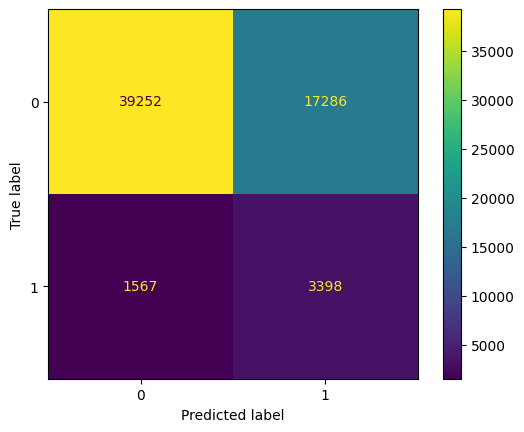

In [304]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipeline_lgbm.classes_)
disp.plot()

### "Normal" settings

In [305]:
# --- MLflow Experiment Run ---
mlflow.set_experiment("Home Credit Baseline LightGBM") # To organize runs into experiments

with mlflow.start_run(run_name="Application_train_Bureau_Bureau_balance_lightGBM_normal_with_early_stopping"): #Utile plus tard pour fine tuning
    
    # --- Define Model & Pipeline ---
    pipeline_lgbm = make_pipeline(
        StandardScaler(), # Scaling is still generally recommended for LGBM, though less critical than for LogReg
        lgb.LGBMClassifier(
            
        # --- Core Speed Parameters ---
        n_estimators=2000,         # number of trees. Default is 100.
        learning_rate=0.05,       # learning rate of 0.05 with 2000 estimators is a common strategy coupled with early stopping qu'on va mettre dans le .fit()
        num_leaves=31,           # LOW number. Default is 31. Fewer leaves = simpler trees = faster. Increase later (e.g., 31, 63).
        max_depth=-1,            # Default (-1 means no limit). You could limit (e.g., 5 or 7) for speed, but num_leaves often controls complexity better.

        # --- Subsampling Parameters (can significantly speed up) ---
        subsample=0.9,           # Use only 70% of data rows per tree. Default is 1.0.
        colsample_bytree=0.9,    # Use only 70% of features per tree. Default is 1.0.
        # subsample_freq=1,      # How often to subsample (every 1 iteration here). Default is 0 (disabled), set to >0 to enable row subsampling.

        # --- Regularization parameters help prevent overfitting

        reg_alpha=0.1,            # Added small L1 regularization
        reg_lambda=0.1,           # Added small L2 regularization

        # --- Other Important Parameters ---
        class_weight='balanced', # Keep this for imbalance.
        random_state=42,
        n_jobs=-1,               # Use all available CPU cores. Default.
        # objective='binary',    # Default for classifier, no need to set usually.
        # metric='auc',          # Default is usually logloss/binary_logloss. AUC is good for evaluation.
        )
    )
    
    nan_handling_strategy = "LGBM_internal" # On laisse LightGBM gérer les NaNs


    # --- Log Parameters ---
    mlflow.log_param("model_type", "LightGBM") # Updated
    mlflow.log_param("features", "App+Bureau+BB_Aggregated") # Updated
    mlflow.log_param("imputation_merge_nans", "ZeroFill") # Example for merge NaNs
    mlflow.log_param("nan_handling_model", nan_handling_strategy) # Log NaN strategy
    mlflow.log_param("scaling", "StandardScaler")
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_val_split", 0.2)
    
    # --- key LGBM params ---
    mlflow.log_param("lgbm_n_estimators", 2000) 
    mlflow.log_param("lgbm_learning_rate", 0.05)              
    mlflow.log_param("lgbm_num_leaves", 31)       
    mlflow.log_param("lgbm_max_depth", -1) 
    mlflow.log_param("lgbm_subsample", 0.9)
    mlflow.log_param("lgbm_colsample_bytree", 0.9)  
    mlflow.log_param("lgbm_n_jobs", -1)
    mlflow.log_param("reg_alpha", 0.1)
    mlflow.log_param("reg_lambda", 0.1) 

    # --- Definition des callbacks ---

    stopping_rounds=50
    verbose=100
    early_stopping_metric = 'auc'

    #liste de callbacks qu'on va mettre dans le fit pour dire quels callbacks notre modèle doit utiliser durant l'entrainement
    callbacks_list = [lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=verbose)] # Stop if val AUC doesn't improve for 50 rounds, print every 100 rounds

    # --- IMPORTANT --- Meme si LightGBM utilise par défaut binary logloss ici on va utiliser ROC AUC car :
    # Log loss can sometimes be sensitive to outliers or poorly calibrated probabilities. It might not perfectly align with the final business metric you care about (which might be AUC, F1, precision, recall, etc.).
    # ROC AUX a aussi ses désavantages : Cons: AUC is threshold-independent, so stopping based on it doesn't guarantee optimal performance at the specific threshold you might choose later (though it's usually highly correlated).
    # Mais globalement AUC is a common and robust metric for evaluating binary classifier performance, especially with imbalanced datasets. It measures the model's ability to rank positive instances higher than negative ones, irrespective of the specific threshold. 
    # Stopping based on validation AUC ensures you stop when this ranking ability stops improving. Often aligns better with overall classification quality goals than log loss.
    # Le seul vrai avantage d'utiliser la même métrique que celle que le modèle regarde pendant son entrainement ici la log loss c'est que :
    # Directly related to the function the model is optimizing. Stopping based on validation log loss ensures you stop when the model's probabilistic predictions stop improving on unseen data according to that specific loss function.

    # Define the validation set for early stopping
    eval_set = [(X_val, y_val)]

    # --- Train model ---
    pipeline_lgbm.fit(
        X_train, y_train,
        # Pass eval_set for early stopping
        lgbmclassifier__eval_set=eval_set, #eval_set est une liste contenant des validation sets (as tuples of (X_val, y_val)) pour controler/monitor performances. Early stopping uses this to decide when to stop.
        lgbmclassifier__eval_metric='auc',  # <--- Specify AUC here
        # Use callbacks argument for early stopping
        lgbmclassifier__callbacks=callbacks_list
        )
    
    # --- Log Callbacks parameters

    mlflow.log_param("early_stopping_enabled", True)
    mlflow.log_param("early_stopping_rounds", stopping_rounds)
    mlflow.log_param("early_stopping_metric", early_stopping_metric)

    # --- After fitting ---
    
    #  --- IMPORTANT ---best_iteration as a metric tells us how many trees were actually used in the final model selected by early stopping
    fitted_lgbm = pipeline_lgbm.named_steps['lgbmclassifier']
    if fitted_lgbm.best_iteration_:
        mlflow.log_metric("best_iteration", fitted_lgbm.best_iteration_)
        # Optional: Update the n_estimators param if you want to reflect the stopped value
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.best_iteration_)
    else:
        # Log if early stopping didn't trigger (ran full n_estimators)
        mlflow.log_metric("best_iteration", fitted_lgbm.n_estimators)
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.n_estimators)

    # --- Predict & Calcul des métriques ---
    y_pred = pipeline_lgbm.predict(X_val)
    y_proba = pipeline_lgbm.predict_proba(X_val)[:, 1] # Probabilities for class 1

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred) # Default F1 for class 1
    roc_auc = roc_auc_score(y_val, y_proba)
    report = classification_report(y_val, y_pred, output_dict=True) # Get report as dict

    # --- Log métriques ---
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_f1_score", f1)
    mlflow.log_metric("val_roc_auc", roc_auc)
    # metrics from classification report
    mlflow.log_metric("val_precision_0", report['0']['precision'])
    mlflow.log_metric("val_recall_0", report['0']['recall'])
    mlflow.log_metric("val_f1_0", report['0']['f1-score'])
    mlflow.log_metric("val_precision_1", report['1']['precision'])
    mlflow.log_metric("val_recall_1", report['1']['recall'])
    mlflow.log_metric("val_f1_1", report['1']['f1-score'])

    # --- Input Example ---
    input_example = X_train.head(5) #Input example = small sample of valid input data (like one or a few rows from X_train or X_val DataFrame) that demonstrates the expected format.
    #Sert a si jamais on souhaite se resservir du modèle à ce qu'il vérifie que les données d'entrée aient le format attendu ici DataFrame Pandas

    # --- Log Model ---
    mlflow.lightgbm.log_model(
        lgb_model=pipeline_lgbm.named_steps['lgbmclassifier'], # Log the LGBM step
        artifact_path="lightgbm_model",
        input_example=X_train.head(5) # Provide example
        )


    # --- Log Artifacts (Example: Confusion Matrix) ---
    cm = confusion_matrix(y_val, y_pred, labels=pipeline_lgbm.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_lgbm.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix LGBM (Validation Set)")
    cm_path = "confusion_matrix_lgbm_val.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    plt.close() # Close the plot to prevent display in notebook output if desired

    print(f"Run ID: {mlflow.active_run().info.run_id} logged.")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print(classification_report(y_val, y_pred))

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15650
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 275
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	valid_0's auc: 0.667455	valid_0's binary_logloss: 0.413519


c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing

Run ID: d50bf75bd97d416f9d7c371b2adcfb70 logged.
Validation ROC-AUC: 0.7483
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56538
           1       0.16      0.68      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.90      0.69      0.76     61503



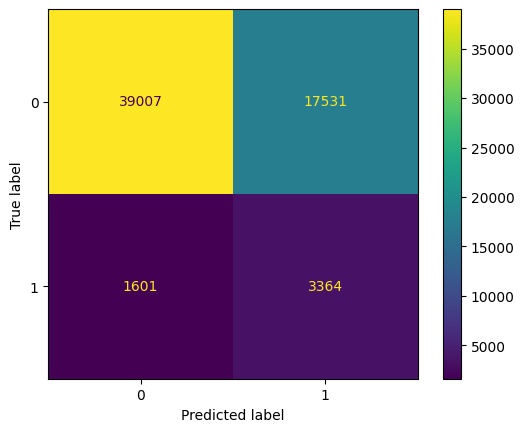

In [306]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipeline_lgbm.classes_)
disp.plot()

### Early stopping kicking in early

In [307]:
fitted_lgbm.best_iteration_

48

Donc malgré le fait qu'on ait mis n_estimators = 2000 on est arrivé qu'a 48 ce qui explique qu'on a peu d'amélioration entre les deux runs

## Taking early stopping kicking in very early into account

on va juste tenter de réduire un peu le learning rate et sinon on va tenter de faire plus de feature engineering

In [308]:
# --- MLflow Experiment Run ---
mlflow.set_experiment("Home Credit Baseline LightGBM") # To organize runs into experiments

with mlflow.start_run(run_name="Application_train_Bureau_Bureau_balance_lightGBM_normal_with_early_stopping_lower_learning_rate"): #Utile plus tard pour fine tuning
    
    # --- Define Model & Pipeline ---
    pipeline_lgbm = make_pipeline(
        StandardScaler(), # Scaling is still generally recommended for LGBM, though less critical than for LogReg
        lgb.LGBMClassifier(
            
        # --- Core Speed Parameters ---
        n_estimators=2000,         # number of trees. Default is 100.
        learning_rate=0.005,       # learning rate of 0.05 with 2000 estimators is a common strategy coupled with early stopping qu'on va mettre dans le .fit()
        num_leaves=31,           # LOW number. Default is 31. Fewer leaves = simpler trees = faster. Increase later (e.g., 31, 63).
        max_depth=-1,            # Default (-1 means no limit). You could limit (e.g., 5 or 7) for speed, but num_leaves often controls complexity better.

        # --- Subsampling Parameters (can significantly speed up) ---
        subsample=0.9,           # Use only 70% of data rows per tree. Default is 1.0.
        colsample_bytree=0.9,    # Use only 70% of features per tree. Default is 1.0.
        # subsample_freq=1,      # How often to subsample (every 1 iteration here). Default is 0 (disabled), set to >0 to enable row subsampling.

        # --- Regularization parameters help prevent overfitting

        reg_alpha=0.1,            # Added small L1 regularization
        reg_lambda=0.1,           # Added small L2 regularization

        # --- Other Important Parameters ---
        class_weight='balanced', # Keep this for imbalance.
        random_state=42,
        n_jobs=-1,               # Use all available CPU cores. Default.
        # objective='binary',    # Default for classifier, no need to set usually.
        # metric='auc',          # Default is usually logloss/binary_logloss. AUC is good for evaluation.
        )
    )
    
    nan_handling_strategy = "LGBM_internal" # On laisse LightGBM gérer les NaNs


    # --- Log Parameters ---
    mlflow.log_param("model_type", "LightGBM") # Updated
    mlflow.log_param("features", "App+Bureau+BB_Aggregated") # Updated
    mlflow.log_param("imputation_merge_nans", "ZeroFill") # Example for merge NaNs
    mlflow.log_param("nan_handling_model", nan_handling_strategy) # Log NaN strategy
    mlflow.log_param("scaling", "StandardScaler")
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_val_split", 0.2)
    
    # --- key LGBM params ---
    mlflow.log_param("lgbm_n_estimators", 2000) 
    mlflow.log_param("lgbm_learning_rate", 0.005)              
    mlflow.log_param("lgbm_num_leaves", 31)       
    mlflow.log_param("lgbm_max_depth", -1) 
    mlflow.log_param("lgbm_subsample", 0.9)
    mlflow.log_param("lgbm_colsample_bytree", 0.9)  
    mlflow.log_param("lgbm_n_jobs", -1)
    mlflow.log_param("reg_alpha", 0.1)
    mlflow.log_param("reg_lambda", 0.1) 

    # --- Definition des callbacks ---

    stopping_rounds=200
    verbose=100
    early_stopping_metric = 'auc'

    #liste de callbacks qu'on va mettre dans le fit pour dire quels callbacks notre modèle doit utiliser durant l'entrainement
    callbacks_list = [lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=verbose)] # Stop if val AUC doesn't improve for 50 rounds, print every 100 rounds

    # --- IMPORTANT --- Meme si LightGBM utilise par défaut binary logloss ici on va utiliser ROC AUC car :
    # Log loss can sometimes be sensitive to outliers or poorly calibrated probabilities. It might not perfectly align with the final business metric you care about (which might be AUC, F1, precision, recall, etc.).
    # ROC AUX a aussi ses désavantages : Cons: AUC is threshold-independent, so stopping based on it doesn't guarantee optimal performance at the specific threshold you might choose later (though it's usually highly correlated).
    # Mais globalement AUC is a common and robust metric for evaluating binary classifier performance, especially with imbalanced datasets. It measures the model's ability to rank positive instances higher than negative ones, irrespective of the specific threshold. 
    # Stopping based on validation AUC ensures you stop when this ranking ability stops improving. Often aligns better with overall classification quality goals than log loss.
    # Le seul vrai avantage d'utiliser la même métrique que celle que le modèle regarde pendant son entrainement ici la log loss c'est que :
    # Directly related to the function the model is optimizing. Stopping based on validation log loss ensures you stop when the model's probabilistic predictions stop improving on unseen data according to that specific loss function.

    # Define the validation set for early stopping
    eval_set = [(X_val, y_val)]

    # --- Train model ---
    pipeline_lgbm.fit(
        X_train, y_train,
        # Pass eval_set for early stopping
        lgbmclassifier__eval_set=eval_set, #eval_set est une liste contenant des validation sets (as tuples of (X_val, y_val)) pour controler/monitor performances. Early stopping uses this to decide when to stop.
        lgbmclassifier__eval_metric='auc',  # <--- Specify AUC here
        # Use callbacks argument for early stopping
        lgbmclassifier__callbacks=callbacks_list
        )
    
    # --- Log Callbacks parameters

    mlflow.log_param("early_stopping_enabled", True)
    mlflow.log_param("early_stopping_rounds", stopping_rounds)
    mlflow.log_param("early_stopping_metric", early_stopping_metric)

    # --- After fitting ---
    
    #  --- IMPORTANT ---best_iteration as a metric tells us how many trees were actually used in the final model selected by early stopping
    fitted_lgbm = pipeline_lgbm.named_steps['lgbmclassifier']
    if fitted_lgbm.best_iteration_:
        mlflow.log_metric("best_iteration", fitted_lgbm.best_iteration_)
        # Optional: Update the n_estimators param if you want to reflect the stopped value
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.best_iteration_)
    else:
        # Log if early stopping didn't trigger (ran full n_estimators)
        mlflow.log_metric("best_iteration", fitted_lgbm.n_estimators)
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.n_estimators)

    # --- Predict & Calcul des métriques ---
    y_pred = pipeline_lgbm.predict(X_val)
    y_proba = pipeline_lgbm.predict_proba(X_val)[:, 1] # Probabilities for class 1

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred) # Default F1 for class 1
    roc_auc = roc_auc_score(y_val, y_proba)
    report = classification_report(y_val, y_pred, output_dict=True) # Get report as dict

    # --- Log métriques ---
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_f1_score", f1)
    mlflow.log_metric("val_roc_auc", roc_auc)
    # metrics from classification report
    mlflow.log_metric("val_precision_0", report['0']['precision'])
    mlflow.log_metric("val_recall_0", report['0']['recall'])
    mlflow.log_metric("val_f1_0", report['0']['f1-score'])
    mlflow.log_metric("val_precision_1", report['1']['precision'])
    mlflow.log_metric("val_recall_1", report['1']['recall'])
    mlflow.log_metric("val_f1_1", report['1']['f1-score'])

    # --- Input Example ---
    input_example = X_train.head(5) #Input example = small sample of valid input data (like one or a few rows from X_train or X_val DataFrame) that demonstrates the expected format.
    #Sert a si jamais on souhaite se resservir du modèle à ce qu'il vérifie que les données d'entrée aient le format attendu ici DataFrame Pandas

    # --- Log Model ---
    mlflow.lightgbm.log_model(
        lgb_model=pipeline_lgbm.named_steps['lgbmclassifier'], # Log the LGBM step
        artifact_path="lightgbm_model",
        input_example=X_train.head(5) # Provide example
        )


    # --- Log Artifacts (Example: Confusion Matrix) ---
    cm = confusion_matrix(y_val, y_pred, labels=pipeline_lgbm.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_lgbm.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix LGBM (Validation Set)")
    cm_path = "confusion_matrix_lgbm_val.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    plt.close() # Close the plot to prevent display in notebook output if desired

    print(f"Run ID: {mlflow.active_run().info.run_id} logged.")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print(classification_report(y_val, y_pred))

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15650
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 275
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[526]	valid_0's auc: 0.66974	valid_0's binary_logloss: 0.410002


c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing

Run ID: 201f52b33b494460a5fb2a6e51995c90 logged.
Validation ROC-AUC: 0.7500
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56538
           1       0.16      0.68      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.69      0.53     61503
weighted avg       0.90      0.69      0.76     61503



In [309]:
fitted_lgbm.best_iteration_

526

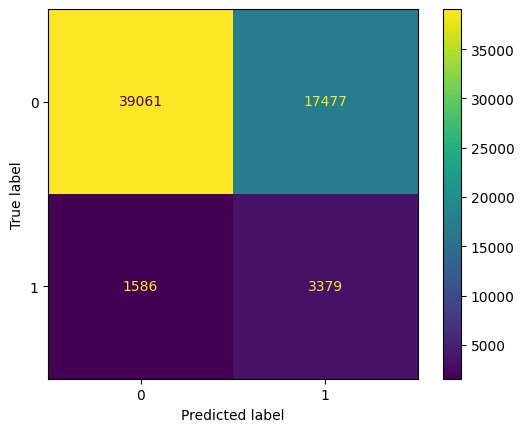

In [310]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipeline_lgbm.classes_)
disp.plot()

## Run avec dictionnaire de poids FN 5 fois plus cher que FP

In [311]:
# --- MLflow Experiment Run ---
mlflow.set_experiment("Home Credit Baseline LightGBM") # To organize runs into experiments

with mlflow.start_run(run_name="Application_train_Bureau_Bureau_weight_dict_5_times_lightGBM_normal_with_early_stopping_lower_learning_rate"): #Utile plus tard pour fine tuning
    
    # --- Dictionnaire de poids pour contrer déséquilibre des classes
    class_weights_dict = {0: 1, 1: 5}

    # --- Define Model & Pipeline ---
    pipeline_lgbm = make_pipeline(
        StandardScaler(), # Scaling is still generally recommended for LGBM, though less critical than for LogReg
        lgb.LGBMClassifier(
            
        # --- Core Speed Parameters ---
        n_estimators=2000,         # number of trees. Default is 100.
        learning_rate=0.005,       # learning rate of 0.05 with 2000 estimators is a common strategy coupled with early stopping qu'on va mettre dans le .fit()
        num_leaves=31,           # LOW number. Default is 31. Fewer leaves = simpler trees = faster. Increase later (e.g., 31, 63).
        max_depth=-1,            # Default (-1 means no limit). You could limit (e.g., 5 or 7) for speed, but num_leaves often controls complexity better.

        # --- Subsampling Parameters (can significantly speed up) ---
        subsample=0.9,           # Use only 70% of data rows per tree. Default is 1.0.
        colsample_bytree=0.9,    # Use only 70% of features per tree. Default is 1.0.
        # subsample_freq=1,      # How often to subsample (every 1 iteration here). Default is 0 (disabled), set to >0 to enable row subsampling.

        # --- Regularization parameters help prevent overfitting

        reg_alpha=0.1,            # Added small L1 regularization
        reg_lambda=0.1,           # Added small L2 regularization

        # --- Other Important Parameters ---
        class_weight=class_weights_dict, # Keep this for imbalance.
        random_state=42,
        n_jobs=-1,               # Use all available CPU cores. Default.
        # objective='binary',    # Default for classifier, no need to set usually.
        # metric='auc',          # Default is usually logloss/binary_logloss. AUC is good for evaluation.
        )
    )
    
    nan_handling_strategy = "LGBM_internal" # On laisse LightGBM gérer les NaNs


    # --- Log Parameters ---
    mlflow.log_param("model_type", "LightGBM") # Updated
    mlflow.log_param("features", "App+Bureau+BB_Aggregated") # Updated
    mlflow.log_param("imputation_merge_nans", "ZeroFill") # Example for merge NaNs
    mlflow.log_param("nan_handling_model", nan_handling_strategy) # Log NaN strategy
    mlflow.log_param("scaling", "StandardScaler")
    mlflow.log_param("class_weight", str(class_weights_dict))
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_val_split", 0.2)
    
    # --- key LGBM params ---
    mlflow.log_param("lgbm_n_estimators", 2000) 
    mlflow.log_param("lgbm_learning_rate", 0.005)              
    mlflow.log_param("lgbm_num_leaves", 31)       
    mlflow.log_param("lgbm_max_depth", -1) 
    mlflow.log_param("lgbm_subsample", 0.9)
    mlflow.log_param("lgbm_colsample_bytree", 0.9)  
    mlflow.log_param("lgbm_n_jobs", -1)
    mlflow.log_param("reg_alpha", 0.1)
    mlflow.log_param("reg_lambda", 0.1) 

    # --- Definition des callbacks ---

    stopping_rounds=200
    verbose=100
    early_stopping_metric = 'auc'

    #liste de callbacks qu'on va mettre dans le fit pour dire quels callbacks notre modèle doit utiliser durant l'entrainement
    callbacks_list = [lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=verbose)] # Stop if val AUC doesn't improve for 50 rounds, print every 100 rounds

    # --- IMPORTANT --- Meme si LightGBM utilise par défaut binary logloss ici on va utiliser ROC AUC car :
    # Log loss can sometimes be sensitive to outliers or poorly calibrated probabilities. It might not perfectly align with the final business metric you care about (which might be AUC, F1, precision, recall, etc.).
    # ROC AUX a aussi ses désavantages : Cons: AUC is threshold-independent, so stopping based on it doesn't guarantee optimal performance at the specific threshold you might choose later (though it's usually highly correlated).
    # Mais globalement AUC is a common and robust metric for evaluating binary classifier performance, especially with imbalanced datasets. It measures the model's ability to rank positive instances higher than negative ones, irrespective of the specific threshold. 
    # Stopping based on validation AUC ensures you stop when this ranking ability stops improving. Often aligns better with overall classification quality goals than log loss.
    # Le seul vrai avantage d'utiliser la même métrique que celle que le modèle regarde pendant son entrainement ici la log loss c'est que :
    # Directly related to the function the model is optimizing. Stopping based on validation log loss ensures you stop when the model's probabilistic predictions stop improving on unseen data according to that specific loss function.

    # Define the validation set for early stopping
    eval_set = [(X_val, y_val)]

    # --- Train model ---
    pipeline_lgbm.fit(
        X_train, y_train,
        # Pass eval_set for early stopping
        lgbmclassifier__eval_set=eval_set, #eval_set est une liste contenant des validation sets (as tuples of (X_val, y_val)) pour controler/monitor performances. Early stopping uses this to decide when to stop.
        lgbmclassifier__eval_metric='auc',  # <--- Specify AUC here
        # Use callbacks argument for early stopping
        lgbmclassifier__callbacks=callbacks_list
        )
    
    # --- Log Callbacks parameters

    mlflow.log_param("early_stopping_enabled", True)
    mlflow.log_param("early_stopping_rounds", stopping_rounds)
    mlflow.log_param("early_stopping_metric", early_stopping_metric)

    # --- After fitting ---
    
    #  --- IMPORTANT ---best_iteration as a metric tells us how many trees were actually used in the final model selected by early stopping
    fitted_lgbm = pipeline_lgbm.named_steps['lgbmclassifier']
    if fitted_lgbm.best_iteration_:
        mlflow.log_metric("best_iteration", fitted_lgbm.best_iteration_)
        # Optional: Update the n_estimators param if you want to reflect the stopped value
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.best_iteration_)
    else:
        # Log if early stopping didn't trigger (ran full n_estimators)
        mlflow.log_metric("best_iteration", fitted_lgbm.n_estimators)
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.n_estimators)

    # --- Predict & Calcul des métriques ---
    y_pred = pipeline_lgbm.predict(X_val)
    y_proba = pipeline_lgbm.predict_proba(X_val)[:, 1] # Probabilities for class 1

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred) # Default F1 for class 1
    roc_auc = roc_auc_score(y_val, y_proba)
    report = classification_report(y_val, y_pred, output_dict=True) # Get report as dict

    # --- Log métriques ---
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_f1_score", f1)
    mlflow.log_metric("val_roc_auc", roc_auc)
    # metrics from classification report
    mlflow.log_metric("val_precision_0", report['0']['precision'])
    mlflow.log_metric("val_recall_0", report['0']['recall'])
    mlflow.log_metric("val_f1_0", report['0']['f1-score'])
    mlflow.log_metric("val_precision_1", report['1']['precision'])
    mlflow.log_metric("val_recall_1", report['1']['recall'])
    mlflow.log_metric("val_f1_1", report['1']['f1-score'])

    # --- Input Example ---
    input_example = X_train.head(5) #Input example = small sample of valid input data (like one or a few rows from X_train or X_val DataFrame) that demonstrates the expected format.
    #Sert a si jamais on souhaite se resservir du modèle à ce qu'il vérifie que les données d'entrée aient le format attendu ici DataFrame Pandas

    # --- Log Model ---
    mlflow.lightgbm.log_model(
        lgb_model=pipeline_lgbm.named_steps['lgbmclassifier'], # Log the LGBM step
        artifact_path="lightgbm_model",
        input_example=X_train.head(5) # Provide example
        )


    # --- Log Artifacts (Example: Confusion Matrix) ---
    cm = confusion_matrix(y_val, y_pred, labels=pipeline_lgbm.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_lgbm.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix LGBM (Validation Set)")
    cm_path = "confusion_matrix_lgbm_val.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    plt.close() # Close the plot to prevent display in notebook output if desired

    print(f"Run ID: {mlflow.active_run().info.run_id} logged.")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print(classification_report(y_val, y_pred))

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15650
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 275
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.305118 -> initscore=-0.823044
[LightGBM] [Info] Start training from score -0.823044
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[666]	valid_0's auc: 0.677136	valid_0's binary_logloss: 0.296409


c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing

Run ID: 98c53f5d1b764c5589b397147443794c logged.
Validation ROC-AUC: 0.7541
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     56538
           1       0.28      0.33      0.30      4965

    accuracy                           0.88     61503
   macro avg       0.61      0.63      0.62     61503
weighted avg       0.89      0.88      0.88     61503



In [312]:
fitted_lgbm.best_iteration_

666

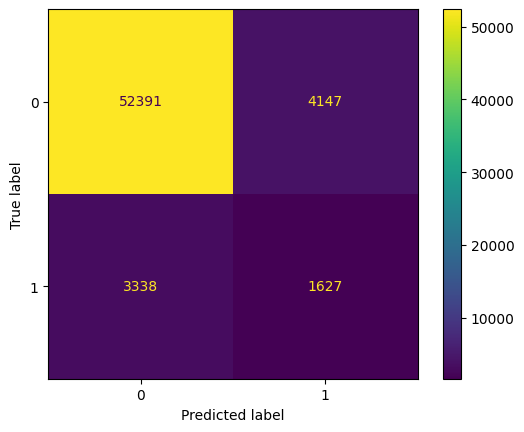

In [313]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipeline_lgbm.classes_)
disp.plot()

## Run avec dictionnaire de poids FN 10 fois plus cher que FP

In [314]:
# --- MLflow Experiment Run ---
mlflow.set_experiment("Home Credit Baseline LightGBM") # To organize runs into experiments

with mlflow.start_run(run_name="Application_train_Bureau_Bureau_weight_dict_10_times_lightGBM_normal_with_early_stopping_lower_learning_rate"): #Utile plus tard pour fine tuning
    
    # --- Dictionnaire de poids pour contrer déséquilibre des classes
    class_weights_dict = {0: 1, 1: 10}

    # --- Define Model & Pipeline ---
    pipeline_lgbm = make_pipeline(
        StandardScaler(), # Scaling is still generally recommended for LGBM, though less critical than for LogReg
        lgb.LGBMClassifier(
            
        # --- Core Speed Parameters ---
        n_estimators=2000,         # number of trees. Default is 100.
        learning_rate=0.005,       # learning rate of 0.05 with 2000 estimators is a common strategy coupled with early stopping qu'on va mettre dans le .fit()
        num_leaves=31,           # LOW number. Default is 31. Fewer leaves = simpler trees = faster. Increase later (e.g., 31, 63).
        max_depth=-1,            # Default (-1 means no limit). You could limit (e.g., 5 or 7) for speed, but num_leaves often controls complexity better.

        # --- Subsampling Parameters (can significantly speed up) ---
        subsample=0.9,           # Use only 70% of data rows per tree. Default is 1.0.
        colsample_bytree=0.9,    # Use only 70% of features per tree. Default is 1.0.
        # subsample_freq=1,      # How often to subsample (every 1 iteration here). Default is 0 (disabled), set to >0 to enable row subsampling.

        # --- Regularization parameters help prevent overfitting

        reg_alpha=0.1,            # Added small L1 regularization
        reg_lambda=0.1,           # Added small L2 regularization

        # --- Other Important Parameters ---
        class_weight=class_weights_dict, # Keep this for imbalance.
        random_state=42,
        n_jobs=-1,               # Use all available CPU cores. Default.
        # objective='binary',    # Default for classifier, no need to set usually.
        # metric='auc',          # Default is usually logloss/binary_logloss. AUC is good for evaluation.
        )
    )
    
    nan_handling_strategy = "LGBM_internal" # On laisse LightGBM gérer les NaNs


    # --- Log Parameters ---
    mlflow.log_param("model_type", "LightGBM") # Updated
    mlflow.log_param("features", "App+Bureau+BB_Aggregated") # Updated
    mlflow.log_param("imputation_merge_nans", "ZeroFill") # Example for merge NaNs
    mlflow.log_param("nan_handling_model", nan_handling_strategy) # Log NaN strategy
    mlflow.log_param("scaling", "StandardScaler")
    mlflow.log_param("class_weight", str(class_weights_dict))
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_val_split", 0.2)
    
    # --- key LGBM params ---
    mlflow.log_param("lgbm_n_estimators", 2000) 
    mlflow.log_param("lgbm_learning_rate", 0.005)              
    mlflow.log_param("lgbm_num_leaves", 31)       
    mlflow.log_param("lgbm_max_depth", -1) 
    mlflow.log_param("lgbm_subsample", 0.9)
    mlflow.log_param("lgbm_colsample_bytree", 0.9)  
    mlflow.log_param("lgbm_n_jobs", -1)
    mlflow.log_param("reg_alpha", 0.1)
    mlflow.log_param("reg_lambda", 0.1) 

    # --- Definition des callbacks ---

    stopping_rounds=200
    verbose=100
    early_stopping_metric = 'auc'

    #liste de callbacks qu'on va mettre dans le fit pour dire quels callbacks notre modèle doit utiliser durant l'entrainement
    callbacks_list = [lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=verbose)] # Stop if val AUC doesn't improve for 50 rounds, print every 100 rounds

    # --- IMPORTANT --- Meme si LightGBM utilise par défaut binary logloss ici on va utiliser ROC AUC car :
    # Log loss can sometimes be sensitive to outliers or poorly calibrated probabilities. It might not perfectly align with the final business metric you care about (which might be AUC, F1, precision, recall, etc.).
    # ROC AUX a aussi ses désavantages : Cons: AUC is threshold-independent, so stopping based on it doesn't guarantee optimal performance at the specific threshold you might choose later (though it's usually highly correlated).
    # Mais globalement AUC is a common and robust metric for evaluating binary classifier performance, especially with imbalanced datasets. It measures the model's ability to rank positive instances higher than negative ones, irrespective of the specific threshold. 
    # Stopping based on validation AUC ensures you stop when this ranking ability stops improving. Often aligns better with overall classification quality goals than log loss.
    # Le seul vrai avantage d'utiliser la même métrique que celle que le modèle regarde pendant son entrainement ici la log loss c'est que :
    # Directly related to the function the model is optimizing. Stopping based on validation log loss ensures you stop when the model's probabilistic predictions stop improving on unseen data according to that specific loss function.

    # Define the validation set for early stopping
    eval_set = [(X_val, y_val)]

    # --- Train model ---
    pipeline_lgbm.fit(
        X_train, y_train,
        # Pass eval_set for early stopping
        lgbmclassifier__eval_set=eval_set, #eval_set est une liste contenant des validation sets (as tuples of (X_val, y_val)) pour controler/monitor performances. Early stopping uses this to decide when to stop.
        lgbmclassifier__eval_metric='auc',  # <--- Specify AUC here
        # Use callbacks argument for early stopping
        lgbmclassifier__callbacks=callbacks_list
        )
    
    # --- Log Callbacks parameters

    mlflow.log_param("early_stopping_enabled", True)
    mlflow.log_param("early_stopping_rounds", stopping_rounds)
    mlflow.log_param("early_stopping_metric", early_stopping_metric)

    # --- After fitting ---
    
    #  --- IMPORTANT ---best_iteration as a metric tells us how many trees were actually used in the final model selected by early stopping
    fitted_lgbm = pipeline_lgbm.named_steps['lgbmclassifier']
    if fitted_lgbm.best_iteration_:
        mlflow.log_metric("best_iteration", fitted_lgbm.best_iteration_)
        # Optional: Update the n_estimators param if you want to reflect the stopped value
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.best_iteration_)
    else:
        # Log if early stopping didn't trigger (ran full n_estimators)
        mlflow.log_metric("best_iteration", fitted_lgbm.n_estimators)
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.n_estimators)

    # --- Predict & Calcul des métriques ---
    y_pred = pipeline_lgbm.predict(X_val)
    y_proba = pipeline_lgbm.predict_proba(X_val)[:, 1] # Probabilities for class 1

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred) # Default F1 for class 1
    roc_auc = roc_auc_score(y_val, y_proba)
    report = classification_report(y_val, y_pred, output_dict=True) # Get report as dict

    # --- Log métriques ---
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_f1_score", f1)
    mlflow.log_metric("val_roc_auc", roc_auc)
    # metrics from classification report
    mlflow.log_metric("val_precision_0", report['0']['precision'])
    mlflow.log_metric("val_recall_0", report['0']['recall'])
    mlflow.log_metric("val_f1_0", report['0']['f1-score'])
    mlflow.log_metric("val_precision_1", report['1']['precision'])
    mlflow.log_metric("val_recall_1", report['1']['recall'])
    mlflow.log_metric("val_f1_1", report['1']['f1-score'])

    # --- Input Example ---
    input_example = X_train.head(5) #Input example = small sample of valid input data (like one or a few rows from X_train or X_val DataFrame) that demonstrates the expected format.
    #Sert a si jamais on souhaite se resservir du modèle à ce qu'il vérifie que les données d'entrée aient le format attendu ici DataFrame Pandas

    # --- Log Model ---
    mlflow.lightgbm.log_model(
        lgb_model=pipeline_lgbm.named_steps['lgbmclassifier'], # Log the LGBM step
        artifact_path="lightgbm_model",
        input_example=X_train.head(5) # Provide example
        )


    # --- Log Artifacts (Example: Confusion Matrix) ---
    cm = confusion_matrix(y_val, y_pred, labels=pipeline_lgbm.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_lgbm.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix LGBM (Validation Set)")
    cm_path = "confusion_matrix_lgbm_val.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    plt.close() # Close the plot to prevent display in notebook output if desired

    print(f"Run ID: {mlflow.active_run().info.run_id} logged.")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print(classification_report(y_val, y_pred))

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15650
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 275
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467571 -> initscore=-0.129897
[LightGBM] [Info] Start training from score -0.129897
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[540]	valid_0's auc: 0.671916	valid_0's binary_logloss: 0.381886


c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing

Run ID: dee4f01a79d244629eae4e9936d5d5f8 logged.
Validation ROC-AUC: 0.7505
              precision    recall  f1-score   support

           0       0.96      0.74      0.84     56538
           1       0.18      0.63      0.28      4965

    accuracy                           0.73     61503
   macro avg       0.57      0.69      0.56     61503
weighted avg       0.90      0.73      0.79     61503



In [315]:
fitted_lgbm.best_iteration_

540

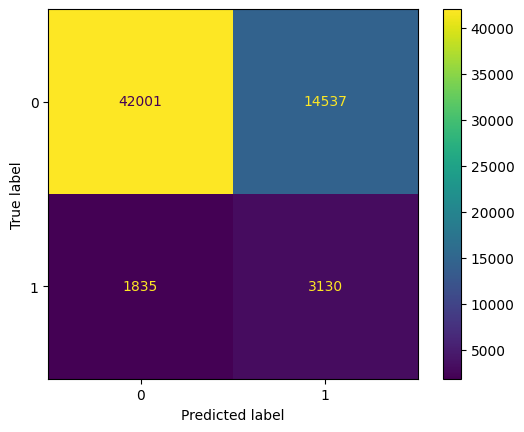

In [316]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipeline_lgbm.classes_)
disp.plot()

## Test de golmon x20

In [317]:
# --- MLflow Experiment Run ---
mlflow.set_experiment("Home Credit Baseline LightGBM") # To organize runs into experiments

with mlflow.start_run(run_name="Application_train_Bureau_Bureau_weight_dict_20_times_lightGBM_normal_with_early_stopping_lower_learning_rate"): #Utile plus tard pour fine tuning
    
    # --- Dictionnaire de poids pour contrer déséquilibre des classes
    class_weights_dict = {0: 1, 1: 20}

    # --- Define Model & Pipeline ---
    pipeline_lgbm = make_pipeline(
        StandardScaler(), # Scaling is still generally recommended for LGBM, though less critical than for LogReg
        lgb.LGBMClassifier(
            
        # --- Core Speed Parameters ---
        n_estimators=2000,         # number of trees. Default is 100.
        learning_rate=0.005,       # learning rate of 0.05 with 2000 estimators is a common strategy coupled with early stopping qu'on va mettre dans le .fit()
        num_leaves=31,           # LOW number. Default is 31. Fewer leaves = simpler trees = faster. Increase later (e.g., 31, 63).
        max_depth=-1,            # Default (-1 means no limit). You could limit (e.g., 5 or 7) for speed, but num_leaves often controls complexity better.

        # --- Subsampling Parameters (can significantly speed up) ---
        subsample=0.9,           # Use only 70% of data rows per tree. Default is 1.0.
        colsample_bytree=0.9,    # Use only 70% of features per tree. Default is 1.0.
        # subsample_freq=1,      # How often to subsample (every 1 iteration here). Default is 0 (disabled), set to >0 to enable row subsampling.

        # --- Regularization parameters help prevent overfitting

        reg_alpha=0.1,            # Added small L1 regularization
        reg_lambda=0.1,           # Added small L2 regularization

        # --- Other Important Parameters ---
        class_weight=class_weights_dict, # Keep this for imbalance.
        random_state=42,
        n_jobs=-1,               # Use all available CPU cores. Default.
        # objective='binary',    # Default for classifier, no need to set usually.
        # metric='auc',          # Default is usually logloss/binary_logloss. AUC is good for evaluation.
        )
    )
    
    nan_handling_strategy = "LGBM_internal" # On laisse LightGBM gérer les NaNs


    # --- Log Parameters ---
    mlflow.log_param("model_type", "LightGBM") # Updated
    mlflow.log_param("features", "App+Bureau+BB_Aggregated") # Updated
    mlflow.log_param("imputation_merge_nans", "ZeroFill") # Example for merge NaNs
    mlflow.log_param("nan_handling_model", nan_handling_strategy) # Log NaN strategy
    mlflow.log_param("scaling", "StandardScaler")
    mlflow.log_param("class_weight", str(class_weights_dict))
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_val_split", 0.2)
    
    # --- key LGBM params ---
    mlflow.log_param("lgbm_n_estimators", 2000) 
    mlflow.log_param("lgbm_learning_rate", 0.005)              
    mlflow.log_param("lgbm_num_leaves", 31)       
    mlflow.log_param("lgbm_max_depth", -1) 
    mlflow.log_param("lgbm_subsample", 0.9)
    mlflow.log_param("lgbm_colsample_bytree", 0.9)  
    mlflow.log_param("lgbm_n_jobs", -1)
    mlflow.log_param("reg_alpha", 0.1)
    mlflow.log_param("reg_lambda", 0.1) 

    # --- Definition des callbacks ---

    stopping_rounds=200
    verbose=100
    early_stopping_metric = 'auc'

    #liste de callbacks qu'on va mettre dans le fit pour dire quels callbacks notre modèle doit utiliser durant l'entrainement
    callbacks_list = [lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=verbose)] # Stop if val AUC doesn't improve for 50 rounds, print every 100 rounds

    # --- IMPORTANT --- Meme si LightGBM utilise par défaut binary logloss ici on va utiliser ROC AUC car :
    # Log loss can sometimes be sensitive to outliers or poorly calibrated probabilities. It might not perfectly align with the final business metric you care about (which might be AUC, F1, precision, recall, etc.).
    # ROC AUX a aussi ses désavantages : Cons: AUC is threshold-independent, so stopping based on it doesn't guarantee optimal performance at the specific threshold you might choose later (though it's usually highly correlated).
    # Mais globalement AUC is a common and robust metric for evaluating binary classifier performance, especially with imbalanced datasets. It measures the model's ability to rank positive instances higher than negative ones, irrespective of the specific threshold. 
    # Stopping based on validation AUC ensures you stop when this ranking ability stops improving. Often aligns better with overall classification quality goals than log loss.
    # Le seul vrai avantage d'utiliser la même métrique que celle que le modèle regarde pendant son entrainement ici la log loss c'est que :
    # Directly related to the function the model is optimizing. Stopping based on validation log loss ensures you stop when the model's probabilistic predictions stop improving on unseen data according to that specific loss function.

    # Define the validation set for early stopping
    eval_set = [(X_val, y_val)]

    # --- Train model ---
    pipeline_lgbm.fit(
        X_train, y_train,
        # Pass eval_set for early stopping
        lgbmclassifier__eval_set=eval_set, #eval_set est une liste contenant des validation sets (as tuples of (X_val, y_val)) pour controler/monitor performances. Early stopping uses this to decide when to stop.
        lgbmclassifier__eval_metric='auc',  # <--- Specify AUC here
        # Use callbacks argument for early stopping
        lgbmclassifier__callbacks=callbacks_list
        )
    
    # --- Log Callbacks parameters

    mlflow.log_param("early_stopping_enabled", True)
    mlflow.log_param("early_stopping_rounds", stopping_rounds)
    mlflow.log_param("early_stopping_metric", early_stopping_metric)

    # --- After fitting ---
    
    #  --- IMPORTANT ---best_iteration as a metric tells us how many trees were actually used in the final model selected by early stopping
    fitted_lgbm = pipeline_lgbm.named_steps['lgbmclassifier']
    if fitted_lgbm.best_iteration_:
        mlflow.log_metric("best_iteration", fitted_lgbm.best_iteration_)
        # Optional: Update the n_estimators param if you want to reflect the stopped value
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.best_iteration_)
    else:
        # Log if early stopping didn't trigger (ran full n_estimators)
        mlflow.log_metric("best_iteration", fitted_lgbm.n_estimators)
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.n_estimators)

    # --- Predict & Calcul des métriques ---
    y_pred = pipeline_lgbm.predict(X_val)
    y_proba = pipeline_lgbm.predict_proba(X_val)[:, 1] # Probabilities for class 1

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred) # Default F1 for class 1
    roc_auc = roc_auc_score(y_val, y_proba)
    report = classification_report(y_val, y_pred, output_dict=True) # Get report as dict

    # --- Log métriques ---
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_f1_score", f1)
    mlflow.log_metric("val_roc_auc", roc_auc)
    # metrics from classification report
    mlflow.log_metric("val_precision_0", report['0']['precision'])
    mlflow.log_metric("val_recall_0", report['0']['recall'])
    mlflow.log_metric("val_f1_0", report['0']['f1-score'])
    mlflow.log_metric("val_precision_1", report['1']['precision'])
    mlflow.log_metric("val_recall_1", report['1']['recall'])
    mlflow.log_metric("val_f1_1", report['1']['f1-score'])

    # --- Input Example ---
    input_example = X_train.head(5) #Input example = small sample of valid input data (like one or a few rows from X_train or X_val DataFrame) that demonstrates the expected format.
    #Sert a si jamais on souhaite se resservir du modèle à ce qu'il vérifie que les données d'entrée aient le format attendu ici DataFrame Pandas

    # --- Log Model ---
    mlflow.lightgbm.log_model(
        lgb_model=pipeline_lgbm.named_steps['lgbmclassifier'], # Log the LGBM step
        artifact_path="lightgbm_model",
        input_example=X_train.head(5) # Provide example
        )


    # --- Log Artifacts (Example: Confusion Matrix) ---
    cm = confusion_matrix(y_val, y_pred, labels=pipeline_lgbm.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_lgbm.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix LGBM (Validation Set)")
    cm_path = "confusion_matrix_lgbm_val.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    plt.close() # Close the plot to prevent display in notebook output if desired

    print(f"Run ID: {mlflow.active_run().info.run_id} logged.")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print(classification_report(y_val, y_pred))

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15650
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 275
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.637204 -> initscore=0.563250
[LightGBM] [Info] Start training from score 0.563250
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[440]	valid_0's auc: 0.671505	valid_0's binary_logloss: 0.556526


c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing

Run ID: a1dacdb5099c440cadbea00b951e36a0 logged.
Validation ROC-AUC: 0.7466
              precision    recall  f1-score   support

           0       0.97      0.42      0.58     56538
           1       0.12      0.87      0.21      4965

    accuracy                           0.45     61503
   macro avg       0.55      0.65      0.39     61503
weighted avg       0.91      0.45      0.55     61503



In [318]:
fitted_lgbm.best_iteration_

440

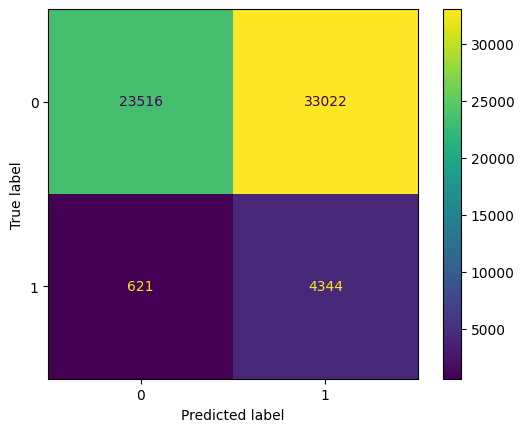

In [319]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipeline_lgbm.classes_)
disp.plot()

## Random Forest avec trois datasets

# Prochaines étapes à suivre

Etant donné que mêmes avec des paramètres "standard"/"adaptés" nos modèles n'arrivent pas à utiliser beaucoup d'estimateurs même avec un learning rate faible et une valeur élevée pour l'early stopping ce qui signifie sans doute qu'on est "bottlenecked" par les information qui sont données par nos features et que l'on devrait utiliser les autres datasets pour avoir plus de features/informations et eventuellement réaliser une feature engineering "automatique".

# Test feature tool

Feature enginneering "automatique" testé avec les deux jeux de donnéees en dessous avec features créees sur applciation train avec feature tools et les features crées "à la main" sur bureau et bureau_balance --> pas de nette amélioration

# Suite du feature engineering

Dans cette partie la nous allons "étoffer" nos features en se servant de deux fonctions pour aggréger automatiquement données numériques et catégorielles

In [321]:
Liste_des_features_a_combiner = []

## Fonction pour aggrégation valeurs numériques

In [322]:
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

## Fonction pour aggréger variables catégorielles

In [323]:
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

## Features bureau

In [324]:
num_features_with_function_bureau = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
num_features_with_function_bureau

SK_ID_CURR  bureau_DAYS_CREDIT_count  bureau_DAYS_CREDIT_mean   
0           100001                         7              -735.000000  \
1           100002                         8              -874.000000   
2           100003                         4             -1400.750000   
3           100004                         2              -867.000000   
4           100005                         3              -190.666667   
...            ...                       ...                      ...   
305806      456249                        13             -1667.076923   
305807      456250                         3              -862.000000   
305808      456253                         4              -867.500000   
305809      456254                         1             -1104.000000   
305810      456255                        11             -1089.454545   

        bureau_DAYS_CREDIT_max  bureau_DAYS_CREDIT_min   
0                          -49                   -1572  \
1                         -103                   -1437   
2                         -606                   -2586   
3                         -408                   -1326   
4                          -62                    -373   
...                        ...                     ...   
305806                    -483                   -2713   
305807                    -760                   -1002   
305808                    -713                    -919   
305809                   -1104                   -1104   
305810                    -363                   -2337   

        bureau_DAYS_CREDIT_sum  bureau_CREDIT_DAY_OVERDUE_count   
0                        -5145                                7  \
1                        -6992                                8   
2                        -5603                                4   
3                        -1734                                2   
4                         -572                                3   
...                        ...                              ...   
305806                  -21672                               13   
305807                   -2586                                3   
305808                   -3470                                4   
305809                   -1104                                1   
305810                  -11984                               11   

        bureau_CREDIT_DAY_OVERDUE_mean  bureau_CREDIT_DAY_OVERDUE_max   
0                                  0.0                              0  \
1                                  0.0                              0   
2                                  0.0                              0   
3                                  0.0                              0   
4                                  0.0                              0   
...                                ...                            ...   
305806                             0.0                              0   
305807                             0.0                              0   
305808                             0.0                              0   
305809                             0.0                              0   
305810                             0.0                              0   

        bureau_CREDIT_DAY_OVERDUE_min  bureau_CREDIT_DAY_OVERDUE_sum   
0                                   0                              0  \
1                                   0                              0   
2                                   0                              0   
3                                   0                              0   
4                                   0                              0   
...                               ...                            ...   
305806                              0                              0   
305807                              0                              0   
305808                              0                              0   
305809                          

In [325]:
cat_features_with_function_bureau = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
cat_features_with_function_bureau.reset_index()

SK_ID_CURR  bureau_CREDIT_ACTIVE_Active_count   
0           100001                                  3  \
1           100002                                  2   
2           100003                                  1   
3           100004                                  0   
4           100005                                  2   
...            ...                                ...   
305806      456249                                  2   
305807      456250                                  2   
305808      456253                                  2   
305809      456254                                  0   
305810      456255                                  5   

        bureau_CREDIT_ACTIVE_Active_count_norm   
0                                     0.428571  \
1                                     0.250000   
2                                     0.250000   
3                                     0.000000   
4                                     0.666667   
...                                        ...   
305806                                0.153846   
305807                                0.666667   
305808                                0.500000   
305809                                0.000000   
305810                                0.454545   

        bureau_CREDIT_ACTIVE_Bad debt_count   
0                                         0  \
1                                         0   
2                                         0   
3                                         0   
4                                         0   
...                                     ...   
305806                                    0   
305807                                    0   
305808                                    0   
305809                                    0   
305810                                    0   

        bureau_CREDIT_ACTIVE_Bad debt_count_norm   
0                                            0.0  \
1                                            0.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   
...                                          ...   
305806                                       0.0   
305807                                       0.0   
305808                                       0.0   
305809                                       0.0   
305810                                       0.0   

        bureau_CREDIT_ACTIVE_Closed_count   
0                                       4  \
1                                       6   
2                                       3   
3                                       2   
4                                       1   
...                                   ...   
305806                                 11   
305807                                  1   
305808                                  2   
305809                                  1   
305810                                  6   

        bureau_CREDIT_ACTIVE_Closed_count_norm   
0                                     0.571429  \
1                                     0.750000   
2                                     0.750000   
3                                     1.000000   
4                                     0.333333   
...                                        ...   
305806                                0.846154   
305807                                0.333333   
305808                                0.500000   
305809                                1.000000   
305810                                0.545455   

        bureau_CREDIT_ACTIVE_Sold_count  bureau_CREDIT_ACTIVE_Sold_count_norm   
0                                     0                                   0.0  \
1                                     0                                   0.0   
2                                     0                                   0.0   
3                                     0                           

In [326]:
final_bureau_features

SK_ID_CURR  Active  Bad debt  Closed  Sold   
0           100001       3         0       4     0  \
1           100002       2         0       6     0   
2           100003       1         0       3     0   
3           100004       0         0       2     0   
4           100005       2         0       1     0   
...            ...     ...       ...     ...   ...   
305804      456249       2         0      11     0   
305805      456250       2         0       1     0   
305806      456253       2         0       2     0   
305807      456254       0         0       1     0   
305808      456255       5         0       6     0   

        CREDIT_TYPE_Another type of loan  CREDIT_TYPE_Car loan   
0                                      0                     0  \
1                                      0                     0   
2                                      0                     0   
3                                      0                     0   
4                                      0                     0   
...                                  ...                   ...   
305804                                 1                     0   
305805                                 0                     0   
305806                                 0                     0   
305807                                 0                     0   
305808                                 0                     0   

        CREDIT_TYPE_Cash loan (non-earmarked)  CREDIT_TYPE_Consumer credit   
0                                           0                            7  \
1                                           0                            4   
2                                           0                            2   
3                                           0                            2   
4                                           0                            2   
...                                       ...                          ...   
305804                                      0                            9   
305805                                      0                            2   
305806                                      0                            3   
305807                                      0                            1   
305808                                      0                            9   

        CREDIT_TYPE_Credit card  CREDIT_TYPE_Interbank credit   
0                             0                             0  \
1                             4                             0   
2                             2                             0   
3                             0                             0   
4                             1                             0   
...                         ...                           ...   
305804                        3                             0   
305805                        1                             0   
305806                        1                             0   
305807                        0                             0   
305808                        2                             0   

        CREDIT_TYPE_Loan for business development   
0                                               0  \
1                                               0   
2                                               0   
3                                               0   
4                                               0   
...                                           ...   
305804                                          0   
305805                                          0   
305806                                          0   
305807                                          0   
305808                                          0   

        CREDIT_TYPE_Loan for purchase of shares (margin lending)   
0                                                       0         \
1                                                       0          
2      

In [327]:
Liste_des_features_a_combiner.append('num_features_with_function_bureau')
Liste_des_features_a_combiner.append('cat_features_with_function_bureau')
Liste_des_features_a_combiner.append('final_bureau_features')

## Features bureau_balance

### Utilisation fonction

In [328]:
final_bureau_balance_features

SK_ID_BUREAU  MONTHS_LOAN_DURATION  STATUS_0  STATUS_1  STATUS_2   
0            5001709                    97         0         0         0  \
1            5001710                    83         0         0         0   
2            5001711                     4         0         0         0   
3            5001712                    19         0         0         0   
4            5001713                    22         0         0         0   
...              ...                   ...       ...       ...       ...   
817390       6842884                    48         0         0         0   
817391       6842885                    24         0         0         0   
817392       6842886                    33         0         0         0   
817393       6842887                    37         0         0         0   
817394       6842888                    62         0         0         0   

        STATUS_3  STATUS_4  STATUS_5  STATUS_C  STATUS_X  DPD_FLAG  1  2  3   
0              0         0         0         1         0         0  0  0  0  \
1              0         0         0         1         0         0  0  0  0   
2              0         0         0         0         1         0  0  0  0   
3              0         0         0         1         0         0  0  0  0   
4              0         0         0         0         1         0  0  0  0   
...          ...       ...       ...       ...       ...       ... .. .. ..   
817390         0         0         0         1         0         0  0  0  0   
817391         0         0         1         0         0        12  0  0  0   
817392         0         0         0         1         0         0  0  0  0   
817393         0         0         0         1         0         0  0  0  0   
817394         0         0         0         1         0         1  1  0  0   

        4   5  MEAN_DAYS_PAST_DUE  YEAR_LOAN_DURATION  LOAN_TYPE_Long Term   
0       0   0            0.000000                 8.0                    1  \
1       0   0            0.000000                 6.8                    1   
2       0   0            0.000000                 0.2                    0   
3       0   0            0.000000                 1.5                    0   
4       0   0            0.000000                 1.8                    0   
...    ..  ..                 ...                 ...                  ...   
817390  0   0            0.000000                 3.9                    0   
817391  0  12           60.000000                 1.9                    0   
817392  0   0            0.000000                 2.7                    0   
817393  0   0            0.000000                 3.0                    0   
817394  0   0            0.241935                 5.1                    1   

        LOAN_TYPE_Short Term  
0                          0  
1                          0  
2                          1  
3                          1  
4                          1  
...                      ...  
817390                     1  
817391                     1  
817392                     1  
817393                     1  
817394                     0  

[817395 rows x 20 columns]

In [329]:
num_features_with_function_bureau_balance = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
num_features_with_function_bureau_balance

SK_ID_BUREAU  bureau_balance_MONTHS_BALANCE_count   
0            5001709                                   97  \
1            5001710                                   83   
2            5001711                                    4   
3            5001712                                   19   
4            5001713                                   22   
...              ...                                  ...   
817390       6842884                                   48   
817391       6842885                                   24   
817392       6842886                                   33   
817393       6842887                                   37   
817394       6842888                                   62   

        bureau_balance_MONTHS_BALANCE_mean  bureau_balance_MONTHS_BALANCE_max   
0                                    -48.0                                  0  \
1                                    -41.0                                  0   
2                                     -1.5                                  0   
3                                     -9.0                                  0   
4                                    -10.5                                  0   
...                                    ...                                ...   
817390                               -23.5                                  0   
817391                               -11.5                                  0   
817392                               -16.0                                  0   
817393                               -18.0                                  0   
817394                               -30.5                                  0   

        bureau_balance_MONTHS_BALANCE_min  bureau_balance_MONTHS_BALANCE_sum  
0                                     -96                              -4656  
1                                     -82                              -3403  
2                                      -3                                 -6  
3                                     -18                               -171  
4                                     -21                               -231  
...                                   ...                                ...  
817390                                -47                              -1128  
817391                                -23                               -276  
817392                                -32                               -528  
817393                                -36                               -666  
817394                                -61                              -1891  

[817395 rows x 6 columns]

In [330]:
cat_features_with_function_bureau_balance = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
cat_features_with_function_bureau_balance.reset_index()

SK_ID_BUREAU  bureau_balance_STATUS_0_count   
0            5001709                              0  \
1            5001710                              5   
2            5001711                              3   
3            5001712                             10   
4            5001713                              0   
...              ...                            ...   
817390       6842884                              9   
817391       6842885                             12   
817392       6842886                              8   
817393       6842887                              6   
817394       6842888                              9   

        bureau_balance_STATUS_0_count_norm  bureau_balance_STATUS_1_count   
0                                 0.000000                              0  \
1                                 0.060241                              0   
2                                 0.750000                              0   
3                                 0.526316                              0   
4                                 0.000000                              0   
...                                    ...                            ...   
817390                            0.187500                              0   
817391                            0.500000                              0   
817392                            0.242424                              0   
817393                            0.162162                              0   
817394                            0.145161                              1   

        bureau_balance_STATUS_1_count_norm  bureau_balance_STATUS_2_count   
0                                 0.000000                              0  \
1                                 0.000000                              0   
2                                 0.000000                              0   
3                                 0.000000                              0   
4                                 0.000000                              0   
...                                    ...                            ...   
817390                            0.000000                              0   
817391                            0.000000                              0   
817392                            0.000000                              0   
817393                            0.000000                              0   
817394                            0.016129                              0   

        bureau_balance_STATUS_2_count_norm  bureau_balance_STATUS_3_count   
0                                      0.0                              0  \
1                                      0.0                              0   
2                                      0.0                              0   
3                                      0.0                              0   
4                                      0.0                              0   
...                                    ...                            ...   
817390                                 0.0                              0   
817391                                 0.0                              0   
817392                                 0.0                              0   
817393                                 0.0                              0   
817394                                 0.0                              0   

        bureau_balance_STATUS_3_count_norm  bureau_balance_STATUS_4_count   
0                                      0.0                              0  \
1                                      0.0                              0   
2                                      0.0                              0   
3                                      0.0                              0   
4                                      0.0                              0   
...                                    ...                            ...   
817390                           

### Aggrégation avec SK_ID_CURR des nouvelles features de bureau balance

#### Combinaison

In [331]:
pd.merge(num_features_with_function_bureau_balance, cat_features_with_function_bureau_balance, how='inner', on='SK_ID_BUREAU')

SK_ID_BUREAU  bureau_balance_MONTHS_BALANCE_count   
0            5001709                                   97  \
1            5001710                                   83   
2            5001711                                    4   
3            5001712                                   19   
4            5001713                                   22   
...              ...                                  ...   
817390       6842884                                   48   
817391       6842885                                   24   
817392       6842886                                   33   
817393       6842887                                   37   
817394       6842888                                   62   

        bureau_balance_MONTHS_BALANCE_mean  bureau_balance_MONTHS_BALANCE_max   
0                                    -48.0                                  0  \
1                                    -41.0                                  0   
2                                     -1.5                                  0   
3                                     -9.0                                  0   
4                                    -10.5                                  0   
...                                    ...                                ...   
817390                               -23.5                                  0   
817391                               -11.5                                  0   
817392                               -16.0                                  0   
817393                               -18.0                                  0   
817394                               -30.5                                  0   

        bureau_balance_MONTHS_BALANCE_min  bureau_balance_MONTHS_BALANCE_sum   
0                                     -96                              -4656  \
1                                     -82                              -3403   
2                                      -3                                 -6   
3                                     -18                               -171   
4                                     -21                               -231   
...                                   ...                                ...   
817390                                -47                              -1128   
817391                                -23                               -276   
817392                                -32                               -528   
817393                                -36                               -666   
817394                                -61                              -1891   

        bureau_balance_STATUS_0_count  bureau_balance_STATUS_0_count_norm   
0                                   0                            0.000000  \
1                                   5                            0.060241   
2                                   3                            0.750000   
3                                  10                            0.526316   
4                                   0                            0.000000   
...                               ...                                 ...   
817390                              9                            0.187500   
817391                             12                            0.500000   
817392                              8                            0.242424   
817393                              6                            0.162162   
817394                              9                            0.145161   

        bureau_balance_STATUS_1_count  bureau_balance_STATUS_1_count_norm   
0                                   0                            0.000000  \
1                                   0                            0.000000   
2                                   0                            0.000000   
3                                   0                            0.000000   
4                              

In [332]:
num_and_cat_features_with_function_bureau_balance = pd.merge(num_features_with_function_bureau_balance, cat_features_with_function_bureau_balance, how='inner', on='SK_ID_BUREAU')

#### Ajout de SK_ID_CURR

In [333]:
ids_for_agg = bureau[['SK_ID_CURR', 'SK_ID_BUREAU']]
pd.merge(left=ids_for_agg, right=num_and_cat_features_with_function_bureau_balance, how='inner').sort_values(by='SK_ID_BUREAU', ascending=True)

SK_ID_CURR  SK_ID_BUREAU  bureau_balance_MONTHS_BALANCE_count   
21895       162368       5001710                                   83  \
21896       162368       5001711                                    4   
21897       162368       5001712                                   19   
21898       150635       5001713                                   22   
21899       150635       5001714                                   15   
...            ...           ...                                  ...   
770952      387020       6842884                                   48   
770953      387020       6842885                                   24   
770954      387020       6842886                                   33   
770955      387020       6842887                                   37   
770956      387020       6842888                                   62   

        bureau_balance_MONTHS_BALANCE_mean  bureau_balance_MONTHS_BALANCE_max   
21895                                -41.0                                  0  \
21896                                 -1.5                                  0   
21897                                 -9.0                                  0   
21898                                -10.5                                  0   
21899                                 -7.0                                  0   
...                                    ...                                ...   
770952                               -23.5                                  0   
770953                               -11.5                                  0   
770954                               -16.0                                  0   
770955                               -18.0                                  0   
770956                               -30.5                                  0   

        bureau_balance_MONTHS_BALANCE_min  bureau_balance_MONTHS_BALANCE_sum   
21895                                 -82                              -3403  \
21896                                  -3                                 -6   
21897                                 -18                               -171   
21898                                 -21                               -231   
21899                                 -14                               -105   
...                                   ...                                ...   
770952                                -47                              -1128   
770953                                -23                               -276   
770954                                -32                               -528   
770955                                -36                               -666   
770956                                -61                              -1891   

        bureau_balance_STATUS_0_count  bureau_balance_STATUS_0_count_norm   
21895                               5                            0.060241  \
21896                               3                            0.750000   
21897                              10                            0.526316   
21898                               0                            0.000000   
21899                               0                            0.000000   
...                               ...                                 ...   
770952                              9                            0.187500   
770953                             12                            0.500000   
770954                              8                            0.242424   
770955                              6                            0.162162   
770956                              9                            0.145161   

        bureau_balance_STATUS_1_count  bureau_balance_STATUS_1_count_norm   
21895                               0                            0.000000  \
21896                               0                            0.000000   
21897                               0    

In [334]:
num_and_cat_features_with_function_bureau_balance_with_curr = pd.merge(left=ids_for_agg, right=num_and_cat_features_with_function_bureau_balance, how='inner').sort_values(by='SK_ID_BUREAU', ascending=True)
num_and_cat_features_with_function_bureau_balance_with_curr

SK_ID_CURR  SK_ID_BUREAU  bureau_balance_MONTHS_BALANCE_count   
21895       162368       5001710                                   83  \
21896       162368       5001711                                    4   
21897       162368       5001712                                   19   
21898       150635       5001713                                   22   
21899       150635       5001714                                   15   
...            ...           ...                                  ...   
770952      387020       6842884                                   48   
770953      387020       6842885                                   24   
770954      387020       6842886                                   33   
770955      387020       6842887                                   37   
770956      387020       6842888                                   62   

        bureau_balance_MONTHS_BALANCE_mean  bureau_balance_MONTHS_BALANCE_max   
21895                                -41.0                                  0  \
21896                                 -1.5                                  0   
21897                                 -9.0                                  0   
21898                                -10.5                                  0   
21899                                 -7.0                                  0   
...                                    ...                                ...   
770952                               -23.5                                  0   
770953                               -11.5                                  0   
770954                               -16.0                                  0   
770955                               -18.0                                  0   
770956                               -30.5                                  0   

        bureau_balance_MONTHS_BALANCE_min  bureau_balance_MONTHS_BALANCE_sum   
21895                                 -82                              -3403  \
21896                                  -3                                 -6   
21897                                 -18                               -171   
21898                                 -21                               -231   
21899                                 -14                               -105   
...                                   ...                                ...   
770952                                -47                              -1128   
770953                                -23                               -276   
770954                                -32                               -528   
770955                                -36                               -666   
770956                                -61                              -1891   

        bureau_balance_STATUS_0_count  bureau_balance_STATUS_0_count_norm   
21895                               5                            0.060241  \
21896                               3                            0.750000   
21897                              10                            0.526316   
21898                               0                            0.000000   
21899                               0                            0.000000   
...                               ...                                 ...   
770952                              9                            0.187500   
770953                             12                            0.500000   
770954                              8                            0.242424   
770955                              6                            0.162162   
770956                              9                            0.145161   

        bureau_balance_STATUS_1_count  bureau_balance_STATUS_1_count_norm   
21895                               0                            0.000000  \
21896                               0                            0.000000   
21897                               0    

In [335]:
final_bureau_balance_features_with_curr

SK_ID_CURR  SK_ID_BUREAU  MONTHS_LOAN_DURATION  STATUS_0  STATUS_1   
0           380361       5715448                    27         0         0  \
1           380361       5715449                    12         0         0   
2           380361       5715451                    26         0         0   
3           380361       5715452                    33         0         0   
4           380361       5715453                    38         0         0   
...            ...           ...                   ...       ...       ...   
774349      229054       5053730                    15         0         0   
774350      254479       5053734                    52         0         0   
774351      363575       5053740                    41         0         0   
774352      245498       5053747                    85         0         0   
774353      407724       5053758                    80         0         0   

        STATUS_2  STATUS_3  STATUS_4  STATUS_5  STATUS_C  STATUS_X  DPD_FLAG   
0              0         0         0         0         1         0         0  \
1              0         0         0         0         1         0         0   
2              0         0         0         0         1         0         0   
3              0         0         0         0         1         0         0   
4              0         0         0         0         1         0         0   
...          ...       ...       ...       ...       ...       ...       ...   
774349         0         0         0         0         1         0         0   
774350         0         0         0         0         1         0         0   
774351         0         0         0         0         1         0         0   
774352         0         0         0         0         1         0         0   
774353         0         0         0         0         0         1         0   

        1  2  3  4  5  MEAN_DAYS_PAST_DUE  YEAR_LOAN_DURATION   
0       0  0  0  0  0                 0.0                 2.2  \
1       0  0  0  0  0                 0.0                 0.9   
2       0  0  0  0  0                 0.0                 2.5   
3       0  0  0  0  0                 0.0                 2.7   
4       0  0  0  0  0                 0.0                 3.1   
...    .. .. .. .. ..                 ...                 ...   
774349  0  0  0  0  0                 0.0                 1.2   
774350  0  0  0  0  0                 0.0                 4.2   
774351  0  0  0  0  0                 0.0                 3.3   
774352  0  0  0  0  0                 0.0                 7.0   
774353  0  0  0  0  0                 0.0                 6.6   

        LOAN_TYPE_Long Term  LOAN_TYPE_Short Term  
0                         0                     1  
1                         0                     1  
2                         0                     1  
3                         0                     1  
4                         0                     1  
...                     ...                   ...  
774349                    0                     1  
774350                    0                     1  
774351                    0                     1  
774352                    1                     0  
774353                    1                     0  

[774354 rows x 21 columns]

#### Aggrégation avec SK_ID_CURR et fonction

In [336]:
num_and_cat_features_with_function_bureau_balance_with_curr_agg = agg_numeric(num_and_cat_features_with_function_bureau_balance_with_curr.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
num_and_cat_features_with_function_bureau_balance_with_curr_agg

SK_ID_CURR  client_bureau_balance_MONTHS_BALANCE_count_count   
0           100001                                                 7  \
1           100002                                                 8   
2           100005                                                 3   
3           100010                                                 2   
4           100013                                                 4   
...            ...                                               ...   
134537      456247                                                11   
134538      456250                                                 3   
134539      456253                                                 4   
134540      456254                                                 1   
134541      456255                                                11   

        client_bureau_balance_MONTHS_BALANCE_count_mean   
0                                             24.571429  \
1                                             13.750000   
2                                              7.000000   
3                                             36.000000   
4                                             57.500000   
...                                                 ...   
134537                                        29.090909   
134538                                        29.000000   
134539                                        29.250000   
134540                                        37.000000   
134541                                        26.636364   

        client_bureau_balance_MONTHS_BALANCE_count_max   
0                                                   52  \
1                                                   22   
2                                                   13   
3                                                   36   
4                                                   69   
...                                                ...   
134537                                              82   
134538                                              33   
134539                                              31   
134540                                              37   
134541                                              35   

        client_bureau_balance_MONTHS_BALANCE_count_min   
0                                                    2  \
1                                                    4   
2                                                    3   
3                                                   36   
4                                                   40   
...                                                ...   
134537                                              10   
134538                                              26   
134539                                              24   
134540                                              37   
134541                                              12   

        client_bureau_balance_MONTHS_BALANCE_count_sum   
0                                                  172  \
1                                                  110   
2                                                   21   
3                                                   72   
4                                                  230   
...                                                ...   
134537                                             320   
134538                                              87   
134539                                             117   
134540                                              37   
134541                                             293   

        client_bureau_balance_MONTHS_BALANCE_mean_count   
0                                                     7  \
1                                                     8   
2                                                     3   
3                                                     2   
4                                               

In [337]:
manual_final_bureau_balance_features_with_curr_agg = agg_numeric(final_bureau_balance_features_with_curr.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client_bureau_balance')
manual_final_bureau_balance_features_with_curr_agg

SK_ID_CURR  client_bureau_balance_MONTHS_LOAN_DURATION_count   
0           100001                                                 7  \
1           100002                                                 8   
2           100005                                                 3   
3           100010                                                 2   
4           100013                                                 4   
...            ...                                               ...   
134537      456247                                                11   
134538      456250                                                 3   
134539      456253                                                 4   
134540      456254                                                 1   
134541      456255                                                11   

        client_bureau_balance_MONTHS_LOAN_DURATION_mean   
0                                             24.571429  \
1                                             13.750000   
2                                              7.000000   
3                                             36.000000   
4                                             57.500000   
...                                                 ...   
134537                                        29.090909   
134538                                        29.000000   
134539                                        29.250000   
134540                                        37.000000   
134541                                        26.636364   

        client_bureau_balance_MONTHS_LOAN_DURATION_max   
0                                                   52  \
1                                                   22   
2                                                   13   
3                                                   36   
4                                                   69   
...                                                ...   
134537                                              82   
134538                                              33   
134539                                              31   
134540                                              37   
134541                                              35   

        client_bureau_balance_MONTHS_LOAN_DURATION_min   
0                                                    2  \
1                                                    4   
2                                                    3   
3                                                   36   
4                                                   40   
...                                                ...   
134537                                              10   
134538                                              26   
134539                                              24   
134540                                              37   
134541                                              12   

        client_bureau_balance_MONTHS_LOAN_DURATION_sum   
0                                                  172  \
1                                                  110   
2                                                   21   
3                                                   72   
4                                                  230   
...                                                ...   
134537                                             320   
134538                                              87   
134539                                             117   
134540                                              37   
134541                                             293   

        client_bureau_balance_STATUS_0_count   
0                                          7  \
1                                          8   
2                                          3   
3                                          2   
4                                          4   
...                                      ...   
134537 

In [338]:
Liste_des_features_a_combiner.append('num_and_cat_features_with_function_bureau_balance_with_curr_agg')
Liste_des_features_a_combiner.append('manual_final_bureau_balance_features_with_curr_agg')

## Combinaison de toutes les features et train

In [339]:
Liste_des_features_a_combiner

['num_features_with_function_bureau',
 'cat_features_with_function_bureau',
 'final_bureau_features',
 'num_and_cat_features_with_function_bureau_balance_with_curr_agg',
 'manual_final_bureau_balance_features_with_curr_agg']

In [340]:
dfs_to_merge = [num_features_with_function_bureau,
 cat_features_with_function_bureau,
 final_bureau_features,
 num_and_cat_features_with_function_bureau_balance_with_curr_agg,
 manual_final_bureau_balance_features_with_curr_agg]

merge_key = 'SK_ID_CURR'

merge_function = lambda left_df, right_df: pd.merge(left_df, right_df, on=merge_key, how='left')
features_manual_and_func_from_first_three_without_app_train = reduce(merge_function, dfs_to_merge)

print(features_manual_and_func_from_first_three_without_app_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305811 entries, 0 to 305810
Columns: 334 entries, SK_ID_CURR to client_bureau_balance_LOAN_TYPE_Short Term_sum
dtypes: float64(286), int64(48)
memory usage: 779.3 MB
None


In [341]:
features_manual_and_func_from_first_three_without_app_train

SK_ID_CURR  bureau_DAYS_CREDIT_count  bureau_DAYS_CREDIT_mean   
0           100001                         7              -735.000000  \
1           100002                         8              -874.000000   
2           100003                         4             -1400.750000   
3           100004                         2              -867.000000   
4           100005                         3              -190.666667   
...            ...                       ...                      ...   
305806      456249                        13             -1667.076923   
305807      456250                         3              -862.000000   
305808      456253                         4              -867.500000   
305809      456254                         1             -1104.000000   
305810      456255                        11             -1089.454545   

        bureau_DAYS_CREDIT_max  bureau_DAYS_CREDIT_min   
0                          -49                   -1572  \
1                         -103                   -1437   
2                         -606                   -2586   
3                         -408                   -1326   
4                          -62                    -373   
...                        ...                     ...   
305806                    -483                   -2713   
305807                    -760                   -1002   
305808                    -713                    -919   
305809                   -1104                   -1104   
305810                    -363                   -2337   

        bureau_DAYS_CREDIT_sum  bureau_CREDIT_DAY_OVERDUE_count   
0                        -5145                                7  \
1                        -6992                                8   
2                        -5603                                4   
3                        -1734                                2   
4                         -572                                3   
...                        ...                              ...   
305806                  -21672                               13   
305807                   -2586                                3   
305808                   -3470                                4   
305809                   -1104                                1   
305810                  -11984                               11   

        bureau_CREDIT_DAY_OVERDUE_mean  bureau_CREDIT_DAY_OVERDUE_max   
0                                  0.0                              0  \
1                                  0.0                              0   
2                                  0.0                              0   
3                                  0.0                              0   
4                                  0.0                              0   
...                                ...                            ...   
305806                             0.0                              0   
305807                             0.0                              0   
305808                             0.0                              0   
305809                             0.0                              0   
305810                             0.0                              0   

        bureau_CREDIT_DAY_OVERDUE_min  bureau_CREDIT_DAY_OVERDUE_sum   
0                                   0                              0  \
1                                   0                              0   
2                                   0                              0   
3                                   0                              0   
4                                   0                              0   
...                               ...                            ...   
305806                              0                              0   
305807                              0                              0   
305808                              0                              0   
305809                          

In [342]:
application_train

SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY   
0           100002                   0             0                1  \
1           100003                   0             0                0   
2           100004                   1             1                1   
3           100006                   0             0                1   
4           100007                   0             0                1   
...            ...                 ...           ...              ...   
307506      456251                   0             0                0   
307507      456252                   0             0                1   
307508      456253                   0             0                1   
307509      456254                   0             0                1   
307510      456255                   0             0                0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY   
0                  0          202500.0    406597.5      24700.5  \
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
307506             0          157500.0    254700.0      27558.0   
307507             0           72000.0    269550.0      12001.5   
307508             0          153000.0    677664.0      29979.0   
307509             0          171000.0    370107.0      20205.0   
307510             0          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH   
0              351000.0                    0.018801       -9461  \
1             1129500.0                    0.003541      -16765   
2              135000.0                    0.010032      -19046   
3              297000.0                    0.008019      -19005   
4              513000.0                    0.028663      -19932   
...                 ...                         ...         ...   
307506         225000.0                    0.032561       -9327   
307507         225000.0                    0.025164      -20775   
307508         585000.0                    0.005002      -14966   
307509         319500.0                    0.005313      -11961   
307510         675000.0                    0.046220      -16856   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE   
0                -637            -3648.0            -2120          NaN  \
1               -1188            -1186.0             -291          NaN   
2                -225            -4260.0            -2531         26.0   
3               -3039            -9833.0            -2437          NaN   
4               -3038            -4311.0            -3458          NaN   
...               ...                ...              ...          ...   
307506           -236            -8456.0            -1982          NaN   
307507         365243            -4388.0            -4090          NaN   
307508          -7921            -6737.0            -5150          NaN   
307509          -4786            -2562.0             -931          NaN   
307510          -1262            -5128.0             -410          NaN   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE   
0                1               1                0                 1  \
1                1               1                0                 1   
2                1               1                1                 1   
3                1               1                0                 1   
4                1               1                0                 1   
...            ...             ...              ...               ...   
307506           1               1                0                 1   
307507           1               0              

In [343]:
pd.merge(left=application_train, right=features_manual_and_func_from_first_three_without_app_train, how='left', on='SK_ID_CURR')

SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY   
0           100002                   0             0                1  \
1           100003                   0             0                0   
2           100004                   1             1                1   
3           100006                   0             0                1   
4           100007                   0             0                1   
...            ...                 ...           ...              ...   
307506      456251                   0             0                0   
307507      456252                   0             0                1   
307508      456253                   0             0                1   
307509      456254                   0             0                1   
307510      456255                   0             0                0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY   
0                  0          202500.0    406597.5      24700.5  \
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
307506             0          157500.0    254700.0      27558.0   
307507             0           72000.0    269550.0      12001.5   
307508             0          153000.0    677664.0      29979.0   
307509             0          171000.0    370107.0      20205.0   
307510             0          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH   
0              351000.0                    0.018801       -9461  \
1             1129500.0                    0.003541      -16765   
2              135000.0                    0.010032      -19046   
3              297000.0                    0.008019      -19005   
4              513000.0                    0.028663      -19932   
...                 ...                         ...         ...   
307506         225000.0                    0.032561       -9327   
307507         225000.0                    0.025164      -20775   
307508         585000.0                    0.005002      -14966   
307509         319500.0                    0.005313      -11961   
307510         675000.0                    0.046220      -16856   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE   
0                -637            -3648.0            -2120          NaN  \
1               -1188            -1186.0             -291          NaN   
2                -225            -4260.0            -2531         26.0   
3               -3039            -9833.0            -2437          NaN   
4               -3038            -4311.0            -3458          NaN   
...               ...                ...              ...          ...   
307506           -236            -8456.0            -1982          NaN   
307507         365243            -4388.0            -4090          NaN   
307508          -7921            -6737.0            -5150          NaN   
307509          -4786            -2562.0             -931          NaN   
307510          -1262            -5128.0             -410          NaN   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE   
0                1               1                0                 1  \
1                1               1                0                 1   
2                1               1                1                 1   
3                1               1                0                 1   
4                1               1                0                 1   
...            ...             ...              ...               ...   
307506           1               1                0                 1   
307507           1               0              

In [344]:
features_manual_and_func_from_first_three_with_app_train = pd.merge(left=application_train, right=features_manual_and_func_from_first_three_without_app_train, how='left', on='SK_ID_CURR')

In [345]:
features_manual_and_func_from_first_three_with_app_train

SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY   
0           100002                   0             0                1  \
1           100003                   0             0                0   
2           100004                   1             1                1   
3           100006                   0             0                1   
4           100007                   0             0                1   
...            ...                 ...           ...              ...   
307506      456251                   0             0                0   
307507      456252                   0             0                1   
307508      456253                   0             0                1   
307509      456254                   0             0                1   
307510      456255                   0             0                0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY   
0                  0          202500.0    406597.5      24700.5  \
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
307506             0          157500.0    254700.0      27558.0   
307507             0           72000.0    269550.0      12001.5   
307508             0          153000.0    677664.0      29979.0   
307509             0          171000.0    370107.0      20205.0   
307510             0          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH   
0              351000.0                    0.018801       -9461  \
1             1129500.0                    0.003541      -16765   
2              135000.0                    0.010032      -19046   
3              297000.0                    0.008019      -19005   
4              513000.0                    0.028663      -19932   
...                 ...                         ...         ...   
307506         225000.0                    0.032561       -9327   
307507         225000.0                    0.025164      -20775   
307508         585000.0                    0.005002      -14966   
307509         319500.0                    0.005313      -11961   
307510         675000.0                    0.046220      -16856   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE   
0                -637            -3648.0            -2120          NaN  \
1               -1188            -1186.0             -291          NaN   
2                -225            -4260.0            -2531         26.0   
3               -3039            -9833.0            -2437          NaN   
4               -3038            -4311.0            -3458          NaN   
...               ...                ...              ...          ...   
307506           -236            -8456.0            -1982          NaN   
307507         365243            -4388.0            -4090          NaN   
307508          -7921            -6737.0            -5150          NaN   
307509          -4786            -2562.0             -931          NaN   
307510          -1262            -5128.0             -410          NaN   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE   
0                1               1                0                 1  \
1                1               1                0                 1   
2                1               1                1                 1   
3                1               1                0                 1   
4                1               1                0                 1   
...            ...             ...              ...               ...   
307506           1               1                0                 1   
307507           1               0              

## Run LightGBM avec ce nouveau DataFrame

In [346]:
# --- Selection features et TARGET 

features_all = [col for col in features_manual_and_func_from_first_three_with_app_train.columns if col not in ['TARGET', 'SK_ID_CURR']]
X = features_manual_and_func_from_first_three_with_app_train[features_all]
y = features_manual_and_func_from_first_three_with_app_train['TARGET']

# --- Split data

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [347]:
def sanitize_lgbm_colname(colname):
    """More robust sanitization for LightGBM."""
    # Convert to string first
    colname_str = str(colname)
    # Replace common problematic characters (including ., ', etc.) with underscore
    sanitized = re.sub(r'[\[\]{}":\',.<>\s/?!@#$%^&*()+=-]+', '_', colname_str)
    # Replace multiple underscores with single underscore
    sanitized = re.sub(r'_+', '_', sanitized)
    # Remove leading/trailing underscores
    sanitized = sanitized.strip('_')
    # Ensure it's not empty
    if not sanitized:
        sanitized = f"col_{hash(colname_str)}"
    # Ensure it doesn't start with a number (optional, but good practice)
    if sanitized[0].isdigit():
        sanitized = '_' + sanitized
    return sanitized

# --- Apply Sanitization and Alignment ---
print("Sanitizing final X_train and X_val column names...")

# --- Sanitize X_train ---
original_train_cols = X_train.columns.tolist()
new_train_cols = [sanitize_lgbm_colname(col) for col in original_train_cols]

Sanitizing final X_train and X_val column names...


In [348]:
X_train

NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN   
181648                   0             0                0             2  \
229245                   0             1                1             0   
122525                   0             0                1             0   
306311                   0             0                0             0   
300658                   0             0                1             0   
...                    ...           ...              ...           ...   
31304                    1             0                1             1   
121193                   0             0                0             0   
248504                   0             0                0             0   
175469                   0             0                1             0   
285162                   0             1                1             0   

        AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE   
181648           90000.0    227520.0      13189.5         180000.0  \
229245           90000.0    161730.0      13095.0         135000.0   
122525          135000.0    728847.0      26307.0         553500.0   
306311          135000.0    474183.0      34636.5         391500.0   
300658          180000.0    254700.0      27558.0         225000.0   
...                  ...         ...          ...              ...   
31304           135000.0    405000.0      20250.0         405000.0   
121193          157500.0    272520.0      21528.0         225000.0   
248504           90000.0    246357.0      24493.5         234000.0   
175469          112500.0    810000.0      26901.0         810000.0   
285162          126000.0   1051245.0      27859.5         877500.0   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED   
181648                    0.008230      -12298           -946  \
229245                    0.003069      -15375            -92   
122525                    0.020713      -19307          -1646   
306311                    0.011703      -17791          -1651   
300658                    0.006629       -8486           -977   
...                            ...         ...            ...   
31304                     0.035792      -15374           -595   
121193                    0.018801      -19035          -4334   
248504                    0.025164      -23088         365243   
175469                    0.018209      -22148         365243   
285162                    0.018850      -22079         365243   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL   
181648            -6378.0            -4670          NaN           1  \
229245            -1292.0            -1994         23.0           1   
122525            -7951.0            -2842          NaN           1   
306311            -1033.0            -1345          NaN           1   
300658            -2873.0             -852          NaN           1   
...                   ...              ...          ...         ...   
31304             -6831.0            -4420          NaN           1   
121193            -8490.0            -2561          NaN           1   
248504            -8975.0            -4636          NaN           1   
175469           -10162.0            -4636          NaN           1   
285162            -1487.0            -4266          7.0           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE   
181648               1                0                 1           0  \
229245               1                0                 1           0   
122525               1                0                 1           1   
306311               1                0                 1           1   
300658               1                0                 1           0   
...                ...              ...               ...         ...   
31304                1                1                 1           0   
121193               1                0         

In [349]:
X_train.columns = new_train_cols
X_val.columns = new_train_cols

In [350]:
X_train

NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN   
181648                   0             0                0             2  \
229245                   0             1                1             0   
122525                   0             0                1             0   
306311                   0             0                0             0   
300658                   0             0                1             0   
...                    ...           ...              ...           ...   
31304                    1             0                1             1   
121193                   0             0                0             0   
248504                   0             0                0             0   
175469                   0             0                1             0   
285162                   0             1                1             0   

        AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE   
181648           90000.0    227520.0      13189.5         180000.0  \
229245           90000.0    161730.0      13095.0         135000.0   
122525          135000.0    728847.0      26307.0         553500.0   
306311          135000.0    474183.0      34636.5         391500.0   
300658          180000.0    254700.0      27558.0         225000.0   
...                  ...         ...          ...              ...   
31304           135000.0    405000.0      20250.0         405000.0   
121193          157500.0    272520.0      21528.0         225000.0   
248504           90000.0    246357.0      24493.5         234000.0   
175469          112500.0    810000.0      26901.0         810000.0   
285162          126000.0   1051245.0      27859.5         877500.0   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED   
181648                    0.008230      -12298           -946  \
229245                    0.003069      -15375            -92   
122525                    0.020713      -19307          -1646   
306311                    0.011703      -17791          -1651   
300658                    0.006629       -8486           -977   
...                            ...         ...            ...   
31304                     0.035792      -15374           -595   
121193                    0.018801      -19035          -4334   
248504                    0.025164      -23088         365243   
175469                    0.018209      -22148         365243   
285162                    0.018850      -22079         365243   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL   
181648            -6378.0            -4670          NaN           1  \
229245            -1292.0            -1994         23.0           1   
122525            -7951.0            -2842          NaN           1   
306311            -1033.0            -1345          NaN           1   
300658            -2873.0             -852          NaN           1   
...                   ...              ...          ...         ...   
31304             -6831.0            -4420          NaN           1   
121193            -8490.0            -2561          NaN           1   
248504            -8975.0            -4636          NaN           1   
175469           -10162.0            -4636          NaN           1   
285162            -1487.0            -4266          7.0           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE   
181648               1                0                 1           0  \
229245               1                0                 1           0   
122525               1                0                 1           1   
306311               1                0                 1           1   
300658               1                0                 1           0   
...                ...              ...               ...         ...   
31304                1                1                 1           0   
121193               1                0         

In [351]:
# --- MLflow Experiment Run ---
mlflow.set_experiment("Home Credit Baseline LightGBM") # To organize runs into experiments

with mlflow.start_run(run_name="features_manual_and_func_from_first_three"): #Utile plus tard pour fine tuning
    
    # --- Define Model & Pipeline ---
    pipeline_lgbm = make_pipeline(
        StandardScaler(), # Scaling is still generally recommended for LGBM, though less critical than for LogReg
        lgb.LGBMClassifier(
            
        # --- Core Speed Parameters ---
        n_estimators=2000,         # number of trees. Default is 100.
        learning_rate=0.005,       # learning rate of 0.05 with 2000 estimators is a common strategy coupled with early stopping qu'on va mettre dans le .fit()
        num_leaves=31,           # LOW number. Default is 31. Fewer leaves = simpler trees = faster. Increase later (e.g., 31, 63).
        max_depth=-1,            # Default (-1 means no limit). You could limit (e.g., 5 or 7) for speed, but num_leaves often controls complexity better.

        # --- Subsampling Parameters (can significantly speed up) ---
        subsample=0.9,           # Use only 70% of data rows per tree. Default is 1.0.
        colsample_bytree=0.9,    # Use only 70% of features per tree. Default is 1.0.
        # subsample_freq=1,      # How often to subsample (every 1 iteration here). Default is 0 (disabled), set to >0 to enable row subsampling.

        # --- Regularization parameters help prevent overfitting

        reg_alpha=0.1,            # Added small L1 regularization
        reg_lambda=0.1,           # Added small L2 regularization

        # --- Other Important Parameters ---
        class_weight='balanced', # Keep this for imbalance.
        random_state=42,
        n_jobs=-1,               # Use all available CPU cores. Default.
        # objective='binary',    # Default for classifier, no need to set usually.
        # metric='auc',          # Default is usually logloss/binary_logloss. AUC is good for evaluation.
        )
    )
    
    nan_handling_strategy = "LGBM_internal" # On laisse LightGBM gérer les NaNs


    # --- Log Parameters ---
    mlflow.log_param("model_type", "LightGBM") # Updated
    mlflow.log_param("features", "App+Bureau+BB_Aggregated") # Updated
    mlflow.log_param("imputation_merge_nans", "ZeroFill") # Example for merge NaNs
    mlflow.log_param("nan_handling_model", nan_handling_strategy) # Log NaN strategy
    mlflow.log_param("scaling", "StandardScaler")
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_val_split", 0.2)
    
    # --- key LGBM params ---
    mlflow.log_param("lgbm_n_estimators", 2000) 
    mlflow.log_param("lgbm_learning_rate", 0.005)              
    mlflow.log_param("lgbm_num_leaves", 31)       
    mlflow.log_param("lgbm_max_depth", -1) 
    mlflow.log_param("lgbm_subsample", 0.9)
    mlflow.log_param("lgbm_colsample_bytree", 0.9)  
    mlflow.log_param("lgbm_n_jobs", -1)
    mlflow.log_param("reg_alpha", 0.1)
    mlflow.log_param("reg_lambda", 0.1) 

    # --- Definition des callbacks ---

    stopping_rounds=200
    verbose=100
    early_stopping_metric = 'auc'

    #liste de callbacks qu'on va mettre dans le fit pour dire quels callbacks notre modèle doit utiliser durant l'entrainement
    callbacks_list = [lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=verbose)] # Stop if val AUC doesn't improve for 50 rounds, print every 100 rounds

    # --- IMPORTANT --- Meme si LightGBM utilise par défaut binary logloss ici on va utiliser ROC AUC car :
    # Log loss can sometimes be sensitive to outliers or poorly calibrated probabilities. It might not perfectly align with the final business metric you care about (which might be AUC, F1, precision, recall, etc.).
    # ROC AUX a aussi ses désavantages : Cons: AUC is threshold-independent, so stopping based on it doesn't guarantee optimal performance at the specific threshold you might choose later (though it's usually highly correlated).
    # Mais globalement AUC is a common and robust metric for evaluating binary classifier performance, especially with imbalanced datasets. It measures the model's ability to rank positive instances higher than negative ones, irrespective of the specific threshold. 
    # Stopping based on validation AUC ensures you stop when this ranking ability stops improving. Often aligns better with overall classification quality goals than log loss.
    # Le seul vrai avantage d'utiliser la même métrique que celle que le modèle regarde pendant son entrainement ici la log loss c'est que :
    # Directly related to the function the model is optimizing. Stopping based on validation log loss ensures you stop when the model's probabilistic predictions stop improving on unseen data according to that specific loss function.

    # Define the validation set for early stopping
    eval_set = [(X_val, y_val)]

    # --- Train model ---
    pipeline_lgbm.fit(
        X_train, y_train,
        # Pass eval_set for early stopping
        lgbmclassifier__eval_set=eval_set, #eval_set est une liste contenant des validation sets (as tuples of (X_val, y_val)) pour controler/monitor performances. Early stopping uses this to decide when to stop.
        lgbmclassifier__eval_metric='auc',  # <--- Specify AUC here
        # Use callbacks argument for early stopping
        lgbmclassifier__callbacks=callbacks_list
        )
    
    # --- Log Callbacks parameters

    mlflow.log_param("early_stopping_enabled", True)
    mlflow.log_param("early_stopping_rounds", stopping_rounds)
    mlflow.log_param("early_stopping_metric", early_stopping_metric)

    # --- After fitting ---
    
    #  --- IMPORTANT ---best_iteration as a metric tells us how many trees were actually used in the final model selected by early stopping
    fitted_lgbm = pipeline_lgbm.named_steps['lgbmclassifier']
    if fitted_lgbm.best_iteration_:
        mlflow.log_metric("best_iteration", fitted_lgbm.best_iteration_)
        # Optional: Update the n_estimators param if you want to reflect the stopped value
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.best_iteration_)
    else:
        # Log if early stopping didn't trigger (ran full n_estimators)
        mlflow.log_metric("best_iteration", fitted_lgbm.n_estimators)
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.n_estimators)

    # --- Predict & Calcul des métriques ---
    y_pred = pipeline_lgbm.predict(X_val)
    y_proba = pipeline_lgbm.predict_proba(X_val)[:, 1] # Probabilities for class 1

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred) # Default F1 for class 1
    roc_auc = roc_auc_score(y_val, y_proba)
    report = classification_report(y_val, y_pred, output_dict=True) # Get report as dict

    # --- Log métriques ---
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_f1_score", f1)
    mlflow.log_metric("val_roc_auc", roc_auc)
    # metrics from classification report
    mlflow.log_metric("val_precision_0", report['0']['precision'])
    mlflow.log_metric("val_recall_0", report['0']['recall'])
    mlflow.log_metric("val_f1_0", report['0']['f1-score'])
    mlflow.log_metric("val_precision_1", report['1']['precision'])
    mlflow.log_metric("val_recall_1", report['1']['recall'])
    mlflow.log_metric("val_f1_1", report['1']['f1-score'])

    # --- Input Example ---
    input_example = X_train.head(5) #Input example = small sample of valid input data (like one or a few rows from X_train or X_val DataFrame) that demonstrates the expected format.
    #Sert a si jamais on souhaite se resservir du modèle à ce qu'il vérifie que les données d'entrée aient le format attendu ici DataFrame Pandas

    # --- Log Model ---
    mlflow.lightgbm.log_model(
        lgb_model=pipeline_lgbm.named_steps['lgbmclassifier'], # Log the LGBM step
        artifact_path="lightgbm_model",
        input_example=X_train.head(5) # Provide example
        )


    # --- Log Artifacts (Example: Confusion Matrix) ---
    cm = confusion_matrix(y_val, y_pred, labels=pipeline_lgbm.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_lgbm.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix LGBM (Validation Set)")
    cm_path = "confusion_matrix_lgbm_val.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    plt.close() # Close the plot to prevent display in notebook output if desired

    print(f"Run ID: {mlflow.active_run().info.run_id} logged.")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print(classification_report(y_val, y_pred))

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47319
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 563
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[303]	valid_0's auc: 0.652952	valid_0's binary_logloss: 0.460283


c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing

Run ID: ae21320c73d0468abbf63ac1d509b2e2 logged.
Validation ROC-AUC: 0.7443
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56538
           1       0.16      0.68      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.69      0.53     61503
weighted avg       0.90      0.69      0.76     61503



In [352]:
fitted_lgbm.best_iteration_

303

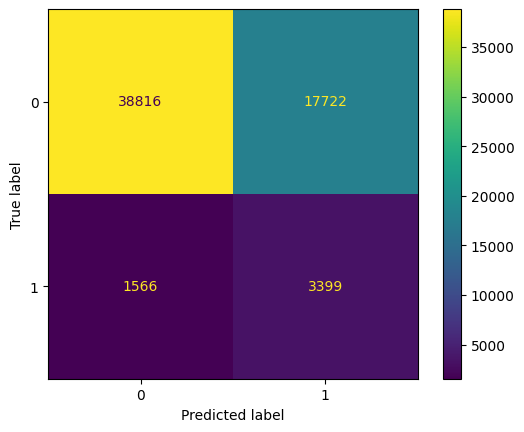

In [353]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipeline_lgbm.classes_)
disp.plot()

In [354]:
features_manual_and_func_from_first_three_with_app_train

SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY   
0           100002                   0             0                1  \
1           100003                   0             0                0   
2           100004                   1             1                1   
3           100006                   0             0                1   
4           100007                   0             0                1   
...            ...                 ...           ...              ...   
307506      456251                   0             0                0   
307507      456252                   0             0                1   
307508      456253                   0             0                1   
307509      456254                   0             0                1   
307510      456255                   0             0                0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY   
0                  0          202500.0    406597.5      24700.5  \
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
307506             0          157500.0    254700.0      27558.0   
307507             0           72000.0    269550.0      12001.5   
307508             0          153000.0    677664.0      29979.0   
307509             0          171000.0    370107.0      20205.0   
307510             0          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH   
0              351000.0                    0.018801       -9461  \
1             1129500.0                    0.003541      -16765   
2              135000.0                    0.010032      -19046   
3              297000.0                    0.008019      -19005   
4              513000.0                    0.028663      -19932   
...                 ...                         ...         ...   
307506         225000.0                    0.032561       -9327   
307507         225000.0                    0.025164      -20775   
307508         585000.0                    0.005002      -14966   
307509         319500.0                    0.005313      -11961   
307510         675000.0                    0.046220      -16856   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE   
0                -637            -3648.0            -2120          NaN  \
1               -1188            -1186.0             -291          NaN   
2                -225            -4260.0            -2531         26.0   
3               -3039            -9833.0            -2437          NaN   
4               -3038            -4311.0            -3458          NaN   
...               ...                ...              ...          ...   
307506           -236            -8456.0            -1982          NaN   
307507         365243            -4388.0            -4090          NaN   
307508          -7921            -6737.0            -5150          NaN   
307509          -4786            -2562.0             -931          NaN   
307510          -1262            -5128.0             -410          NaN   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE   
0                1               1                0                 1  \
1                1               1                0                 1   
2                1               1                1                 1   
3                1               1                0                 1   
4                1               1                0                 1   
...            ...             ...              ...               ...   
307506           1               1                0                 1   
307507           1               0              

In [355]:
filename = 'features_manual_and_func_from_first_three_with_app_train.csv'
features_manual_and_func_from_first_three_with_app_train.to_csv(filename)

test 5